## Projet IMA206:
### Variational Auto-Encoders for cardiac shape modeling

Teacher :
Loic Le Folgoc, Elsa Angelini

- Kelthoum Kerboua
- Cécile Tillerot
- Fatima Baldé
- Manon Heffernan

In [ ]:
import os
import numpy as np
from time import time
import matplotlib.pyplot as plt
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import glob
import cv2 as cv
from skimage.transform import resize
from scipy.ndimage.interpolation import zoom
from scipy import ndimage
from scipy.ndimage import center_of_mass
from scipy.spatial.distance import cdist
from sklearn.metrics import confusion_matrix
import itertools
from scipy.sparse import coo_matrix

import pandas as pd
from skimage.io import imread
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import scipy.ndimage as ndi
from scipy.ndimage import binary_dilation
from scipy.ndimage import distance_transform_edt
import csv
import random
import pdb
from math import floor
from skimage import feature
from tqdm import tqdm
import seaborn as sns
!pip install monai
from monai.losses.dice import DiceLoss
from sklearn.manifold import TSNE
from sklearn.decomposition import FastICA
!pip install umap-learn
import umap.umap_ as umap


def pytorch_to_numpy(x):
  return x.detach().numpy()


print(torch.__version__,"\n", np.__version__,"\n", pd.__version__,"\n", csv.__version__,"\n", nib.__version__)

<ipython-input-1-c95e35b790b0>:14: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import zoom


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.4-py3-none-any.whl size=86770 sha256=1c9f78cb71f0bf340237904153f3027c16bf3d2c81b8e1e890be87d4e23ca3d3
  Stored in directory: /root/.cache/pip/wheels/fb/66/29/199acf5784d0f7b8add6d466175ab45506c96e386ed5dd0633
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55615 sha256=491f8fac8b50c16669a1da31c8f785a3880d337c833d9b845d01bc82c16fd07f
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent
2.0.1+cu118 
 1.23.5 
 1.5.3 
 1.0 
 4.0.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive') #connexion au drive

##**Pre-processing**

In [ ]:
n_rows, n_col= 80, 80

In [ ]:
Working_directory="./drive/MyDrive/IMA206/database/"
Working_directory="./drive/MyDrive/database/"
train_directory = Working_directory + 'training'
test_directory = Working_directory + 'testing'



train_directories = sorted(glob.glob(train_directory + '/*/*gt.nii.gz'))
test_directories = sorted(glob.glob(test_directory + '/*/*gt.nii.gz'))

def align(im):
    """
    Align according to the x axis a given image by :
    -computing the centers of mass of the left and rigth ventricule
    -computing the angle between the line given by the two centers of mass and the x axis
    -rotating the image by that angle
    """
    lv=im==1
    rv=im==3

    if (np.sum(lv)==0 or np.sum(rv)==0):
        return None, False

    x1,y1=ndimage.center_of_mass(lv)
    x2,y2=ndimage.center_of_mass(rv)
    vec1 = np.array([(int(x2 - x1)), int(y2-y1)])  # Premier vecteur
    vec2 = np.array([1, 0])  # vecteur horizontale
    angle_radians = np.arccos(np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2)))
    angle_degres = np.degrees(angle_radians)
    #print("L'angle entre les deux vecteurs est de", angle_degres, "degrés")
    if(y2>y1):
        angle_degres=-angle_degres
    hauteur, largeur = lv.shape[:2]
    # Calculer le centre de rotation
    centre_rotation = (largeur // 2, hauteur // 2)

    # Définir la matrice de rotation
    mat_rotation = cv.getRotationMatrix2D(centre_rotation, angle_degres , 1.0)

    # Appliquer la rotation à l'image
    image_rotationnee = np.round(cv.warpAffine(im, mat_rotation, (largeur, hauteur), flags=cv.INTER_NEAREST)).astype(int)



    return image_rotationnee, True

def cropping(image, marge):
    """
    Parameters :
    - An MRI image
    -A marge
    detects the where the structure is in the image, create a bounding box with the marge given around the structure
    Returns:
    the bounding box containing the structure
    """
    contours=feature.canny(ndimage.morphology.binary_fill_holes(image))
    y, x, w, h = cv.boundingRect(contours.astype(np.uint8))
    largeur=max(h,w)
    image_copy=np.array(image)
    image_crop=image_copy[x-marge:x+largeur+marge, y-marge:y+largeur+marge]
    return image_crop


def onehotencoder_2D(a):
    "Transform an array with n labels into an array with n channels"
    N= a.size
    data = np.ones(N,dtype=int)
    return coo_matrix((data,(np.arange(N),a.ravel())), shape=(N,4)).toarray().reshape((n_rows,n_col,4))

def anatomical_volume(img_seg,voxel_size):
    """
    Takes as parameters the segmented image
    Return an array containing the volume of each label
    """
    #a voxel is a pixel with volume
    #the volume of each area is the number of voxel in that area multiply by the voxels size.
    #Images don't have the same voxel size.


    unique_values, counts = np.unique(img_seg, return_counts=True)

    return (counts[1:]*np.prod(voxel_size))

def extract_imgs(directories):
    """
    Given a directory, this fonction will :
    -get the images
    -align slices
    -crop slices
    -resize them into a unique size  n_rol, n_cols defined earlier
    -transform labellized images into multichannel images
    The fonction also computes labels for images such as:
    - the slice number
    - the volumes of lv, rv and the myocardium in the 3D images
    - the surface of lv , rv and the myocardium in the slice
    """
    imgs=[]
    labels=[]

    for i in (directories):
        img = nib.load(i)
        img_data=img.dataobj
        header=img.header
        voxel_size=header.get_zooms()
        for j in range(img_data.shape[2]):
            slices=img_data[:,:,j]
            slices, rot = align(slices)
            if (rot):
              tab=anatomical_volume(img_data,voxel_size)
              labels_temp=[v for v in tab ]
              labels_temp.append(j/img_data.shape[2])
              slices=cropping(slices, 5)
              slices=np.round((resize(slices, (n_rows,n_col), order=0)))
              slices=torch.from_numpy(onehotencoder_2D(slices).astype('float32'))
              slices=slices.permute(2, 0, 1)
              imgs.append(slices)
              labels_temp= labels_temp+ [torch.sum(slices[label,:,:]) for label in range (1,4)]
              labels.append(np.array(labels_temp))




    #imgs=np.array(imgs)
    #labels=np.array(labels).astype(int)
    return (imgs,labels)

train_imgs, train_labels=extract_imgs(train_directories)
test_imgs, test_labels=extract_imgs(test_directories)

<ipython-input-4-4ddf3a9204b7>:56: DeprecationWarning: Please use `binary_fill_holes` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  contours=feature.canny(ndimage.morphology.binary_fill_holes(image))


In [ ]:
class Dataset_MRI(torch.utils.data.Dataset):
  """
  this class computes our data_loader given the images and their labels
  """
  def __init__(self, imgs, labels, transform=None):
        self.labels = labels
        self.imgs = imgs
        self.transform = transform

  def __len__(self):
        return len(self.imgs)

  def __getitem__(self, indice):
        img = self.imgs[indice]
        label = self.labels[indice]
        if self.transform:
            img = self.transform(img)
        return img, label


batch_size=50
training_data=Dataset_MRI(train_imgs, train_labels)
train_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True, drop_last=True)

test_data=Dataset_MRI(test_imgs, test_labels)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True,drop_last=True)


##**Architecture VAE**

In [ ]:
class VAE(torch.nn.Module ):

  """
  Architecture of the VAE
  """

  def __init__(self, z_dim, n_rows, n_cols):
    super(VAE, self).__init__()
    self.n_rows = n_rows
    self.n_cols = n_cols
    self.n_channels = 4
    self.n_pixels = (self.n_rows)*(self.n_cols)
    self.z_dim = z_dim

    print("rows and cols", self.n_rows, self.n_cols)



    # encoder part
    self.fc11 = nn.Conv2d(in_channels = self.n_channels, out_channels = 16, kernel_size = (3,3), stride = (2,2),padding=1)
    H_out, W_out = self.compute_size(self.n_rows, self.n_cols,padding=(1,1))
    self.fc12 = nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), stride = (1,1), padding=1)
    self.fc21 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (3,3), stride = (2,2), padding=1)
    H_out, W_out = self.compute_size(H_out, W_out,padding=(1,1))
    self.fc22 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = (3,3), stride = (1,1), padding=1)
    self.fc31 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (3,3), stride = (2,2), padding=1)
    self.H_out, self.W_out = self.compute_size(H_out, W_out,padding=(1,1))
    self.fc32 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = (3,3), stride = (1,1), padding=1)

    self.fc51= nn.Linear(self.H_out*self.W_out*64, self.z_dim)
    self.fc52= nn.Linear(self.H_out*self.W_out*64, self.z_dim)


    # decoder part
    self.fc53=nn.Linear(self.z_dim, self.H_out*self.W_out*64)

    self.fc60 = nn.ConvTranspose2d(in_channels = 64, out_channels = 64, kernel_size = (2,2), stride = (2,2))
    self.fc61 = nn.ConvTranspose2d(in_channels = 64, out_channels = 32, kernel_size = (2,2), stride = (2,2))
    self.fc62 = nn.ConvTranspose2d(in_channels = 32, out_channels = 32, kernel_size = (3,3), stride = (1,1), padding=1)
    self.fc71 = nn.ConvTranspose2d(in_channels = 32, out_channels = 16, kernel_size = (2,2), stride = (2,2))
    self.fc72 = nn.ConvTranspose2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), stride = (1,1), padding=1)
    self.fc10 = nn.ConvTranspose2d(in_channels = 16, out_channels = self.n_channels, kernel_size = (3,3), stride = (1,1) ,padding = 1)

    #activations
    self.relu = nn.ReLU()
    self.flatten= nn.Flatten()

  def compute_size(self, H_in, W_in, padding = (0,0), kernel = (3,3), stride=(2,2)):
    """
    Compute the image size after it goes through a layer
    """
    H_out = int((H_in + 2* padding[0] - kernel[0])/stride[0] + 1)
    W_out = int((W_in + 2* padding[1] - kernel[1])/stride[1] + 1)
    return ( H_out, W_out)

  def encoder(self, x):
    h = x
    h = self.relu(self.fc11(h))
    h = self.relu(self.fc12(h))
    h = self.relu(self.fc21(h))
    h = self.relu(self.fc22(h))
    h = self.relu(self.fc31(h))
    h = self.relu(self.fc32(h))
    h= self.flatten(h)
    mu = self.fc51(h)
    sigma = self.fc52(h)
    return mu, sigma

  def decoder(self, z):
    n_samples=z.shape[0]

    h = self.relu(self.fc53(z))
    h = h.view(n_samples, 64, self.H_out, self.W_out)
    h = self.relu(self.fc60(h))
    h = self.relu(self.fc61(h))
    h = self.relu(self.fc62(h))
    h = self.relu(self.fc71(h))
    h = self.relu(self.fc72(h))
    h = self.fc10(h)
    h = nn.Softmax(dim=1)(h)
    return h

  def sampling(self, mu, log_var):
    # this function samples a Gaussian distribution, with average (mu) and standard deviation specified (using log_var)
    std = torch.exp(0.5*log_var)
    eps = torch.randn_like(std)
    if torch.cuda.is_available() :
        eps = eps.cuda()
    return eps.mul(std).add_(mu) # return z sample #attention add_


  def forward(self, x):
    z_mu, z_log_var = self.encoder(x)
    #print(z_mu.shape, z_log_var.shape)
    z = self.sampling(z_mu, z_log_var)
    #print(z.shape)
    return self.decoder(z), z_mu, z_log_var

  def loss_function(self,x, y, mu, log_var, beta=0.01):
    #beta  is the parameter which control the KLD loss
    reconstruction_error = torch.sum(torch.nn.CrossEntropyLoss()(y,x))
    KLD = 0.5 * torch.sum(-1 - log_var + mu**2 + log_var.exp())
    return beta*KLD + DiceLoss(reduction='sum')(x,y)

##**Training VAE**

In [ ]:
def train_vae(vae_model,data_train_loader,vae_optimizer, epoch, beta_=0.01):
  """
  Parameters :
  - the vae_model
  -data_train_loader
  -vae_optimizer
  - epoch
  -beta_
  Returns the dice_loss and kld_loss

  Train the model given in parameter for one epoch
  """
  train_loss = 0
  dice_loss=0
  KLD=0
  for batch_idx, (data, _) in tqdm(enumerate(data_train_loader)):
    vae_optimizer.zero_grad()
    vae_model.train()
    if torch.cuda.is_available() :
        data = data.cuda()

    y, z_mu, z_log_var = vae_model.forward(data)
    loss_vae = vae_model.loss_function(data, y, z_mu, z_log_var, beta=beta_)
    loss_vae.backward()
    train_loss += loss_vae.item()
    dice_loss+=DiceLoss(reduction='mean')(data, y)
    KLD+= 0.5 * torch.mean(-1 - z_log_var + z_mu**2 + z_log_var.exp())
    vae_optimizer.step()

  print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(data_train_loader.dataset)))
  return (dice_loss/len(data_train_loader.dataset)).item(), (KLD/len(data_train_loader.dataset)).item()

In [ ]:
# initialisation of the model
z_dim = 32
n_classes = 5
n_epochs = 200
vae_model= VAE(z_dim, n_rows, n_col)
vae_optimizer= optim.Adam(vae_model.parameters(), lr = 1e-4, weight_decay=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vae_model.to(device)


rows and cols 80 80


VAE(
  (fc11): Conv2d(4, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (fc12): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc21): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (fc22): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc31): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (fc32): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc51): Linear(in_features=6400, out_features=32, bias=True)
  (fc52): Linear(in_features=6400, out_features=32, bias=True)
  (fc53): Linear(in_features=32, out_features=6400, bias=True)
  (fc60): ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
  (fc61): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
  (fc62): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc71): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
  (fc72): ConvTranspose2d(16, 16, kernel_size=(3, 3), strid

In [ ]:
# training our model
for epoch in range(0, n_epochs):
  train_vae(vae_model,train_loader, vae_optimizer, epoch, beta_=0.03)

30it [00:01, 25.17it/s]


====> Epoch: 0 Average loss: 0.7637


30it [00:01, 28.31it/s]


====> Epoch: 1 Average loss: 0.7671


30it [00:00, 37.58it/s]


====> Epoch: 2 Average loss: 0.7601


30it [00:01, 29.62it/s]


====> Epoch: 3 Average loss: 0.7609


30it [00:00, 37.12it/s]


====> Epoch: 4 Average loss: 0.7582


30it [00:00, 36.24it/s]


====> Epoch: 5 Average loss: 0.7629


30it [00:00, 35.77it/s]


====> Epoch: 6 Average loss: 0.7514


30it [00:01, 26.49it/s]


====> Epoch: 7 Average loss: 0.7603


30it [00:00, 34.02it/s]


====> Epoch: 8 Average loss: 0.7519


30it [00:00, 42.42it/s]


====> Epoch: 9 Average loss: 0.7504


30it [00:00, 42.18it/s]


====> Epoch: 10 Average loss: 0.7512


30it [00:00, 41.17it/s]


====> Epoch: 11 Average loss: 0.7488


30it [00:00, 40.99it/s]


====> Epoch: 12 Average loss: 0.7473


30it [00:00, 44.12it/s]


====> Epoch: 13 Average loss: 0.7440


30it [00:00, 46.17it/s]


====> Epoch: 14 Average loss: 0.7455


30it [00:00, 47.39it/s]


====> Epoch: 15 Average loss: 0.7401


30it [00:00, 45.50it/s]


====> Epoch: 16 Average loss: 0.7459


30it [00:00, 46.49it/s]


====> Epoch: 17 Average loss: 0.7442


30it [00:00, 46.70it/s]


====> Epoch: 18 Average loss: 0.7426


30it [00:00, 45.71it/s]


====> Epoch: 19 Average loss: 0.7450


30it [00:00, 45.37it/s]


====> Epoch: 20 Average loss: 0.7405


30it [00:00, 45.88it/s]


====> Epoch: 21 Average loss: 0.7428


30it [00:00, 45.60it/s]


====> Epoch: 22 Average loss: 0.7405


30it [00:00, 45.68it/s]


====> Epoch: 23 Average loss: 0.7358


30it [00:00, 46.07it/s]


====> Epoch: 24 Average loss: 0.7380


30it [00:00, 45.22it/s]


====> Epoch: 25 Average loss: 0.7345


30it [00:00, 47.02it/s]


====> Epoch: 26 Average loss: 0.7297


30it [00:00, 46.50it/s]


====> Epoch: 27 Average loss: 0.7316


30it [00:00, 43.24it/s]


====> Epoch: 28 Average loss: 0.7370


30it [00:00, 42.09it/s]


====> Epoch: 29 Average loss: 0.7325


30it [00:00, 42.09it/s]


====> Epoch: 30 Average loss: 0.7267


30it [00:00, 41.16it/s]


====> Epoch: 31 Average loss: 0.7316


30it [00:00, 43.22it/s]


====> Epoch: 32 Average loss: 0.7287


30it [00:00, 41.45it/s]


====> Epoch: 33 Average loss: 0.7245


30it [00:00, 46.13it/s]


====> Epoch: 34 Average loss: 0.7313


30it [00:00, 46.62it/s]


====> Epoch: 35 Average loss: 0.7246


30it [00:00, 44.65it/s]


====> Epoch: 36 Average loss: 0.7260


30it [00:00, 44.36it/s]


====> Epoch: 37 Average loss: 0.7259


30it [00:00, 45.01it/s]


====> Epoch: 38 Average loss: 0.7201


30it [00:00, 44.10it/s]


====> Epoch: 39 Average loss: 0.7264


30it [00:00, 45.06it/s]


====> Epoch: 40 Average loss: 0.7245


30it [00:00, 47.07it/s]


====> Epoch: 41 Average loss: 0.7204


30it [00:00, 45.89it/s]


====> Epoch: 42 Average loss: 0.7211


30it [00:00, 44.73it/s]


====> Epoch: 43 Average loss: 0.7224


30it [00:00, 43.80it/s]


====> Epoch: 44 Average loss: 0.7225


30it [00:00, 45.19it/s]


====> Epoch: 45 Average loss: 0.7167


30it [00:00, 44.63it/s]


====> Epoch: 46 Average loss: 0.7189


30it [00:00, 44.93it/s]


====> Epoch: 47 Average loss: 0.7210


30it [00:00, 42.59it/s]


====> Epoch: 48 Average loss: 0.7160


30it [00:00, 41.47it/s]


====> Epoch: 49 Average loss: 0.7188


30it [00:00, 41.51it/s]


====> Epoch: 50 Average loss: 0.7177


30it [00:00, 41.40it/s]


====> Epoch: 51 Average loss: 0.7200


30it [00:00, 41.93it/s]


====> Epoch: 52 Average loss: 0.7159


30it [00:00, 40.98it/s]


====> Epoch: 53 Average loss: 0.7158


30it [00:00, 45.24it/s]


====> Epoch: 54 Average loss: 0.7157


30it [00:00, 44.32it/s]


====> Epoch: 55 Average loss: 0.7088


30it [00:00, 44.50it/s]


====> Epoch: 56 Average loss: 0.7100


30it [00:00, 44.34it/s]


====> Epoch: 57 Average loss: 0.7116


30it [00:00, 45.46it/s]


====> Epoch: 58 Average loss: 0.7155


30it [00:00, 45.34it/s]


====> Epoch: 59 Average loss: 0.7111


30it [00:00, 44.83it/s]


====> Epoch: 60 Average loss: 0.7110


30it [00:00, 45.86it/s]


====> Epoch: 61 Average loss: 0.7106


30it [00:00, 46.02it/s]


====> Epoch: 62 Average loss: 0.7094


30it [00:00, 45.81it/s]


====> Epoch: 63 Average loss: 0.7133


30it [00:00, 46.17it/s]


====> Epoch: 64 Average loss: 0.7068


30it [00:00, 46.12it/s]


====> Epoch: 65 Average loss: 0.7078


30it [00:00, 46.38it/s]


====> Epoch: 66 Average loss: 0.7095


30it [00:00, 45.53it/s]


====> Epoch: 67 Average loss: 0.7076


30it [00:00, 42.56it/s]


====> Epoch: 68 Average loss: 0.7072


30it [00:00, 40.53it/s]


====> Epoch: 69 Average loss: 0.7101


30it [00:00, 40.54it/s]


====> Epoch: 70 Average loss: 0.7059


30it [00:00, 41.45it/s]


====> Epoch: 71 Average loss: 0.7094


30it [00:00, 41.62it/s]


====> Epoch: 72 Average loss: 0.7076


30it [00:00, 40.69it/s]


====> Epoch: 73 Average loss: 0.7095


30it [00:00, 44.87it/s]


====> Epoch: 74 Average loss: 0.7029


30it [00:00, 45.16it/s]


====> Epoch: 75 Average loss: 0.7007


30it [00:00, 45.12it/s]


====> Epoch: 76 Average loss: 0.7056


30it [00:00, 45.43it/s]


====> Epoch: 77 Average loss: 0.7023


30it [00:00, 47.11it/s]


====> Epoch: 78 Average loss: 0.7027


30it [00:00, 45.49it/s]


====> Epoch: 79 Average loss: 0.6996


30it [00:00, 45.46it/s]


====> Epoch: 80 Average loss: 0.7045


30it [00:00, 45.75it/s]


====> Epoch: 81 Average loss: 0.7049


30it [00:00, 46.03it/s]


====> Epoch: 82 Average loss: 0.6963


30it [00:00, 47.01it/s]


====> Epoch: 83 Average loss: 0.7018


30it [00:00, 48.30it/s]


====> Epoch: 84 Average loss: 0.6969


30it [00:00, 46.71it/s]


====> Epoch: 85 Average loss: 0.6992


30it [00:00, 45.69it/s]


====> Epoch: 86 Average loss: 0.6967


30it [00:00, 44.88it/s]


====> Epoch: 87 Average loss: 0.7005


30it [00:00, 44.50it/s]


====> Epoch: 88 Average loss: 0.6986


30it [00:00, 42.24it/s]


====> Epoch: 89 Average loss: 0.6973


30it [00:00, 42.37it/s]


====> Epoch: 90 Average loss: 0.6966


30it [00:00, 41.65it/s]


====> Epoch: 91 Average loss: 0.6949


30it [00:00, 41.10it/s]


====> Epoch: 92 Average loss: 0.6916


30it [00:00, 40.64it/s]


====> Epoch: 93 Average loss: 0.6980


30it [00:00, 43.83it/s]


====> Epoch: 94 Average loss: 0.6930


30it [00:00, 43.91it/s]


====> Epoch: 95 Average loss: 0.6988


30it [00:00, 45.93it/s]


====> Epoch: 96 Average loss: 0.6941


30it [00:00, 46.22it/s]


====> Epoch: 97 Average loss: 0.6947


30it [00:00, 46.66it/s]


====> Epoch: 98 Average loss: 0.6991


30it [00:00, 45.44it/s]


====> Epoch: 99 Average loss: 0.6911


30it [00:00, 45.49it/s]


====> Epoch: 100 Average loss: 0.6929


30it [00:00, 45.49it/s]


====> Epoch: 101 Average loss: 0.6936


30it [00:00, 48.34it/s]


====> Epoch: 102 Average loss: 0.6902


30it [00:00, 47.34it/s]


====> Epoch: 103 Average loss: 0.6871


30it [00:00, 46.63it/s]


====> Epoch: 104 Average loss: 0.6912


30it [00:00, 46.07it/s]


====> Epoch: 105 Average loss: 0.6885


30it [00:00, 45.04it/s]


====> Epoch: 106 Average loss: 0.6920


30it [00:00, 46.32it/s]


====> Epoch: 107 Average loss: 0.6909


30it [00:00, 46.24it/s]


====> Epoch: 108 Average loss: 0.6921


30it [00:00, 42.26it/s]


====> Epoch: 109 Average loss: 0.6888


30it [00:00, 41.84it/s]


====> Epoch: 110 Average loss: 0.6879


30it [00:00, 42.06it/s]


====> Epoch: 111 Average loss: 0.6859


30it [00:00, 41.36it/s]


====> Epoch: 112 Average loss: 0.6845


30it [00:00, 41.26it/s]


====> Epoch: 113 Average loss: 0.6897


30it [00:00, 42.63it/s]


====> Epoch: 114 Average loss: 0.6883


30it [00:00, 46.01it/s]


====> Epoch: 115 Average loss: 0.6827


30it [00:00, 46.11it/s]


====> Epoch: 116 Average loss: 0.6846


30it [00:00, 46.83it/s]


====> Epoch: 117 Average loss: 0.6855


30it [00:00, 45.68it/s]


====> Epoch: 118 Average loss: 0.6902


30it [00:00, 46.38it/s]


====> Epoch: 119 Average loss: 0.6835


30it [00:00, 47.30it/s]


====> Epoch: 120 Average loss: 0.6852


30it [00:00, 45.81it/s]


====> Epoch: 121 Average loss: 0.6845


30it [00:00, 45.77it/s]


====> Epoch: 122 Average loss: 0.6825


30it [00:00, 44.72it/s]


====> Epoch: 123 Average loss: 0.6847


30it [00:00, 45.50it/s]


====> Epoch: 124 Average loss: 0.6805


30it [00:00, 47.14it/s]


====> Epoch: 125 Average loss: 0.6808


30it [00:00, 46.27it/s]


====> Epoch: 126 Average loss: 0.6835


30it [00:00, 46.42it/s]


====> Epoch: 127 Average loss: 0.6764


30it [00:00, 47.15it/s]


====> Epoch: 128 Average loss: 0.6788


30it [00:00, 46.47it/s]


====> Epoch: 129 Average loss: 0.6817


30it [00:00, 43.20it/s]


====> Epoch: 130 Average loss: 0.6813


30it [00:00, 42.32it/s]


====> Epoch: 131 Average loss: 0.6826


30it [00:00, 43.11it/s]


====> Epoch: 132 Average loss: 0.6822


30it [00:00, 42.05it/s]


====> Epoch: 133 Average loss: 0.6843


30it [00:00, 43.46it/s]


====> Epoch: 134 Average loss: 0.6834


30it [00:00, 44.34it/s]


====> Epoch: 135 Average loss: 0.6783


30it [00:00, 45.55it/s]


====> Epoch: 136 Average loss: 0.6797


30it [00:00, 45.69it/s]


====> Epoch: 137 Average loss: 0.6811


30it [00:00, 46.57it/s]


====> Epoch: 138 Average loss: 0.6755


30it [00:00, 43.92it/s]


====> Epoch: 139 Average loss: 0.6800


30it [00:00, 43.85it/s]


====> Epoch: 140 Average loss: 0.6774


30it [00:00, 45.04it/s]


====> Epoch: 141 Average loss: 0.6790


30it [00:00, 45.75it/s]


====> Epoch: 142 Average loss: 0.6734


30it [00:00, 47.74it/s]


====> Epoch: 143 Average loss: 0.6738


30it [00:00, 45.32it/s]


====> Epoch: 144 Average loss: 0.6767


30it [00:00, 45.81it/s]


====> Epoch: 145 Average loss: 0.6749


30it [00:00, 45.92it/s]


====> Epoch: 146 Average loss: 0.6793


30it [00:00, 45.76it/s]


====> Epoch: 147 Average loss: 0.6718


30it [00:00, 45.86it/s]


====> Epoch: 148 Average loss: 0.6779


30it [00:00, 45.46it/s]


====> Epoch: 149 Average loss: 0.6763


30it [00:00, 42.75it/s]


====> Epoch: 150 Average loss: 0.6771


30it [00:00, 40.40it/s]


====> Epoch: 151 Average loss: 0.6766


30it [00:00, 42.02it/s]


====> Epoch: 152 Average loss: 0.6789


30it [00:00, 39.43it/s]


====> Epoch: 153 Average loss: 0.6768


30it [00:00, 40.33it/s]


====> Epoch: 154 Average loss: 0.6740


30it [00:00, 43.69it/s]


====> Epoch: 155 Average loss: 0.6685


30it [00:00, 45.58it/s]


====> Epoch: 156 Average loss: 0.6702


30it [00:00, 45.56it/s]


====> Epoch: 157 Average loss: 0.6748


30it [00:00, 47.05it/s]


====> Epoch: 158 Average loss: 0.6724


30it [00:00, 47.16it/s]


====> Epoch: 159 Average loss: 0.6713


30it [00:00, 46.72it/s]


====> Epoch: 160 Average loss: 0.6723


30it [00:00, 44.71it/s]


====> Epoch: 161 Average loss: 0.6734


30it [00:00, 44.68it/s]


====> Epoch: 162 Average loss: 0.6708


30it [00:00, 44.96it/s]


====> Epoch: 163 Average loss: 0.6726


30it [00:00, 46.03it/s]


====> Epoch: 164 Average loss: 0.6712


30it [00:00, 46.84it/s]


====> Epoch: 165 Average loss: 0.6710


30it [00:00, 43.69it/s]


====> Epoch: 166 Average loss: 0.6699


30it [00:00, 45.99it/s]


====> Epoch: 167 Average loss: 0.6730


30it [00:00, 44.77it/s]


====> Epoch: 168 Average loss: 0.6677


30it [00:00, 45.76it/s]


====> Epoch: 169 Average loss: 0.6693


30it [00:00, 43.30it/s]


====> Epoch: 170 Average loss: 0.6664


30it [00:00, 40.47it/s]


====> Epoch: 171 Average loss: 0.6660


30it [00:00, 42.04it/s]


====> Epoch: 172 Average loss: 0.6696


30it [00:00, 41.42it/s]


====> Epoch: 173 Average loss: 0.6688


30it [00:00, 40.90it/s]


====> Epoch: 174 Average loss: 0.6723


30it [00:00, 43.66it/s]


====> Epoch: 175 Average loss: 0.6688


30it [00:00, 45.34it/s]


====> Epoch: 176 Average loss: 0.6700


30it [00:00, 46.16it/s]


====> Epoch: 177 Average loss: 0.6674


30it [00:00, 45.94it/s]


====> Epoch: 178 Average loss: 0.6695


30it [00:00, 46.61it/s]


====> Epoch: 179 Average loss: 0.6671


30it [00:00, 44.75it/s]


====> Epoch: 180 Average loss: 0.6675


30it [00:00, 45.59it/s]


====> Epoch: 181 Average loss: 0.6688


30it [00:00, 44.82it/s]


====> Epoch: 182 Average loss: 0.6685


30it [00:00, 46.17it/s]


====> Epoch: 183 Average loss: 0.6682


30it [00:00, 47.62it/s]


====> Epoch: 184 Average loss: 0.6662


30it [00:00, 45.35it/s]


====> Epoch: 185 Average loss: 0.6626


30it [00:00, 45.83it/s]


====> Epoch: 186 Average loss: 0.6624


30it [00:00, 45.07it/s]


====> Epoch: 187 Average loss: 0.6619


30it [00:00, 45.04it/s]


====> Epoch: 188 Average loss: 0.6671


30it [00:00, 46.01it/s]


====> Epoch: 189 Average loss: 0.6676


30it [00:00, 45.21it/s]


====> Epoch: 190 Average loss: 0.6638


30it [00:00, 41.31it/s]


====> Epoch: 191 Average loss: 0.6677


30it [00:00, 41.53it/s]


====> Epoch: 192 Average loss: 0.6659


30it [00:00, 41.95it/s]


====> Epoch: 193 Average loss: 0.6656


30it [00:00, 42.27it/s]


====> Epoch: 194 Average loss: 0.6648


30it [00:00, 42.37it/s]


====> Epoch: 195 Average loss: 0.6617


30it [00:00, 45.54it/s]


====> Epoch: 196 Average loss: 0.6632


30it [00:00, 44.58it/s]


====> Epoch: 197 Average loss: 0.6648


30it [00:00, 45.59it/s]


====> Epoch: 198 Average loss: 0.6658


30it [00:00, 45.40it/s]

====> Epoch: 199 Average loss: 0.6607


In [ ]:
def pytorch_to_numpy(x):
  # transform a tensor to a numpy ndarray
  return x.detach().numpy()


def generate_images_vae(vae_model,n_images = 5):
  """
  Generates images unsing a trained model
  """
  epsilon = torch.zeros(n_images,vae_model.z_dim)
  for i in range (n_images):
        epsilon[i]=torch.normal(mean=torch.zeros(vae_model.z_dim), std=torch.ones(vae_model.z_dim))
  if torch.cuda.is_available() :
    epsilon=epsilon.cuda()
  imgs_generated = vae_model.decoder(epsilon)
  if torch.cuda.is_available() :
    imgs_generated = imgs_generated.cpu()
  return(imgs_generated)


def merge_image_vae(image):
  """
  Merge images with 4 channel into a one channel image with labels
  """
  image_arg_max= torch.argmax(image, dim=0)
  x0,y0=np.where(image_arg_max==1)
  x1,y1=np.where(image_arg_max==2)
  x2,y2=np.where(image_arg_max==3)
  merged_image=torch.zeros((image.shape[1], image.shape[2]), dtype=torch.int64)
  merged_image[x0,y0]=1
  merged_image[x1,y1]=2
  merged_image[x2,y2]=3

  return merged_image


def display_images(imgs):
  """
  displays images
  """
  c = imgs.shape[0]
  fig, axs = plt.subplots(1,c)
  for j in range(c):
      axs[j].imshow(merge_image_vae(imgs[j, :,:,:]), cmap='gray')
      axs[j].axis('off')
  plt.show()

### **TEST CODE**

torch.Size([50, 4, 80, 80])


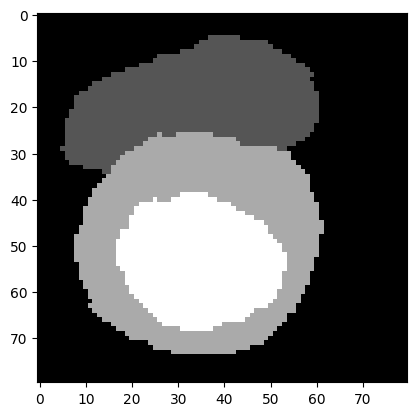

torch.Size([50, 4, 80, 80])


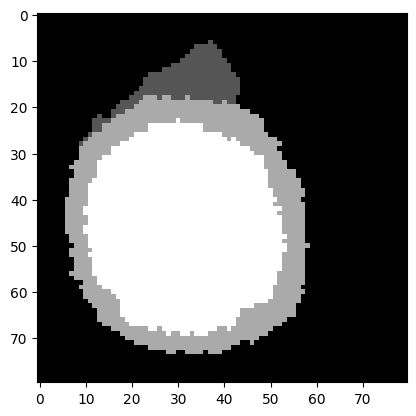

torch.Size([50, 4, 80, 80])


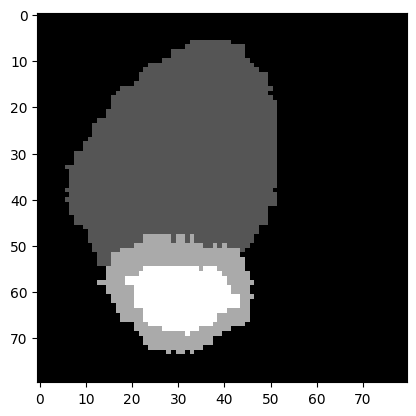

torch.Size([50, 4, 80, 80])


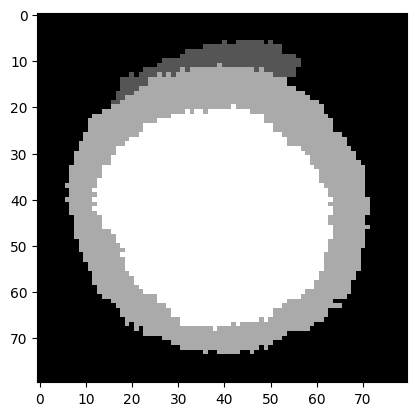

torch.Size([50, 4, 80, 80])


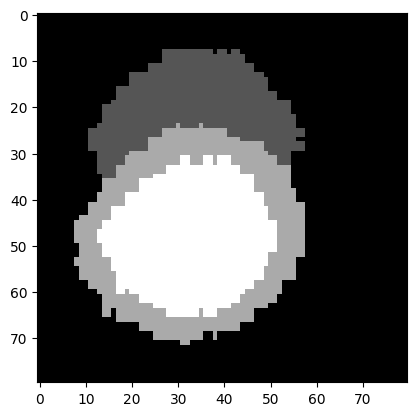

torch.Size([50, 4, 80, 80])


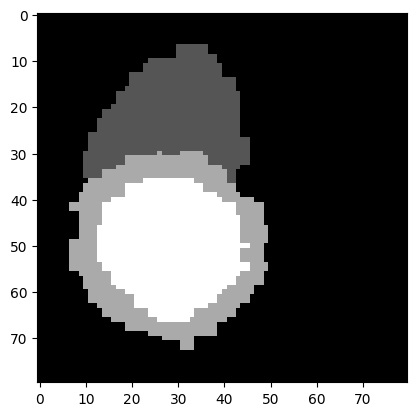

torch.Size([50, 4, 80, 80])


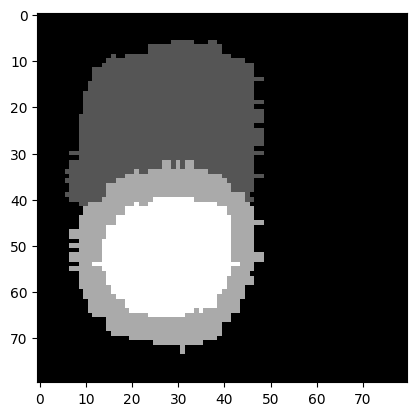

torch.Size([50, 4, 80, 80])


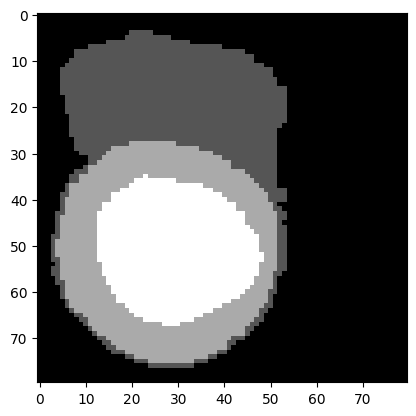

torch.Size([50, 4, 80, 80])


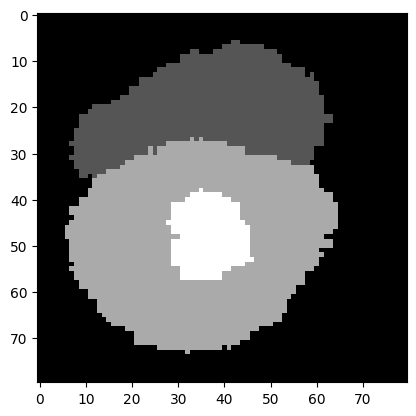

torch.Size([50, 4, 80, 80])


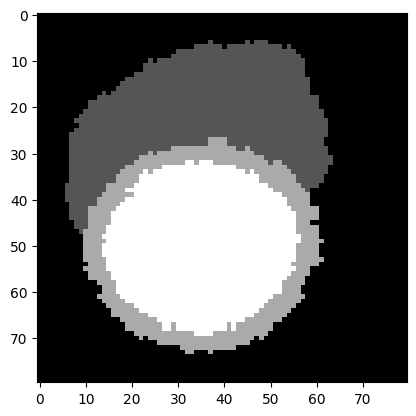

torch.Size([50, 4, 80, 80])


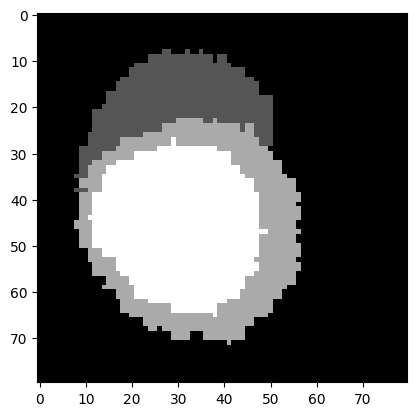

torch.Size([50, 4, 80, 80])


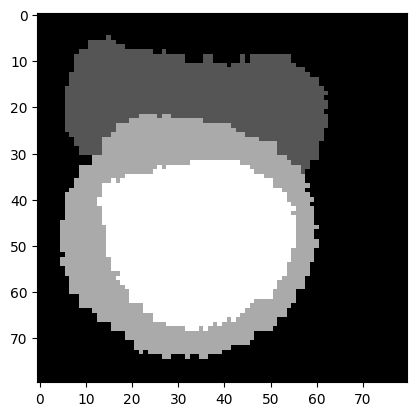

torch.Size([50, 4, 80, 80])


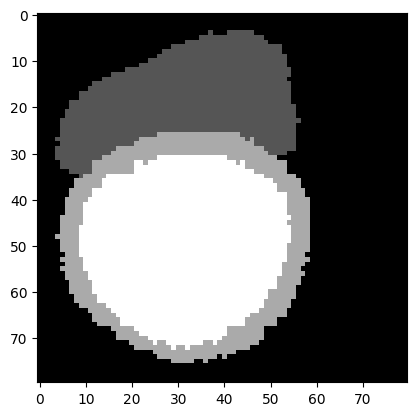

torch.Size([50, 4, 80, 80])


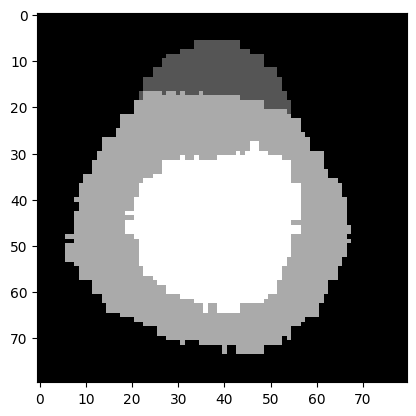

torch.Size([50, 4, 80, 80])


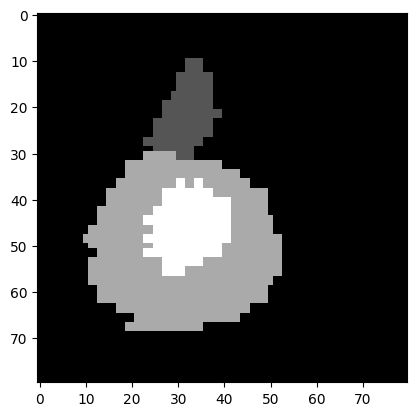

torch.Size([50, 4, 80, 80])


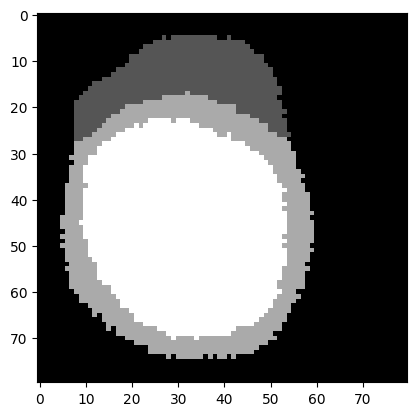

torch.Size([50, 4, 80, 80])


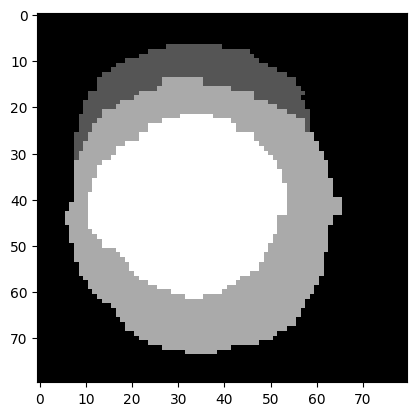

torch.Size([50, 4, 80, 80])


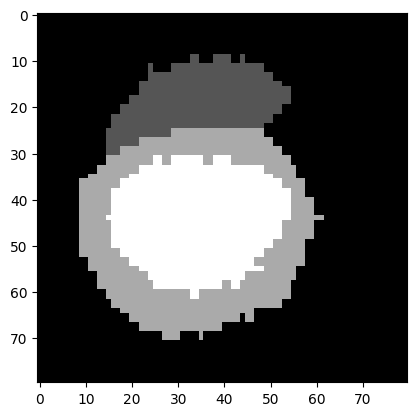

torch.Size([50, 4, 80, 80])


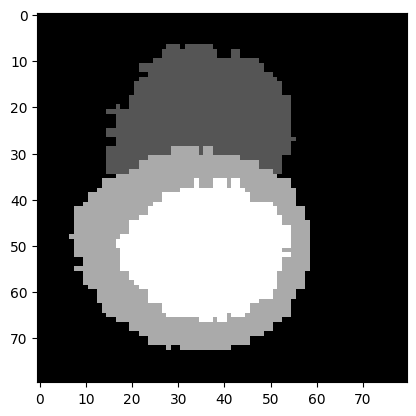

torch.Size([50, 4, 80, 80])


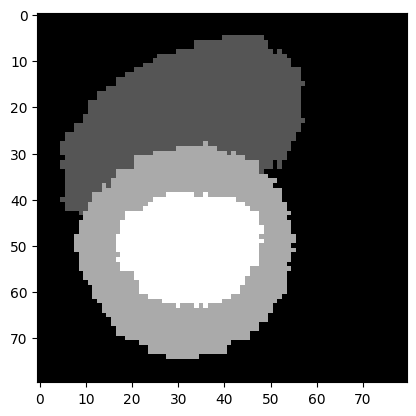

torch.Size([50, 4, 80, 80])


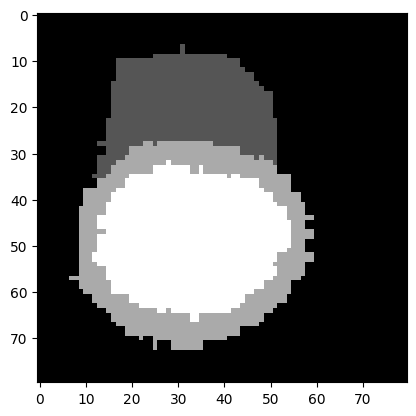

In [ ]:
#Images fournies au VAE, renvoyées par le dataloader
i=0
for batch_idx, (data, _) in enumerate(train_loader):
    print(data.shape)
    plt.imshow(merge_image_vae(data[0]), cmap='gray')
    plt.show()
    i+=1
    if i>20:
        break
plt.show()

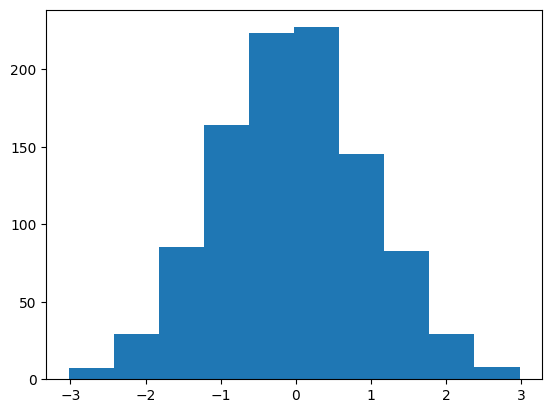

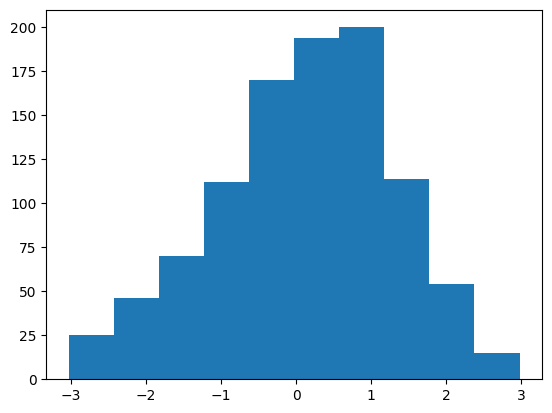

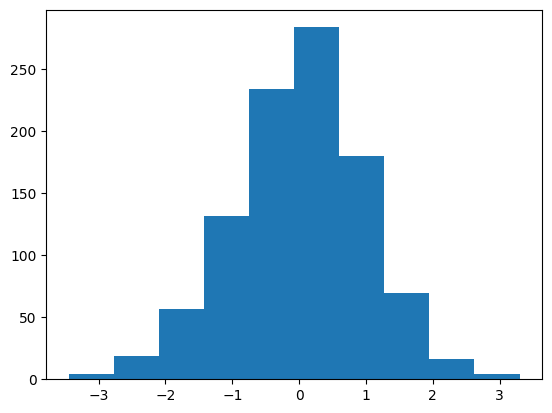

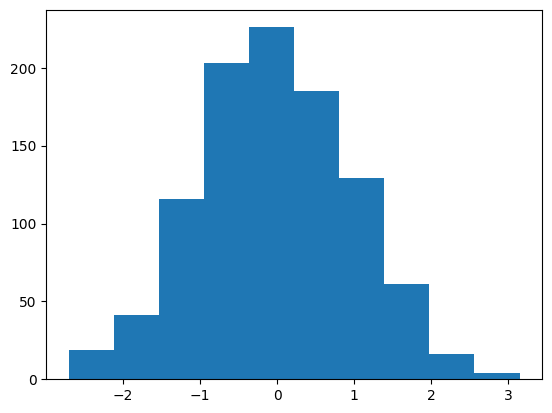

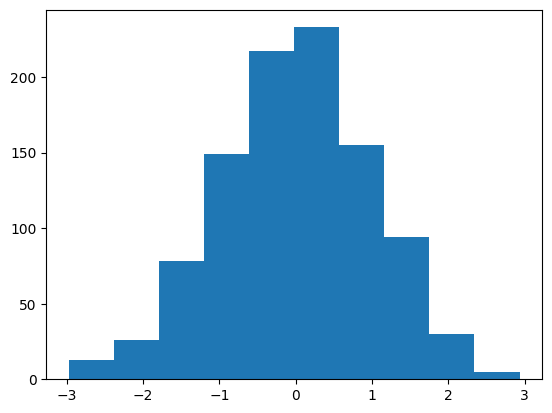

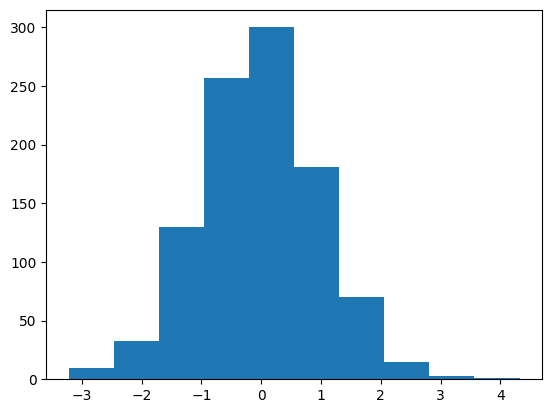

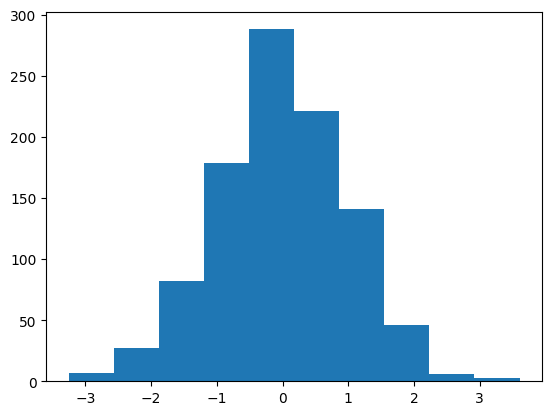

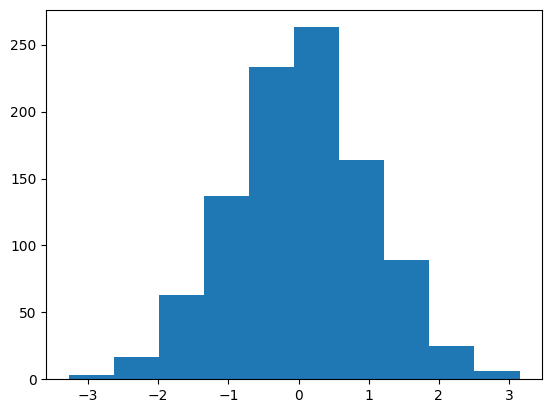

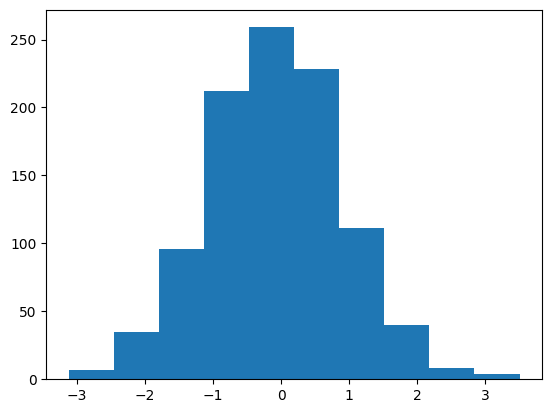

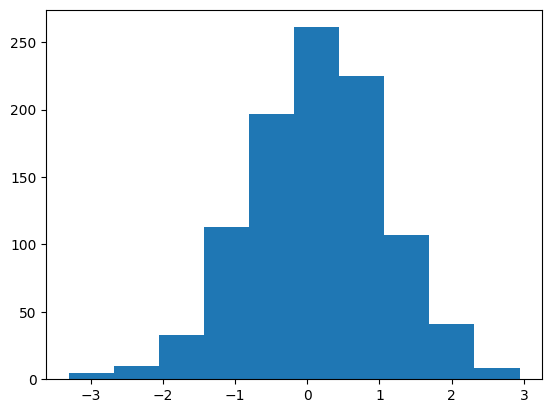

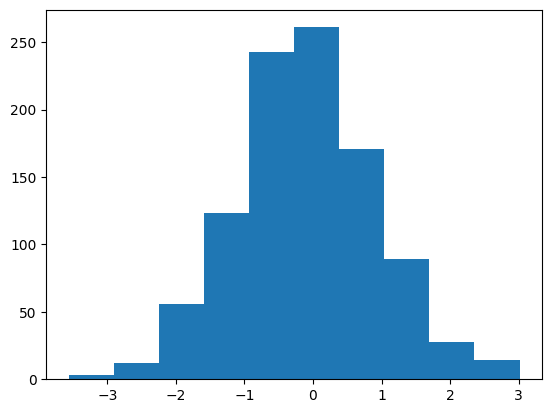

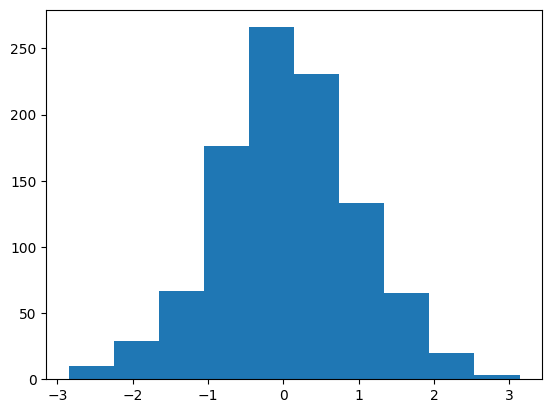

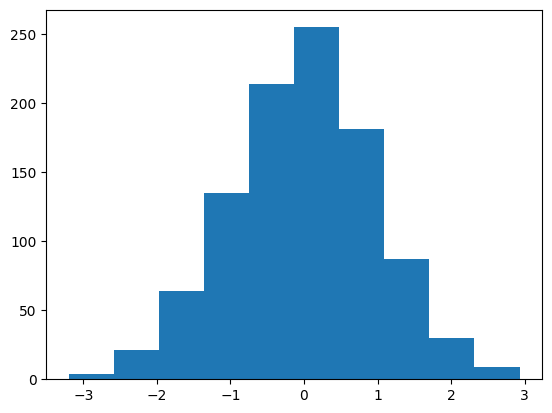

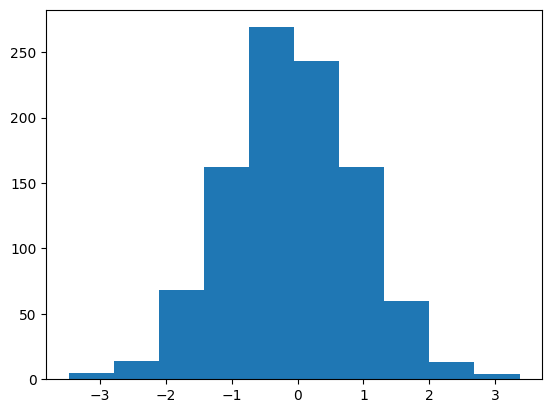

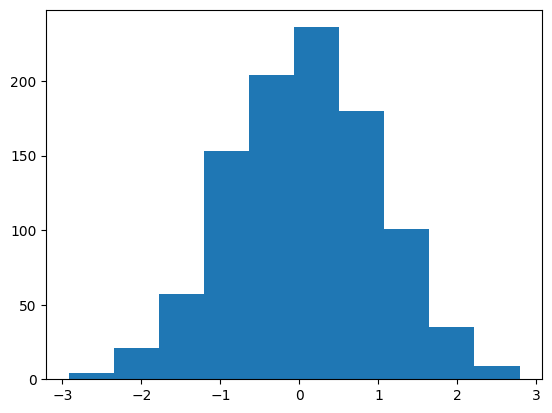

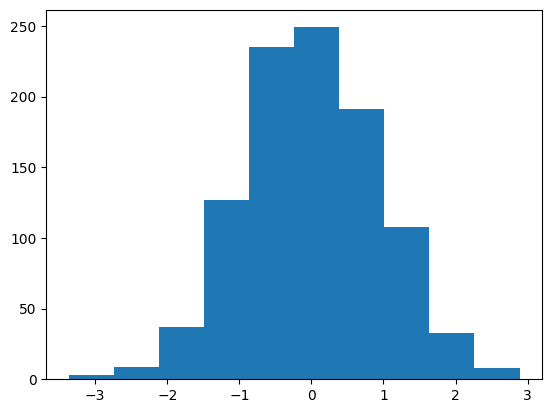

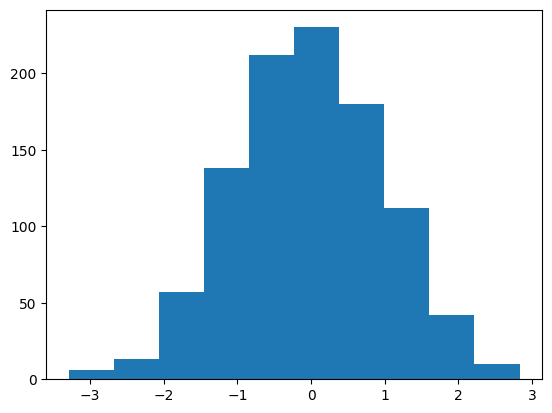

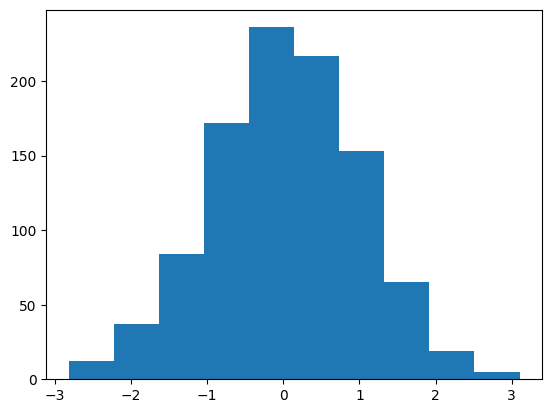

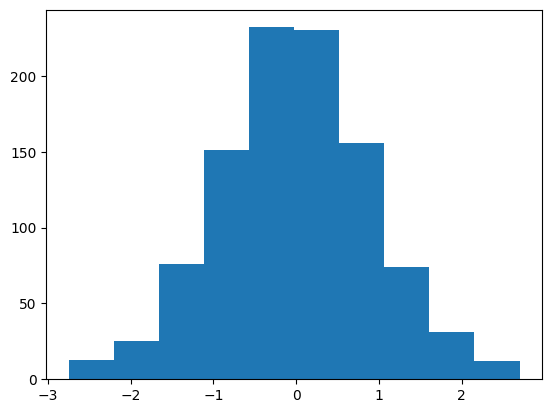

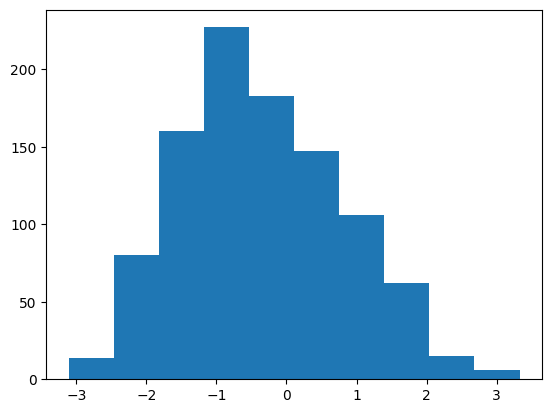

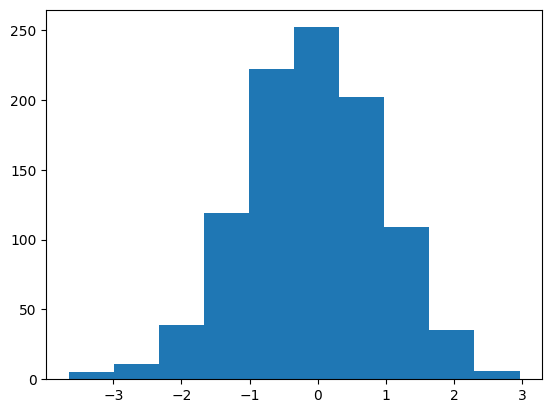

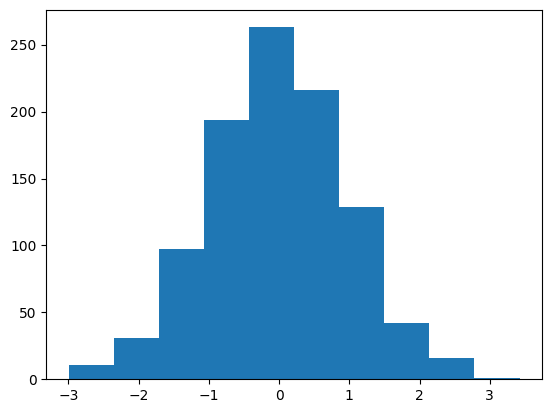

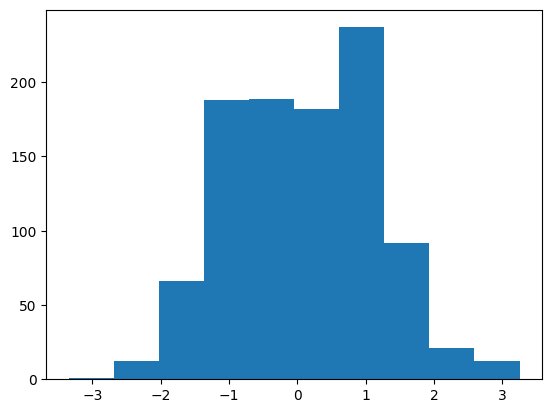

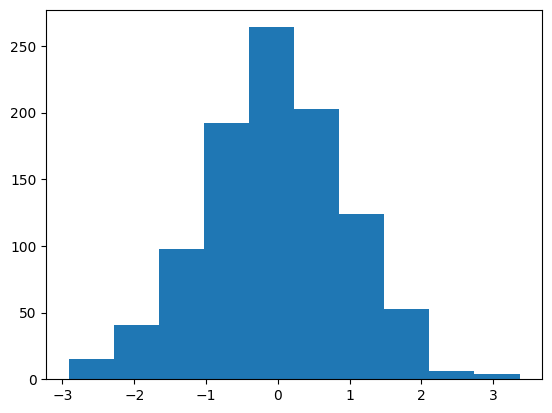

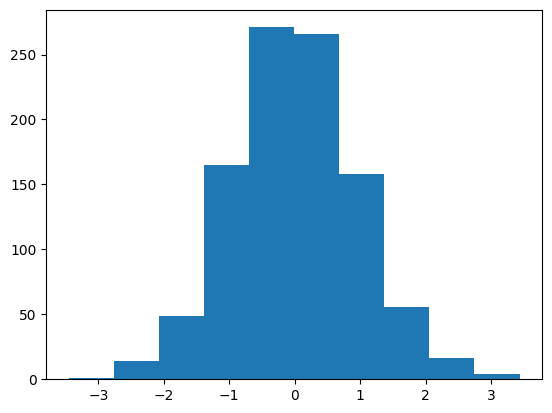

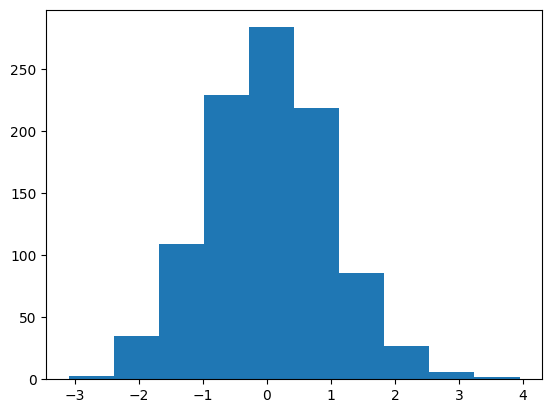

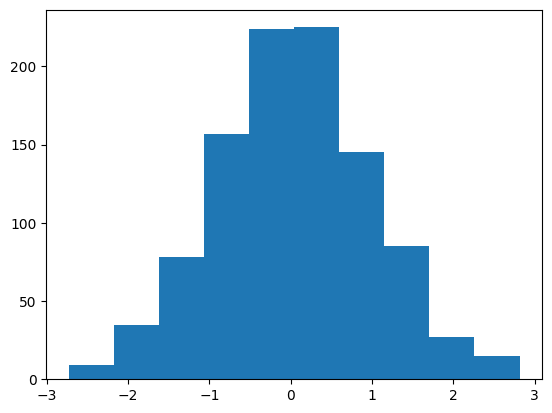

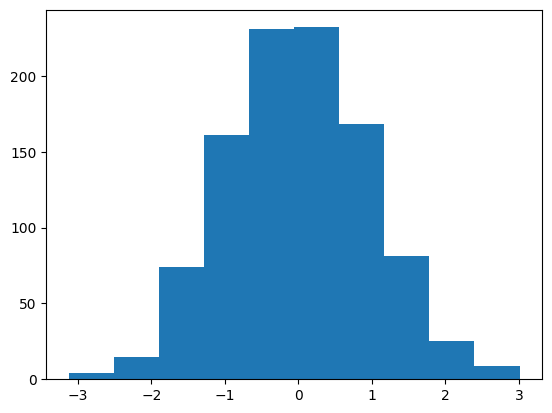

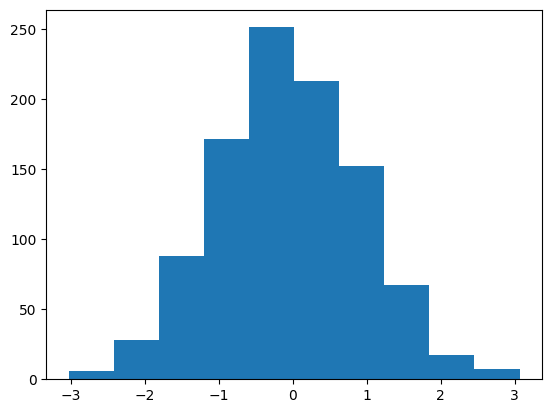

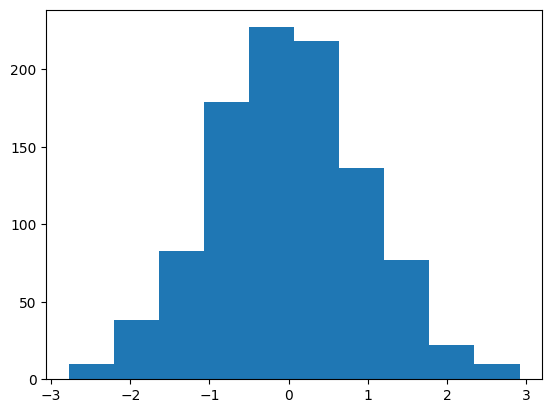

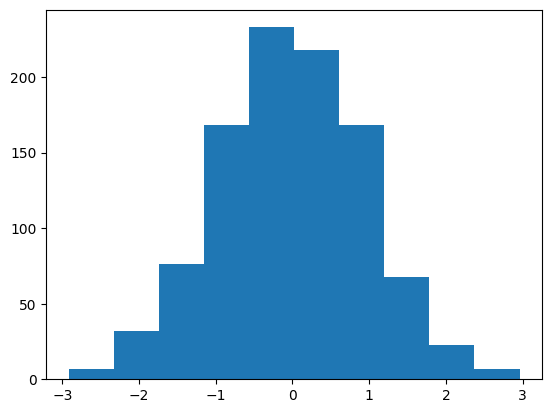

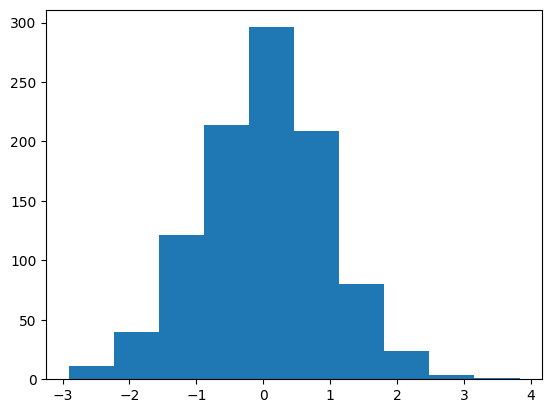

In [ ]:
#Verification de l'échantillonage  (distribution de z (espace latent))
n= len(test_imgs)
indice=np.random.randint(n,size=1000)
imgs_test=torch.zeros(1000,4,80,80)
for i in range(1000):
  imgs_test[i]=test_imgs[indice[i]]
if torch.cuda.is_available() :
        imgs_test = imgs_test.cuda()
mu, log_var= vae_model.encoder(imgs_test)
epsilon = vae_model.sampling(mu, log_var)
imgs_generated = vae_model.decoder(epsilon)
epsilon=epsilon.cpu().detach().numpy()
for i in range (len(epsilon[0])):
  plt.hist(epsilon[:,i], bins=10)
  plt.show()

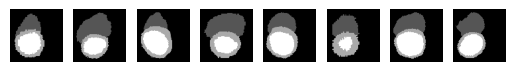

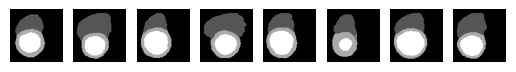

In [ ]:
#Retour du vae pour images test
n= len(test_imgs)
indice=np.random.randint(n,size=8)
imgs_test=torch.zeros(8,4,80,80)
for i in range(8):
  imgs_test[i]=test_imgs[indice[i]]
display_images(imgs_test)
if torch.cuda.is_available() :
        imgs_test = imgs_test.cuda()
mu, log_var= vae_model.encoder(imgs_test)
epsilon = vae_model.sampling(mu, log_var)
imgs_generated = vae_model.decoder(epsilon)
display_images(imgs_generated.cpu())

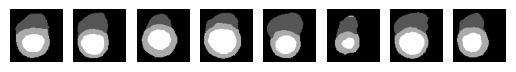

In [ ]:
#Généréation aléatoire
imgs_generated = generate_images_vae(vae_model,n_images=8)
display_images(imgs_generated)

In [ ]:
def accuracy_vae(vae_model,data_loader):
  """
  Computes the accuray of yhe model
  """
  loss = 0
  for batch_idx, (data, _) in enumerate(data_loader):
    if torch.cuda.is_available() :
        data = data.cuda()
    y_pred, _, _ = vae_model.forward(data)
    y_true=torch.argmax(data,dim=1)
    y_pred= torch.argmax(y_pred,dim=1)
    loss+= torch.count_nonzero(y_true-y_pred)/(n_rows*n_col)
  return (100 - (100 * (loss/ len(data_loader.dataset)))).item()

def diceloss_vae(vae_model,data_loader):
  loss = 0
  for batch_idx, (data, _) in enumerate(data_loader):
    if torch.cuda.is_available() :
        data = data.cuda()
    y, _, _ = vae_model.forward(data)
    loss+=DiceLoss(reduction='mean')(data, y)
  return (loss/ len(data_loader.dataset)).item()

In [ ]:
#Convergence des loss

z_dim = 32
n_classes = 5
n_epochs = 200
vae_model= VAE(z_dim, n_rows, n_col)
vae_optimizer= optim.Adam(vae_model.parameters(), lr = 1e-4, weight_decay=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vae_model.to(device)

dice_losses=[]
kld_losses=[]
train_losses=[]
test_losses=[]
for epoch in range(0, n_epochs):
  diceloss, kld = train_vae(vae_model,train_loader, vae_optimizer, epoch, beta_=0.03)
  dice_losses.append(diceloss)
  kld_losses.append(kld)
  train_losses.append(diceloss_vae(vae_model,train_loader))
  test_losses.append(diceloss_vae(vae_model,test_loader))

rows and cols 80 80


30it [00:07,  3.83it/s]


====> Epoch: 0 Average loss: 3.0656


30it [00:00, 49.62it/s]


====> Epoch: 1 Average loss: 3.0538


30it [00:00, 48.38it/s]


====> Epoch: 2 Average loss: 3.0279


30it [00:00, 47.41it/s]


====> Epoch: 3 Average loss: 2.9660


30it [00:00, 45.06it/s]


====> Epoch: 4 Average loss: 2.9331


30it [00:00, 45.40it/s]


====> Epoch: 5 Average loss: 2.8965


30it [00:00, 47.77it/s]


====> Epoch: 6 Average loss: 2.8085


30it [00:00, 47.92it/s]


====> Epoch: 7 Average loss: 2.6392


30it [00:00, 42.12it/s]


====> Epoch: 8 Average loss: 2.5042


30it [00:00, 40.39it/s]


====> Epoch: 9 Average loss: 2.4409


30it [00:00, 40.54it/s]


====> Epoch: 10 Average loss: 2.3970


30it [00:00, 45.32it/s]


====> Epoch: 11 Average loss: 2.3441


30it [00:00, 44.97it/s]


====> Epoch: 12 Average loss: 2.2537


30it [00:00, 45.16it/s]


====> Epoch: 13 Average loss: 2.0999


30it [00:00, 48.29it/s]


====> Epoch: 14 Average loss: 1.8648


30it [00:00, 45.15it/s]


====> Epoch: 15 Average loss: 1.6453


30it [00:00, 48.11it/s]


====> Epoch: 16 Average loss: 1.5327


30it [00:00, 47.48it/s]


====> Epoch: 17 Average loss: 1.4713


30it [00:00, 47.29it/s]


====> Epoch: 18 Average loss: 1.4371


30it [00:00, 44.02it/s]


====> Epoch: 19 Average loss: 1.3999


30it [00:00, 46.39it/s]


====> Epoch: 20 Average loss: 1.3558


30it [00:00, 42.71it/s]


====> Epoch: 21 Average loss: 1.3214


30it [00:00, 41.50it/s]


====> Epoch: 22 Average loss: 1.2903


30it [00:00, 41.08it/s]


====> Epoch: 23 Average loss: 1.2690


30it [00:00, 41.17it/s]


====> Epoch: 24 Average loss: 1.2362


30it [00:00, 45.86it/s]


====> Epoch: 25 Average loss: 1.2145


30it [00:00, 46.66it/s]


====> Epoch: 26 Average loss: 1.2131


30it [00:00, 46.46it/s]


====> Epoch: 27 Average loss: 1.1908


30it [00:00, 44.30it/s]


====> Epoch: 28 Average loss: 1.1780


30it [00:00, 45.35it/s]


====> Epoch: 29 Average loss: 1.1700


30it [00:00, 46.30it/s]


====> Epoch: 30 Average loss: 1.1567


30it [00:00, 43.71it/s]


====> Epoch: 31 Average loss: 1.1395


30it [00:00, 45.55it/s]


====> Epoch: 32 Average loss: 1.1303


30it [00:00, 45.04it/s]


====> Epoch: 33 Average loss: 1.1183


30it [00:00, 40.24it/s]


====> Epoch: 34 Average loss: 1.1038


30it [00:00, 39.48it/s]


====> Epoch: 35 Average loss: 1.0921


30it [00:00, 41.10it/s]


====> Epoch: 36 Average loss: 1.0854


30it [00:00, 40.13it/s]


====> Epoch: 37 Average loss: 1.0727


30it [00:00, 43.65it/s]


====> Epoch: 38 Average loss: 1.0661


30it [00:00, 45.38it/s]


====> Epoch: 39 Average loss: 1.0654


30it [00:00, 45.26it/s]


====> Epoch: 40 Average loss: 1.0549


30it [00:00, 43.78it/s]


====> Epoch: 41 Average loss: 1.0459


30it [00:00, 45.75it/s]


====> Epoch: 42 Average loss: 1.0386


30it [00:00, 46.36it/s]


====> Epoch: 43 Average loss: 1.0306


30it [00:00, 44.38it/s]


====> Epoch: 44 Average loss: 1.0242


30it [00:00, 44.41it/s]


====> Epoch: 45 Average loss: 1.0169


30it [00:00, 43.29it/s]


====> Epoch: 46 Average loss: 1.0160


30it [00:00, 42.18it/s]


====> Epoch: 47 Average loss: 1.0051


30it [00:00, 41.35it/s]


====> Epoch: 48 Average loss: 1.0014


30it [00:00, 40.16it/s]


====> Epoch: 49 Average loss: 1.0039


30it [00:00, 41.08it/s]


====> Epoch: 50 Average loss: 0.9946


30it [00:00, 45.04it/s]


====> Epoch: 51 Average loss: 0.9873


30it [00:00, 46.11it/s]


====> Epoch: 52 Average loss: 0.9858


30it [00:00, 45.52it/s]


====> Epoch: 53 Average loss: 0.9774


30it [00:00, 44.94it/s]


====> Epoch: 54 Average loss: 0.9786


30it [00:00, 45.71it/s]


====> Epoch: 55 Average loss: 0.9673


30it [00:00, 44.14it/s]


====> Epoch: 56 Average loss: 0.9718


30it [00:00, 34.00it/s]


====> Epoch: 57 Average loss: 0.9595


30it [00:00, 35.64it/s]


====> Epoch: 58 Average loss: 0.9678


30it [00:00, 43.60it/s]


====> Epoch: 59 Average loss: 0.9543


30it [00:00, 40.84it/s]


====> Epoch: 60 Average loss: 0.9534


30it [00:00, 39.05it/s]


====> Epoch: 61 Average loss: 0.9469


30it [00:00, 38.71it/s]


====> Epoch: 62 Average loss: 0.9441


30it [00:00, 45.10it/s]


====> Epoch: 63 Average loss: 0.9363


30it [00:00, 44.52it/s]


====> Epoch: 64 Average loss: 0.9365


30it [00:00, 44.12it/s]


====> Epoch: 65 Average loss: 0.9349


30it [00:00, 43.94it/s]


====> Epoch: 66 Average loss: 0.9331


30it [00:00, 43.05it/s]


====> Epoch: 67 Average loss: 0.9181


30it [00:00, 44.35it/s]


====> Epoch: 68 Average loss: 0.9298


30it [00:00, 43.45it/s]


====> Epoch: 69 Average loss: 0.9234


30it [00:00, 45.14it/s]


====> Epoch: 70 Average loss: 0.9206


30it [00:00, 43.58it/s]


====> Epoch: 71 Average loss: 0.9215


30it [00:00, 41.24it/s]


====> Epoch: 72 Average loss: 0.9168


30it [00:00, 40.11it/s]


====> Epoch: 73 Average loss: 0.9128


30it [00:00, 40.95it/s]


====> Epoch: 74 Average loss: 0.9077


30it [00:00, 40.44it/s]


====> Epoch: 75 Average loss: 0.9101


30it [00:00, 43.77it/s]


====> Epoch: 76 Average loss: 0.9033


30it [00:00, 42.41it/s]


====> Epoch: 77 Average loss: 0.9001


30it [00:00, 43.68it/s]


====> Epoch: 78 Average loss: 0.8985


30it [00:00, 43.95it/s]


====> Epoch: 79 Average loss: 0.8946


30it [00:00, 42.35it/s]


====> Epoch: 80 Average loss: 0.8929


30it [00:00, 44.75it/s]


====> Epoch: 81 Average loss: 0.8949


30it [00:00, 44.36it/s]


====> Epoch: 82 Average loss: 0.8933


30it [00:00, 44.30it/s]


====> Epoch: 83 Average loss: 0.8887


30it [00:00, 44.29it/s]


====> Epoch: 84 Average loss: 0.8882


30it [00:00, 43.03it/s]


====> Epoch: 85 Average loss: 0.8896


30it [00:00, 40.36it/s]


====> Epoch: 86 Average loss: 0.8867


30it [00:00, 40.67it/s]


====> Epoch: 87 Average loss: 0.8791


30it [00:00, 40.89it/s]


====> Epoch: 88 Average loss: 0.8784


30it [00:00, 44.86it/s]


====> Epoch: 89 Average loss: 0.8798


30it [00:00, 44.12it/s]


====> Epoch: 90 Average loss: 0.8763


30it [00:00, 42.60it/s]


====> Epoch: 91 Average loss: 0.8772


30it [00:00, 44.76it/s]


====> Epoch: 92 Average loss: 0.8745


30it [00:00, 44.72it/s]


====> Epoch: 93 Average loss: 0.8684


30it [00:00, 44.39it/s]


====> Epoch: 94 Average loss: 0.8670


30it [00:00, 44.05it/s]


====> Epoch: 95 Average loss: 0.8677


30it [00:00, 44.16it/s]


====> Epoch: 96 Average loss: 0.8622


30it [00:00, 45.27it/s]


====> Epoch: 97 Average loss: 0.8613


30it [00:00, 43.38it/s]


====> Epoch: 98 Average loss: 0.8587


30it [00:00, 39.89it/s]


====> Epoch: 99 Average loss: 0.8566


30it [00:00, 39.38it/s]


====> Epoch: 100 Average loss: 0.8609


30it [00:00, 38.54it/s]


====> Epoch: 101 Average loss: 0.8467


30it [00:00, 45.89it/s]


====> Epoch: 102 Average loss: 0.8504


30it [00:00, 45.33it/s]


====> Epoch: 103 Average loss: 0.8488


30it [00:00, 45.00it/s]


====> Epoch: 104 Average loss: 0.8481


30it [00:00, 42.70it/s]


====> Epoch: 105 Average loss: 0.8448


30it [00:00, 44.57it/s]


====> Epoch: 106 Average loss: 0.8476


30it [00:00, 44.35it/s]


====> Epoch: 107 Average loss: 0.8490


30it [00:00, 45.38it/s]


====> Epoch: 108 Average loss: 0.8422


30it [00:00, 43.84it/s]


====> Epoch: 109 Average loss: 0.8363


30it [00:00, 44.84it/s]


====> Epoch: 110 Average loss: 0.8335


30it [00:00, 42.30it/s]


====> Epoch: 111 Average loss: 0.8291


30it [00:00, 41.34it/s]


====> Epoch: 112 Average loss: 0.8335


30it [00:00, 40.71it/s]


====> Epoch: 113 Average loss: 0.8319


30it [00:00, 40.63it/s]


====> Epoch: 114 Average loss: 0.8289


30it [00:00, 43.03it/s]


====> Epoch: 115 Average loss: 0.8360


30it [00:00, 45.29it/s]


====> Epoch: 116 Average loss: 0.8221


30it [00:00, 43.06it/s]


====> Epoch: 117 Average loss: 0.8252


30it [00:00, 45.43it/s]


====> Epoch: 118 Average loss: 0.8165


30it [00:00, 44.46it/s]


====> Epoch: 119 Average loss: 0.8248


30it [00:00, 44.50it/s]


====> Epoch: 120 Average loss: 0.8187


30it [00:00, 45.70it/s]


====> Epoch: 121 Average loss: 0.8145


30it [00:00, 45.25it/s]


====> Epoch: 122 Average loss: 0.8115


30it [00:00, 43.49it/s]


====> Epoch: 123 Average loss: 0.8173


30it [00:00, 40.94it/s]


====> Epoch: 124 Average loss: 0.8126


30it [00:00, 39.42it/s]


====> Epoch: 125 Average loss: 0.8139


30it [00:00, 39.11it/s]


====> Epoch: 126 Average loss: 0.8138


30it [00:00, 40.80it/s]


====> Epoch: 127 Average loss: 0.8038


30it [00:00, 44.50it/s]


====> Epoch: 128 Average loss: 0.8102


30it [00:00, 44.43it/s]


====> Epoch: 129 Average loss: 0.8048


30it [00:00, 43.30it/s]


====> Epoch: 130 Average loss: 0.8051


30it [00:00, 43.52it/s]


====> Epoch: 131 Average loss: 0.8012


30it [00:00, 44.75it/s]


====> Epoch: 132 Average loss: 0.8066


30it [00:00, 44.13it/s]


====> Epoch: 133 Average loss: 0.7962


30it [00:00, 44.59it/s]


====> Epoch: 134 Average loss: 0.7966


30it [00:00, 44.35it/s]


====> Epoch: 135 Average loss: 0.8010


30it [00:00, 44.69it/s]


====> Epoch: 136 Average loss: 0.7961


30it [00:00, 43.06it/s]


====> Epoch: 137 Average loss: 0.7905


30it [00:00, 40.13it/s]


====> Epoch: 138 Average loss: 0.7908


30it [00:00, 39.30it/s]


====> Epoch: 139 Average loss: 0.7876


30it [00:00, 40.91it/s]


====> Epoch: 140 Average loss: 0.7905


30it [00:00, 44.02it/s]


====> Epoch: 141 Average loss: 0.7894


30it [00:00, 42.66it/s]


====> Epoch: 142 Average loss: 0.7833


30it [00:00, 44.13it/s]


====> Epoch: 143 Average loss: 0.7814


30it [00:00, 43.68it/s]


====> Epoch: 144 Average loss: 0.7838


30it [00:00, 44.50it/s]


====> Epoch: 145 Average loss: 0.7782


30it [00:00, 45.02it/s]


====> Epoch: 146 Average loss: 0.7875


30it [00:00, 43.70it/s]


====> Epoch: 147 Average loss: 0.7720


30it [00:00, 43.93it/s]


====> Epoch: 148 Average loss: 0.7819


30it [00:00, 45.36it/s]


====> Epoch: 149 Average loss: 0.7779


30it [00:00, 41.81it/s]


====> Epoch: 150 Average loss: 0.7812


30it [00:00, 41.60it/s]


====> Epoch: 151 Average loss: 0.7780


30it [00:00, 41.49it/s]


====> Epoch: 152 Average loss: 0.7730


30it [00:00, 39.95it/s]


====> Epoch: 153 Average loss: 0.7738


30it [00:00, 44.79it/s]


====> Epoch: 154 Average loss: 0.7690


30it [00:00, 43.89it/s]


====> Epoch: 155 Average loss: 0.7674


30it [00:00, 44.67it/s]


====> Epoch: 156 Average loss: 0.7680


30it [00:00, 45.32it/s]


====> Epoch: 157 Average loss: 0.7682


30it [00:00, 44.69it/s]


====> Epoch: 158 Average loss: 0.7637


30it [00:00, 44.64it/s]


====> Epoch: 159 Average loss: 0.7636


30it [00:00, 43.22it/s]


====> Epoch: 160 Average loss: 0.7596


30it [00:00, 44.19it/s]


====> Epoch: 161 Average loss: 0.7624


30it [00:00, 45.20it/s]


====> Epoch: 162 Average loss: 0.7602


30it [00:00, 42.65it/s]


====> Epoch: 163 Average loss: 0.7633


30it [00:00, 42.25it/s]


====> Epoch: 164 Average loss: 0.7585


30it [00:00, 41.41it/s]


====> Epoch: 165 Average loss: 0.7544


30it [00:00, 40.29it/s]


====> Epoch: 166 Average loss: 0.7592


30it [00:00, 44.81it/s]


====> Epoch: 167 Average loss: 0.7536


30it [00:00, 43.85it/s]


====> Epoch: 168 Average loss: 0.7533


30it [00:00, 44.68it/s]


====> Epoch: 169 Average loss: 0.7526


30it [00:00, 45.39it/s]


====> Epoch: 170 Average loss: 0.7508


30it [00:00, 44.19it/s]


====> Epoch: 171 Average loss: 0.7502


30it [00:00, 44.37it/s]


====> Epoch: 172 Average loss: 0.7455


30it [00:00, 43.07it/s]


====> Epoch: 173 Average loss: 0.7533


30it [00:00, 44.35it/s]


====> Epoch: 174 Average loss: 0.7543


30it [00:00, 45.01it/s]


====> Epoch: 175 Average loss: 0.7470


30it [00:00, 44.79it/s]


====> Epoch: 176 Average loss: 0.7496


30it [00:00, 39.31it/s]


====> Epoch: 177 Average loss: 0.7475


30it [00:00, 42.45it/s]


====> Epoch: 178 Average loss: 0.7434


30it [00:00, 40.91it/s]


====> Epoch: 179 Average loss: 0.7445


30it [00:00, 42.85it/s]


====> Epoch: 180 Average loss: 0.7438


30it [00:00, 44.60it/s]


====> Epoch: 181 Average loss: 0.7451


30it [00:00, 45.13it/s]


====> Epoch: 182 Average loss: 0.7384


30it [00:00, 43.42it/s]


====> Epoch: 183 Average loss: 0.7476


30it [00:00, 43.82it/s]


====> Epoch: 184 Average loss: 0.7366


30it [00:00, 44.47it/s]


====> Epoch: 185 Average loss: 0.7383


30it [00:00, 44.52it/s]


====> Epoch: 186 Average loss: 0.7391


30it [00:00, 44.51it/s]


====> Epoch: 187 Average loss: 0.7360


30it [00:00, 44.84it/s]


====> Epoch: 188 Average loss: 0.7360


30it [00:00, 44.77it/s]


====> Epoch: 189 Average loss: 0.7407


30it [00:00, 39.03it/s]


====> Epoch: 190 Average loss: 0.7355


30it [00:00, 40.37it/s]


====> Epoch: 191 Average loss: 0.7370


30it [00:00, 39.84it/s]


====> Epoch: 192 Average loss: 0.7341


30it [00:00, 44.42it/s]


====> Epoch: 193 Average loss: 0.7299


30it [00:00, 45.19it/s]


====> Epoch: 194 Average loss: 0.7358


30it [00:00, 44.90it/s]


====> Epoch: 195 Average loss: 0.7289


30it [00:00, 44.33it/s]


====> Epoch: 196 Average loss: 0.7342


30it [00:00, 45.78it/s]


====> Epoch: 197 Average loss: 0.7334


30it [00:00, 44.14it/s]


====> Epoch: 198 Average loss: 0.7245


30it [00:00, 44.09it/s]


====> Epoch: 199 Average loss: 0.7261


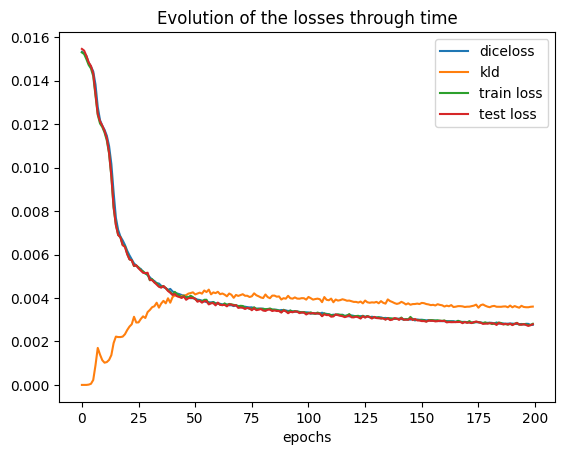

In [ ]:
plt.plot(dice_losses, label = 'diceloss')
plt.plot(kld_losses, label='kld')
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.xlabel('epochs')
plt.title('Evolution of the losses through time')
plt.legend()
plt.show()

In [ ]:
#Influence du beta
z_dim = 32
n_classes = 5
n_epochs = 200

dice_losses=[]
kld_losses=[]
train_losses=[]
test_losses=[]
betas=[0.0001,0.001,0.01,0.1,1,2,5]

for beta in betas:
  print(beta)
  dice_losses_ex=[]
  kld_losses_ex=[]
  train_losses_ex=[]
  test_losses_ex=[]
  vae_model= VAE(z_dim, n_rows, n_col)
  vae_optimizer= optim.Adam(vae_model.parameters(), lr = 1e-4, weight_decay=0.001)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  vae_model.to(device)

  for epoch in range(0, n_epochs):
    diceloss, kld=train_vae(vae_model,train_loader, vae_optimizer, epoch, beta_=beta)
    dice_losses_ex.append(diceloss)
    kld_losses_ex.append(kld)
    train_losses_ex.append(diceloss_vae(vae_model,train_loader))
    test_losses_ex.append(diceloss_vae(vae_model,test_loader))

  dice_losses.append(dice_losses_ex)
  kld_losses.append(kld_losses_ex)
  train_losses.append(train_losses_ex)
  test_losses.append(test_losses_ex)



0.0001
rows and cols 80 80


30it [00:00, 40.21it/s]


====> Epoch: 0 Average loss: 3.0507


30it [00:00, 46.29it/s]


====> Epoch: 1 Average loss: 3.0429


30it [00:00, 46.59it/s]


====> Epoch: 2 Average loss: 3.0318


30it [00:00, 44.12it/s]


====> Epoch: 3 Average loss: 2.9103


30it [00:00, 42.90it/s]


====> Epoch: 4 Average loss: 2.6590


30it [00:00, 39.02it/s]


====> Epoch: 5 Average loss: 2.4847


30it [00:00, 38.94it/s]


====> Epoch: 6 Average loss: 2.3768


30it [00:00, 44.29it/s]


====> Epoch: 7 Average loss: 2.2188


30it [00:00, 45.33it/s]


====> Epoch: 8 Average loss: 1.9741


30it [00:00, 45.62it/s]


====> Epoch: 9 Average loss: 1.7109


30it [00:00, 47.72it/s]


====> Epoch: 10 Average loss: 1.4580


30it [00:00, 44.01it/s]


====> Epoch: 11 Average loss: 1.1548


30it [00:00, 43.42it/s]


====> Epoch: 12 Average loss: 0.8807


30it [00:00, 47.27it/s]


====> Epoch: 13 Average loss: 0.7652


30it [00:00, 45.91it/s]


====> Epoch: 14 Average loss: 0.7101


30it [00:00, 46.34it/s]


====> Epoch: 15 Average loss: 0.6602


30it [00:00, 46.67it/s]


====> Epoch: 16 Average loss: 0.6272


30it [00:00, 40.62it/s]


====> Epoch: 17 Average loss: 0.6010


30it [00:00, 40.24it/s]


====> Epoch: 18 Average loss: 0.5806


30it [00:00, 41.34it/s]


====> Epoch: 19 Average loss: 0.5690


30it [00:00, 44.10it/s]


====> Epoch: 20 Average loss: 0.5492


30it [00:00, 45.03it/s]


====> Epoch: 21 Average loss: 0.5363


30it [00:00, 46.59it/s]


====> Epoch: 22 Average loss: 0.5211


30it [00:00, 42.91it/s]


====> Epoch: 23 Average loss: 0.5161


30it [00:00, 44.69it/s]


====> Epoch: 24 Average loss: 0.5045


30it [00:00, 46.52it/s]


====> Epoch: 25 Average loss: 0.4989


30it [00:00, 46.62it/s]


====> Epoch: 26 Average loss: 0.4923


30it [00:00, 47.12it/s]


====> Epoch: 27 Average loss: 0.4853


30it [00:00, 44.13it/s]


====> Epoch: 28 Average loss: 0.4784


30it [00:00, 44.53it/s]


====> Epoch: 29 Average loss: 0.4753


30it [00:00, 39.54it/s]


====> Epoch: 30 Average loss: 0.4697


30it [00:00, 38.26it/s]


====> Epoch: 31 Average loss: 0.4625


30it [00:00, 41.92it/s]


====> Epoch: 32 Average loss: 0.4579


30it [00:00, 44.33it/s]


====> Epoch: 33 Average loss: 0.4523


30it [00:00, 43.13it/s]


====> Epoch: 34 Average loss: 0.4448


30it [00:00, 44.42it/s]


====> Epoch: 35 Average loss: 0.4429


30it [00:00, 44.81it/s]


====> Epoch: 36 Average loss: 0.4391


30it [00:00, 44.38it/s]


====> Epoch: 37 Average loss: 0.4296


30it [00:00, 44.49it/s]


====> Epoch: 38 Average loss: 0.4241


30it [00:00, 44.59it/s]


====> Epoch: 39 Average loss: 0.4199


30it [00:00, 46.39it/s]


====> Epoch: 40 Average loss: 0.4152


30it [00:00, 45.43it/s]


====> Epoch: 41 Average loss: 0.4072


30it [00:00, 44.52it/s]


====> Epoch: 42 Average loss: 0.4077


30it [00:00, 39.88it/s]


====> Epoch: 43 Average loss: 0.4003


30it [00:00, 43.98it/s]


====> Epoch: 44 Average loss: 0.3950


30it [00:00, 40.91it/s]


====> Epoch: 45 Average loss: 0.3903


30it [00:00, 44.42it/s]


====> Epoch: 46 Average loss: 0.3858


30it [00:00, 43.00it/s]


====> Epoch: 47 Average loss: 0.3822


30it [00:00, 44.89it/s]


====> Epoch: 48 Average loss: 0.3772


30it [00:00, 44.32it/s]


====> Epoch: 49 Average loss: 0.3741


30it [00:00, 44.11it/s]


====> Epoch: 50 Average loss: 0.3687


30it [00:00, 45.06it/s]


====> Epoch: 51 Average loss: 0.3654


30it [00:00, 47.35it/s]


====> Epoch: 52 Average loss: 0.3651


30it [00:00, 44.52it/s]


====> Epoch: 53 Average loss: 0.3598


30it [00:00, 45.31it/s]


====> Epoch: 54 Average loss: 0.3553


30it [00:00, 44.83it/s]


====> Epoch: 55 Average loss: 0.3508


30it [00:00, 40.08it/s]


====> Epoch: 56 Average loss: 0.3476


30it [00:00, 42.45it/s]


====> Epoch: 57 Average loss: 0.3449


30it [00:00, 40.38it/s]


====> Epoch: 58 Average loss: 0.3453


30it [00:00, 44.58it/s]


====> Epoch: 59 Average loss: 0.3418


30it [00:00, 45.86it/s]


====> Epoch: 60 Average loss: 0.3380


30it [00:00, 45.54it/s]


====> Epoch: 61 Average loss: 0.3400


30it [00:00, 45.33it/s]


====> Epoch: 62 Average loss: 0.3337


30it [00:00, 44.31it/s]


====> Epoch: 63 Average loss: 0.3332


30it [00:00, 43.16it/s]


====> Epoch: 64 Average loss: 0.3283


30it [00:00, 45.79it/s]


====> Epoch: 65 Average loss: 0.3266


30it [00:00, 45.61it/s]


====> Epoch: 66 Average loss: 0.3255


30it [00:00, 44.26it/s]


====> Epoch: 67 Average loss: 0.3258


30it [00:00, 48.16it/s]


====> Epoch: 68 Average loss: 0.3226


30it [00:00, 39.80it/s]


====> Epoch: 69 Average loss: 0.3221


30it [00:00, 44.06it/s]


====> Epoch: 70 Average loss: 0.3206


30it [00:00, 42.93it/s]


====> Epoch: 71 Average loss: 0.3220


30it [00:00, 47.79it/s]


====> Epoch: 72 Average loss: 0.3139


30it [00:00, 44.16it/s]


====> Epoch: 73 Average loss: 0.3144


30it [00:00, 45.32it/s]


====> Epoch: 74 Average loss: 0.3107


30it [00:00, 45.89it/s]


====> Epoch: 75 Average loss: 0.3108


30it [00:00, 46.60it/s]


====> Epoch: 76 Average loss: 0.3084


30it [00:00, 45.87it/s]


====> Epoch: 77 Average loss: 0.3078


30it [00:00, 43.84it/s]


====> Epoch: 78 Average loss: 0.3055


30it [00:00, 44.10it/s]


====> Epoch: 79 Average loss: 0.3058


30it [00:00, 45.34it/s]


====> Epoch: 80 Average loss: 0.3016


30it [00:00, 45.61it/s]


====> Epoch: 81 Average loss: 0.3033


30it [00:00, 40.54it/s]


====> Epoch: 82 Average loss: 0.3029


30it [00:00, 39.78it/s]


====> Epoch: 83 Average loss: 0.3001


30it [00:00, 41.62it/s]


====> Epoch: 84 Average loss: 0.2978


30it [00:00, 43.60it/s]


====> Epoch: 85 Average loss: 0.2964


30it [00:00, 46.39it/s]


====> Epoch: 86 Average loss: 0.2988


30it [00:00, 45.29it/s]


====> Epoch: 87 Average loss: 0.2947


30it [00:00, 45.37it/s]


====> Epoch: 88 Average loss: 0.2928


30it [00:00, 43.17it/s]


====> Epoch: 89 Average loss: 0.2910


30it [00:00, 45.92it/s]


====> Epoch: 90 Average loss: 0.2912


30it [00:00, 45.20it/s]


====> Epoch: 91 Average loss: 0.2898


30it [00:00, 45.42it/s]


====> Epoch: 92 Average loss: 0.2894


30it [00:00, 44.42it/s]


====> Epoch: 93 Average loss: 0.2891


30it [00:00, 45.96it/s]


====> Epoch: 94 Average loss: 0.2873


30it [00:00, 41.39it/s]


====> Epoch: 95 Average loss: 0.2875


30it [00:00, 40.55it/s]


====> Epoch: 96 Average loss: 0.2868


30it [00:00, 43.25it/s]


====> Epoch: 97 Average loss: 0.2854


30it [00:00, 44.20it/s]


====> Epoch: 98 Average loss: 0.2841


30it [00:00, 45.27it/s]


====> Epoch: 99 Average loss: 0.2847


30it [00:00, 46.98it/s]


====> Epoch: 100 Average loss: 0.2816


30it [00:00, 44.96it/s]


====> Epoch: 101 Average loss: 0.2798


30it [00:00, 44.50it/s]


====> Epoch: 102 Average loss: 0.2813


30it [00:00, 46.81it/s]


====> Epoch: 103 Average loss: 0.2787


30it [00:00, 43.67it/s]


====> Epoch: 104 Average loss: 0.2784


30it [00:00, 43.54it/s]


====> Epoch: 105 Average loss: 0.2772


30it [00:00, 45.18it/s]


====> Epoch: 106 Average loss: 0.2774


30it [00:00, 44.13it/s]


====> Epoch: 107 Average loss: 0.2765


30it [00:00, 41.58it/s]


====> Epoch: 108 Average loss: 0.2748


30it [00:00, 41.58it/s]


====> Epoch: 109 Average loss: 0.2749


30it [00:00, 38.85it/s]


====> Epoch: 110 Average loss: 0.2747


30it [00:00, 42.60it/s]


====> Epoch: 111 Average loss: 0.2727


30it [00:00, 44.17it/s]


====> Epoch: 112 Average loss: 0.2721


30it [00:00, 45.26it/s]


====> Epoch: 113 Average loss: 0.2700


30it [00:00, 44.77it/s]


====> Epoch: 114 Average loss: 0.2694


30it [00:00, 44.89it/s]


====> Epoch: 115 Average loss: 0.2689


30it [00:00, 45.55it/s]


====> Epoch: 116 Average loss: 0.2696


30it [00:00, 42.83it/s]


====> Epoch: 117 Average loss: 0.2698


30it [00:00, 43.82it/s]


====> Epoch: 118 Average loss: 0.2674


30it [00:00, 43.36it/s]


====> Epoch: 119 Average loss: 0.2693


30it [00:00, 44.12it/s]


====> Epoch: 120 Average loss: 0.2660


30it [00:00, 40.55it/s]


====> Epoch: 121 Average loss: 0.2675


30it [00:00, 42.38it/s]


====> Epoch: 122 Average loss: 0.2645


30it [00:00, 41.91it/s]


====> Epoch: 123 Average loss: 0.2632


30it [00:00, 46.16it/s]


====> Epoch: 124 Average loss: 0.2652


30it [00:00, 46.14it/s]


====> Epoch: 125 Average loss: 0.2626


30it [00:00, 43.53it/s]


====> Epoch: 126 Average loss: 0.2614


30it [00:00, 45.08it/s]


====> Epoch: 127 Average loss: 0.2611


30it [00:00, 43.58it/s]


====> Epoch: 128 Average loss: 0.2634


30it [00:00, 47.52it/s]


====> Epoch: 129 Average loss: 0.2627


30it [00:00, 44.76it/s]


====> Epoch: 130 Average loss: 0.2606


30it [00:00, 45.33it/s]


====> Epoch: 131 Average loss: 0.2594


30it [00:00, 45.83it/s]


====> Epoch: 132 Average loss: 0.2582


30it [00:00, 43.37it/s]


====> Epoch: 133 Average loss: 0.2570


30it [00:00, 41.26it/s]


====> Epoch: 134 Average loss: 0.2570


30it [00:00, 42.93it/s]


====> Epoch: 135 Average loss: 0.2556


30it [00:00, 43.14it/s]


====> Epoch: 136 Average loss: 0.2573


30it [00:00, 44.43it/s]


====> Epoch: 137 Average loss: 0.2552


30it [00:00, 46.47it/s]


====> Epoch: 138 Average loss: 0.2538


30it [00:00, 44.09it/s]


====> Epoch: 139 Average loss: 0.2537


30it [00:00, 45.27it/s]


====> Epoch: 140 Average loss: 0.2536


30it [00:00, 47.28it/s]


====> Epoch: 141 Average loss: 0.2540


30it [00:00, 45.69it/s]


====> Epoch: 142 Average loss: 0.2518


30it [00:00, 45.94it/s]


====> Epoch: 143 Average loss: 0.2512


30it [00:00, 43.87it/s]


====> Epoch: 144 Average loss: 0.2494


30it [00:00, 43.50it/s]


====> Epoch: 145 Average loss: 0.2526


30it [00:00, 44.66it/s]


====> Epoch: 146 Average loss: 0.2515


30it [00:00, 39.40it/s]


====> Epoch: 147 Average loss: 0.2490


30it [00:00, 42.12it/s]


====> Epoch: 148 Average loss: 0.2499


30it [00:00, 42.34it/s]


====> Epoch: 149 Average loss: 0.2497


30it [00:00, 43.42it/s]


====> Epoch: 150 Average loss: 0.2487


30it [00:00, 46.96it/s]


====> Epoch: 151 Average loss: 0.2477


30it [00:00, 43.85it/s]


====> Epoch: 152 Average loss: 0.2478


30it [00:00, 47.40it/s]


====> Epoch: 153 Average loss: 0.2469


30it [00:00, 44.41it/s]


====> Epoch: 154 Average loss: 0.2460


30it [00:00, 45.63it/s]


====> Epoch: 155 Average loss: 0.2468


30it [00:00, 43.79it/s]


====> Epoch: 156 Average loss: 0.2466


30it [00:00, 43.96it/s]


====> Epoch: 157 Average loss: 0.2463


30it [00:00, 45.16it/s]


====> Epoch: 158 Average loss: 0.2477


30it [00:00, 43.57it/s]


====> Epoch: 159 Average loss: 0.2441


30it [00:00, 39.26it/s]


====> Epoch: 160 Average loss: 0.2436


30it [00:00, 40.65it/s]


====> Epoch: 161 Average loss: 0.2436


30it [00:00, 40.35it/s]


====> Epoch: 162 Average loss: 0.2415


30it [00:00, 43.35it/s]


====> Epoch: 163 Average loss: 0.2428


30it [00:00, 43.62it/s]


====> Epoch: 164 Average loss: 0.2398


30it [00:00, 43.36it/s]


====> Epoch: 165 Average loss: 0.2412


30it [00:00, 45.52it/s]


====> Epoch: 166 Average loss: 0.2400


30it [00:00, 45.26it/s]


====> Epoch: 167 Average loss: 0.2399


30it [00:00, 43.76it/s]


====> Epoch: 168 Average loss: 0.2394


30it [00:00, 46.54it/s]


====> Epoch: 169 Average loss: 0.2429


30it [00:00, 43.71it/s]


====> Epoch: 170 Average loss: 0.2304


30it [00:00, 44.72it/s]


====> Epoch: 171 Average loss: 0.2293


30it [00:00, 44.87it/s]


====> Epoch: 172 Average loss: 0.2284


30it [00:00, 41.42it/s]


====> Epoch: 173 Average loss: 0.2259


30it [00:00, 40.72it/s]


====> Epoch: 174 Average loss: 0.2359


30it [00:00, 41.04it/s]


====> Epoch: 175 Average loss: 0.2410


30it [00:00, 43.66it/s]


====> Epoch: 176 Average loss: 0.2286


30it [00:00, 47.00it/s]


====> Epoch: 177 Average loss: 0.2261


30it [00:00, 44.97it/s]


====> Epoch: 178 Average loss: 0.2248


30it [00:00, 47.45it/s]


====> Epoch: 179 Average loss: 0.2249


30it [00:00, 44.02it/s]


====> Epoch: 180 Average loss: 0.2258


30it [00:00, 44.09it/s]


====> Epoch: 181 Average loss: 0.2243


30it [00:00, 45.16it/s]


====> Epoch: 182 Average loss: 0.2249


30it [00:00, 45.17it/s]


====> Epoch: 183 Average loss: 0.2235


30it [00:00, 45.46it/s]


====> Epoch: 184 Average loss: 0.2225


30it [00:00, 44.82it/s]


====> Epoch: 185 Average loss: 0.2238


30it [00:00, 40.64it/s]


====> Epoch: 186 Average loss: 0.2210


30it [00:00, 41.62it/s]


====> Epoch: 187 Average loss: 0.2219


30it [00:00, 40.27it/s]


====> Epoch: 188 Average loss: 0.2220


30it [00:00, 46.89it/s]


====> Epoch: 189 Average loss: 0.2205


30it [00:00, 45.65it/s]


====> Epoch: 190 Average loss: 0.2207


30it [00:00, 46.58it/s]


====> Epoch: 191 Average loss: 0.2196


30it [00:00, 46.43it/s]


====> Epoch: 192 Average loss: 0.2221


30it [00:00, 45.02it/s]


====> Epoch: 193 Average loss: 0.2194


30it [00:00, 46.16it/s]


====> Epoch: 194 Average loss: 0.2199


30it [00:00, 45.19it/s]


====> Epoch: 195 Average loss: 0.2185


30it [00:00, 43.75it/s]


====> Epoch: 196 Average loss: 0.2197


30it [00:00, 43.93it/s]


====> Epoch: 197 Average loss: 0.2180


30it [00:00, 46.16it/s]


====> Epoch: 198 Average loss: 0.2176


30it [00:00, 41.33it/s]


====> Epoch: 199 Average loss: 0.2192
0.001
rows and cols 80 80


30it [00:00, 41.57it/s]


====> Epoch: 0 Average loss: 3.0472


30it [00:00, 44.11it/s]


====> Epoch: 1 Average loss: 3.0375


30it [00:00, 46.93it/s]


====> Epoch: 2 Average loss: 3.0178


30it [00:00, 45.34it/s]


====> Epoch: 3 Average loss: 2.9130


30it [00:00, 45.33it/s]


====> Epoch: 4 Average loss: 2.6925


30it [00:00, 46.89it/s]


====> Epoch: 5 Average loss: 2.5255


30it [00:00, 43.86it/s]


====> Epoch: 6 Average loss: 2.4410


30it [00:00, 45.86it/s]


====> Epoch: 7 Average loss: 2.3900


30it [00:00, 47.34it/s]


====> Epoch: 8 Average loss: 2.3300


30it [00:00, 47.49it/s]


====> Epoch: 9 Average loss: 2.1997


30it [00:00, 45.77it/s]


====> Epoch: 10 Average loss: 2.0013


30it [00:00, 39.16it/s]


====> Epoch: 11 Average loss: 1.7760


30it [00:00, 40.19it/s]


====> Epoch: 12 Average loss: 1.4672


30it [00:00, 40.93it/s]


====> Epoch: 13 Average loss: 1.1037


30it [00:00, 44.81it/s]


====> Epoch: 14 Average loss: 0.9044


30it [00:00, 47.86it/s]


====> Epoch: 15 Average loss: 0.8087


30it [00:00, 47.24it/s]


====> Epoch: 16 Average loss: 0.7508


30it [00:00, 46.96it/s]


====> Epoch: 17 Average loss: 0.7114


30it [00:00, 45.32it/s]


====> Epoch: 18 Average loss: 0.6790


30it [00:00, 45.07it/s]


====> Epoch: 19 Average loss: 0.6568


30it [00:00, 46.87it/s]


====> Epoch: 20 Average loss: 0.6408


30it [00:00, 44.91it/s]


====> Epoch: 21 Average loss: 0.6283


30it [00:00, 46.95it/s]


====> Epoch: 22 Average loss: 0.6124


30it [00:00, 45.32it/s]


====> Epoch: 23 Average loss: 0.6025


30it [00:00, 40.94it/s]


====> Epoch: 24 Average loss: 0.5960


30it [00:00, 42.32it/s]


====> Epoch: 25 Average loss: 0.5822


30it [00:00, 46.68it/s]


====> Epoch: 26 Average loss: 0.5755


30it [00:00, 45.77it/s]


====> Epoch: 27 Average loss: 0.5666


30it [00:00, 45.18it/s]


====> Epoch: 28 Average loss: 0.5599


30it [00:00, 47.01it/s]


====> Epoch: 29 Average loss: 0.5543


30it [00:00, 45.00it/s]


====> Epoch: 30 Average loss: 0.5495


30it [00:00, 46.06it/s]


====> Epoch: 31 Average loss: 0.5393


30it [00:00, 44.74it/s]


====> Epoch: 32 Average loss: 0.5318


30it [00:00, 44.41it/s]


====> Epoch: 33 Average loss: 0.5280


30it [00:00, 44.25it/s]


====> Epoch: 34 Average loss: 0.5200


30it [00:00, 46.48it/s]


====> Epoch: 35 Average loss: 0.5115


30it [00:00, 42.83it/s]


====> Epoch: 36 Average loss: 0.5055


30it [00:00, 43.05it/s]


====> Epoch: 37 Average loss: 0.5009


30it [00:00, 42.93it/s]


====> Epoch: 38 Average loss: 0.4959


30it [00:00, 44.47it/s]


====> Epoch: 39 Average loss: 0.4899


30it [00:00, 45.36it/s]


====> Epoch: 40 Average loss: 0.4808


30it [00:00, 46.60it/s]


====> Epoch: 41 Average loss: 0.4797


30it [00:00, 45.59it/s]


====> Epoch: 42 Average loss: 0.4755


30it [00:00, 46.36it/s]


====> Epoch: 43 Average loss: 0.4714


30it [00:00, 44.89it/s]


====> Epoch: 44 Average loss: 0.4650


30it [00:00, 43.58it/s]


====> Epoch: 45 Average loss: 0.4612


30it [00:00, 42.98it/s]


====> Epoch: 46 Average loss: 0.4607


30it [00:00, 45.36it/s]


====> Epoch: 47 Average loss: 0.4553


30it [00:00, 44.87it/s]


====> Epoch: 48 Average loss: 0.4525


30it [00:00, 43.11it/s]


====> Epoch: 49 Average loss: 0.4490


30it [00:00, 40.88it/s]


====> Epoch: 50 Average loss: 0.4457


30it [00:00, 45.27it/s]


====> Epoch: 51 Average loss: 0.4437


30it [00:00, 44.96it/s]


====> Epoch: 52 Average loss: 0.4440


30it [00:00, 45.92it/s]


====> Epoch: 53 Average loss: 0.4390


30it [00:00, 47.40it/s]


====> Epoch: 54 Average loss: 0.4328


30it [00:00, 46.29it/s]


====> Epoch: 55 Average loss: 0.4319


30it [00:00, 47.49it/s]


====> Epoch: 56 Average loss: 0.4325


30it [00:00, 46.84it/s]


====> Epoch: 57 Average loss: 0.4264


30it [00:00, 45.32it/s]


====> Epoch: 58 Average loss: 0.4248


30it [00:00, 44.94it/s]


====> Epoch: 59 Average loss: 0.4236


30it [00:00, 44.99it/s]


====> Epoch: 60 Average loss: 0.4208


30it [00:00, 43.63it/s]


====> Epoch: 61 Average loss: 0.4181


30it [00:00, 44.50it/s]


====> Epoch: 62 Average loss: 0.4171


30it [00:00, 42.31it/s]


====> Epoch: 63 Average loss: 0.4161


30it [00:00, 45.12it/s]


====> Epoch: 64 Average loss: 0.4151


30it [00:00, 43.27it/s]


====> Epoch: 65 Average loss: 0.4102


30it [00:00, 43.48it/s]


====> Epoch: 66 Average loss: 0.4095


30it [00:00, 47.09it/s]


====> Epoch: 67 Average loss: 0.4099


30it [00:00, 45.12it/s]


====> Epoch: 68 Average loss: 0.4046


30it [00:00, 45.02it/s]


====> Epoch: 69 Average loss: 0.4039


30it [00:00, 45.48it/s]


====> Epoch: 70 Average loss: 0.4012


30it [00:00, 44.98it/s]


====> Epoch: 71 Average loss: 0.3994


30it [00:00, 46.89it/s]


====> Epoch: 72 Average loss: 0.3960


30it [00:00, 43.63it/s]


====> Epoch: 73 Average loss: 0.3959


30it [00:00, 42.86it/s]


====> Epoch: 74 Average loss: 0.3929


30it [00:00, 42.20it/s]


====> Epoch: 75 Average loss: 0.3945


30it [00:00, 44.94it/s]


====> Epoch: 76 Average loss: 0.3940


30it [00:00, 46.55it/s]


====> Epoch: 77 Average loss: 0.3926


30it [00:00, 45.01it/s]


====> Epoch: 78 Average loss: 0.3918


30it [00:00, 44.77it/s]


====> Epoch: 79 Average loss: 0.3916


30it [00:00, 45.03it/s]


====> Epoch: 80 Average loss: 0.3888


30it [00:00, 47.22it/s]


====> Epoch: 81 Average loss: 0.3869


30it [00:00, 45.46it/s]


====> Epoch: 82 Average loss: 0.3843


30it [00:00, 48.19it/s]


====> Epoch: 83 Average loss: 0.3842


30it [00:00, 44.83it/s]


====> Epoch: 84 Average loss: 0.3860


30it [00:00, 46.44it/s]


====> Epoch: 85 Average loss: 0.3828


30it [00:00, 41.21it/s]


====> Epoch: 86 Average loss: 0.3797


30it [00:00, 41.35it/s]


====> Epoch: 87 Average loss: 0.3760


30it [00:00, 44.49it/s]


====> Epoch: 88 Average loss: 0.3734


30it [00:00, 47.65it/s]


====> Epoch: 89 Average loss: 0.3764


30it [00:00, 47.17it/s]


====> Epoch: 90 Average loss: 0.3736


30it [00:00, 46.73it/s]


====> Epoch: 91 Average loss: 0.3705


30it [00:00, 44.01it/s]


====> Epoch: 92 Average loss: 0.3725


30it [00:00, 47.75it/s]


====> Epoch: 93 Average loss: 0.3692


30it [00:00, 44.97it/s]


====> Epoch: 94 Average loss: 0.3689


30it [00:00, 47.00it/s]


====> Epoch: 95 Average loss: 0.3679


30it [00:00, 46.58it/s]


====> Epoch: 96 Average loss: 0.3680


30it [00:00, 44.10it/s]


====> Epoch: 97 Average loss: 0.3670


30it [00:00, 42.57it/s]


====> Epoch: 98 Average loss: 0.3654


30it [00:00, 40.76it/s]


====> Epoch: 99 Average loss: 0.3635


30it [00:00, 40.88it/s]


====> Epoch: 100 Average loss: 0.3612


30it [00:00, 45.61it/s]


====> Epoch: 101 Average loss: 0.3614


30it [00:00, 44.85it/s]


====> Epoch: 102 Average loss: 0.3615


30it [00:00, 46.16it/s]


====> Epoch: 103 Average loss: 0.3625


30it [00:00, 47.05it/s]


====> Epoch: 104 Average loss: 0.3590


30it [00:00, 46.97it/s]


====> Epoch: 105 Average loss: 0.3610


30it [00:00, 44.55it/s]


====> Epoch: 106 Average loss: 0.3580


30it [00:00, 45.07it/s]


====> Epoch: 107 Average loss: 0.3590


30it [00:00, 42.52it/s]


====> Epoch: 108 Average loss: 0.3557


30it [00:00, 44.20it/s]


====> Epoch: 109 Average loss: 0.3565


30it [00:00, 44.93it/s]


====> Epoch: 110 Average loss: 0.3551


30it [00:00, 40.29it/s]


====> Epoch: 111 Average loss: 0.3507


30it [00:00, 40.31it/s]


====> Epoch: 112 Average loss: 0.3519


30it [00:00, 44.04it/s]


====> Epoch: 113 Average loss: 0.3588


30it [00:00, 46.82it/s]


====> Epoch: 114 Average loss: 0.3528


30it [00:00, 44.53it/s]


====> Epoch: 115 Average loss: 0.3511


30it [00:00, 46.87it/s]


====> Epoch: 116 Average loss: 0.3498


30it [00:00, 45.71it/s]


====> Epoch: 117 Average loss: 0.3488


30it [00:00, 43.23it/s]


====> Epoch: 118 Average loss: 0.3473


30it [00:00, 46.53it/s]


====> Epoch: 119 Average loss: 0.3477


30it [00:00, 46.53it/s]


====> Epoch: 120 Average loss: 0.3463


30it [00:00, 45.70it/s]


====> Epoch: 121 Average loss: 0.3447


30it [00:00, 46.97it/s]


====> Epoch: 122 Average loss: 0.3449


30it [00:00, 40.05it/s]


====> Epoch: 123 Average loss: 0.3462


30it [00:00, 42.46it/s]


====> Epoch: 124 Average loss: 0.3424


30it [00:00, 41.36it/s]


====> Epoch: 125 Average loss: 0.3442


30it [00:00, 46.69it/s]


====> Epoch: 126 Average loss: 0.3426


30it [00:00, 47.28it/s]


====> Epoch: 127 Average loss: 0.3429


30it [00:00, 43.52it/s]


====> Epoch: 128 Average loss: 0.3396


30it [00:00, 47.48it/s]


====> Epoch: 129 Average loss: 0.3395


30it [00:00, 47.03it/s]


====> Epoch: 130 Average loss: 0.3392


30it [00:00, 44.91it/s]


====> Epoch: 131 Average loss: 0.3405


30it [00:00, 47.52it/s]


====> Epoch: 132 Average loss: 0.3372


30it [00:00, 48.16it/s]


====> Epoch: 133 Average loss: 0.3365


30it [00:00, 45.14it/s]


====> Epoch: 134 Average loss: 0.3395


30it [00:00, 44.38it/s]


====> Epoch: 135 Average loss: 0.3370


30it [00:00, 44.08it/s]


====> Epoch: 136 Average loss: 0.3354


30it [00:00, 40.84it/s]


====> Epoch: 137 Average loss: 0.3368


30it [00:00, 43.74it/s]


====> Epoch: 138 Average loss: 0.3353


30it [00:00, 45.47it/s]


====> Epoch: 139 Average loss: 0.3341


30it [00:00, 45.56it/s]


====> Epoch: 140 Average loss: 0.3351


30it [00:00, 47.27it/s]


====> Epoch: 141 Average loss: 0.3314


30it [00:00, 44.39it/s]


====> Epoch: 142 Average loss: 0.3340


30it [00:00, 47.44it/s]


====> Epoch: 143 Average loss: 0.3348


30it [00:00, 43.07it/s]


====> Epoch: 144 Average loss: 0.3321


30it [00:00, 44.71it/s]


====> Epoch: 145 Average loss: 0.3310


30it [00:00, 44.74it/s]


====> Epoch: 146 Average loss: 0.3302


30it [00:00, 45.25it/s]


====> Epoch: 147 Average loss: 0.3303


30it [00:00, 38.49it/s]


====> Epoch: 148 Average loss: 0.3298


30it [00:00, 39.79it/s]


====> Epoch: 149 Average loss: 0.3294


30it [00:00, 43.15it/s]


====> Epoch: 150 Average loss: 0.3292


30it [00:00, 46.45it/s]


====> Epoch: 151 Average loss: 0.3284


30it [00:00, 44.66it/s]


====> Epoch: 152 Average loss: 0.3287


30it [00:00, 44.88it/s]


====> Epoch: 153 Average loss: 0.3376


30it [00:00, 46.10it/s]


====> Epoch: 154 Average loss: 0.3335


30it [00:00, 42.75it/s]


====> Epoch: 155 Average loss: 0.3395


30it [00:00, 43.01it/s]


====> Epoch: 156 Average loss: 0.3505


30it [00:00, 44.29it/s]


====> Epoch: 157 Average loss: 0.3333


30it [00:00, 44.26it/s]


====> Epoch: 158 Average loss: 0.3251


30it [00:00, 44.50it/s]


====> Epoch: 159 Average loss: 0.3273


30it [00:00, 41.06it/s]


====> Epoch: 160 Average loss: 0.3195


30it [00:00, 40.17it/s]


====> Epoch: 161 Average loss: 0.3166


30it [00:00, 39.99it/s]


====> Epoch: 162 Average loss: 0.3173


30it [00:00, 46.80it/s]


====> Epoch: 163 Average loss: 0.3133


30it [00:00, 43.02it/s]


====> Epoch: 164 Average loss: 0.3157


30it [00:00, 44.61it/s]


====> Epoch: 165 Average loss: 0.3140


30it [00:00, 46.43it/s]


====> Epoch: 166 Average loss: 0.3190


30it [00:00, 44.46it/s]


====> Epoch: 167 Average loss: 0.3107


30it [00:00, 46.26it/s]


====> Epoch: 168 Average loss: 0.3106


30it [00:00, 47.89it/s]


====> Epoch: 169 Average loss: 0.3094


30it [00:00, 45.03it/s]


====> Epoch: 170 Average loss: 0.3121


30it [00:00, 46.57it/s]


====> Epoch: 171 Average loss: 0.3103


30it [00:00, 44.62it/s]


====> Epoch: 172 Average loss: 0.3087


30it [00:00, 38.71it/s]


====> Epoch: 173 Average loss: 0.3088


30it [00:00, 42.39it/s]


====> Epoch: 174 Average loss: 0.3107


30it [00:00, 44.81it/s]


====> Epoch: 175 Average loss: 0.3068


30it [00:00, 46.61it/s]


====> Epoch: 176 Average loss: 0.3080


30it [00:00, 47.12it/s]


====> Epoch: 177 Average loss: 0.3087


30it [00:00, 44.87it/s]


====> Epoch: 178 Average loss: 0.3062


30it [00:00, 47.27it/s]


====> Epoch: 179 Average loss: 0.3061


30it [00:00, 46.96it/s]


====> Epoch: 180 Average loss: 0.3183


30it [00:00, 46.93it/s]


====> Epoch: 181 Average loss: 0.3220


30it [00:00, 46.40it/s]


====> Epoch: 182 Average loss: 0.3060


30it [00:00, 43.93it/s]


====> Epoch: 183 Average loss: 0.3058


30it [00:00, 44.64it/s]


====> Epoch: 184 Average loss: 0.3032


30it [00:00, 41.02it/s]


====> Epoch: 185 Average loss: 0.3025


30it [00:00, 41.30it/s]


====> Epoch: 186 Average loss: 0.3020


30it [00:00, 43.06it/s]


====> Epoch: 187 Average loss: 0.3061


30it [00:00, 44.67it/s]


====> Epoch: 188 Average loss: 0.3041


30it [00:00, 44.69it/s]


====> Epoch: 189 Average loss: 0.3056


30it [00:00, 45.55it/s]


====> Epoch: 190 Average loss: 0.3027


30it [00:00, 44.85it/s]


====> Epoch: 191 Average loss: 0.3031


30it [00:00, 47.40it/s]


====> Epoch: 192 Average loss: 0.3034


30it [00:00, 47.10it/s]


====> Epoch: 193 Average loss: 0.3012


30it [00:00, 44.91it/s]


====> Epoch: 194 Average loss: 0.3008


30it [00:00, 44.52it/s]


====> Epoch: 195 Average loss: 0.3079


30it [00:00, 44.69it/s]


====> Epoch: 196 Average loss: 0.3043


30it [00:00, 41.82it/s]


====> Epoch: 197 Average loss: 0.3006


30it [00:00, 40.05it/s]


====> Epoch: 198 Average loss: 0.2997


30it [00:00, 39.75it/s]


====> Epoch: 199 Average loss: 0.2977
0.01
rows and cols 80 80


30it [00:00, 44.95it/s]


====> Epoch: 0 Average loss: 3.0548


30it [00:00, 43.73it/s]


====> Epoch: 1 Average loss: 3.0439


30it [00:00, 45.12it/s]


====> Epoch: 2 Average loss: 3.0244


30it [00:00, 45.24it/s]


====> Epoch: 3 Average loss: 2.9730


30it [00:00, 44.84it/s]


====> Epoch: 4 Average loss: 2.9178


30it [00:00, 46.57it/s]


====> Epoch: 5 Average loss: 2.7745


30it [00:00, 44.61it/s]


====> Epoch: 6 Average loss: 2.5883


30it [00:00, 46.92it/s]


====> Epoch: 7 Average loss: 2.4896


30it [00:00, 46.94it/s]


====> Epoch: 8 Average loss: 2.4410


30it [00:00, 42.86it/s]


====> Epoch: 9 Average loss: 2.4073


30it [00:00, 41.87it/s]


====> Epoch: 10 Average loss: 2.3686


30it [00:00, 40.51it/s]


====> Epoch: 11 Average loss: 2.3012


30it [00:00, 44.82it/s]


====> Epoch: 12 Average loss: 2.1943


30it [00:00, 46.45it/s]


====> Epoch: 13 Average loss: 2.0156


30it [00:00, 44.47it/s]


====> Epoch: 14 Average loss: 1.7299


30it [00:00, 43.14it/s]


====> Epoch: 15 Average loss: 1.4821


30it [00:00, 44.62it/s]


====> Epoch: 16 Average loss: 1.3941


30it [00:00, 46.87it/s]


====> Epoch: 17 Average loss: 1.3698


30it [00:00, 44.26it/s]


====> Epoch: 18 Average loss: 1.3475


30it [00:00, 42.77it/s]


====> Epoch: 19 Average loss: 1.3369


30it [00:00, 42.86it/s]


====> Epoch: 20 Average loss: 1.3141


30it [00:00, 46.89it/s]


====> Epoch: 21 Average loss: 1.2947


30it [00:00, 41.41it/s]


====> Epoch: 22 Average loss: 1.2670


30it [00:00, 40.60it/s]


====> Epoch: 23 Average loss: 1.2467


30it [00:00, 42.89it/s]


====> Epoch: 24 Average loss: 1.2175


30it [00:00, 47.16it/s]


====> Epoch: 25 Average loss: 1.1830


30it [00:00, 44.98it/s]


====> Epoch: 26 Average loss: 1.1499


30it [00:00, 45.15it/s]


====> Epoch: 27 Average loss: 1.1260


30it [00:00, 47.69it/s]


====> Epoch: 28 Average loss: 1.1079


30it [00:00, 46.46it/s]


====> Epoch: 29 Average loss: 1.0862


30it [00:00, 45.14it/s]


====> Epoch: 30 Average loss: 1.0678


30it [00:00, 46.72it/s]


====> Epoch: 31 Average loss: 1.0602


30it [00:00, 43.79it/s]


====> Epoch: 32 Average loss: 1.0180


30it [00:00, 46.15it/s]


====> Epoch: 33 Average loss: 0.9918


30it [00:00, 39.88it/s]


====> Epoch: 34 Average loss: 0.9737


30it [00:00, 42.50it/s]


====> Epoch: 35 Average loss: 0.9440


30it [00:00, 40.36it/s]


====> Epoch: 36 Average loss: 0.9293


30it [00:00, 47.29it/s]


====> Epoch: 37 Average loss: 0.9169


30it [00:00, 44.64it/s]


====> Epoch: 38 Average loss: 0.8847


30it [00:00, 45.55it/s]


====> Epoch: 39 Average loss: 0.8849


30it [00:00, 42.73it/s]


====> Epoch: 40 Average loss: 0.8727


30it [00:00, 46.67it/s]


====> Epoch: 41 Average loss: 0.8586


30it [00:00, 47.33it/s]


====> Epoch: 42 Average loss: 0.8431


30it [00:00, 47.35it/s]


====> Epoch: 43 Average loss: 0.8374


30it [00:00, 43.03it/s]


====> Epoch: 44 Average loss: 0.8325


30it [00:00, 47.27it/s]


====> Epoch: 45 Average loss: 0.8254


30it [00:00, 46.10it/s]


====> Epoch: 46 Average loss: 0.8176


30it [00:00, 39.99it/s]


====> Epoch: 47 Average loss: 0.8159


30it [00:00, 40.46it/s]


====> Epoch: 48 Average loss: 0.8087


30it [00:00, 45.25it/s]


====> Epoch: 49 Average loss: 0.7994


30it [00:00, 44.39it/s]


====> Epoch: 50 Average loss: 0.8023


30it [00:00, 46.49it/s]


====> Epoch: 51 Average loss: 0.7934


30it [00:00, 48.06it/s]


====> Epoch: 52 Average loss: 0.7896


30it [00:00, 46.87it/s]


====> Epoch: 53 Average loss: 0.7830


30it [00:00, 47.43it/s]


====> Epoch: 54 Average loss: 0.7832


30it [00:00, 47.88it/s]


====> Epoch: 55 Average loss: 0.7747


30it [00:00, 44.57it/s]


====> Epoch: 56 Average loss: 0.7750


30it [00:00, 44.80it/s]


====> Epoch: 57 Average loss: 0.7708


30it [00:00, 44.86it/s]


====> Epoch: 58 Average loss: 0.7685


30it [00:00, 42.00it/s]


====> Epoch: 59 Average loss: 0.7647


30it [00:00, 40.16it/s]


====> Epoch: 60 Average loss: 0.7670


30it [00:00, 42.02it/s]


====> Epoch: 61 Average loss: 0.7533


30it [00:00, 48.03it/s]


====> Epoch: 62 Average loss: 0.7501


30it [00:00, 43.38it/s]


====> Epoch: 63 Average loss: 0.7466


30it [00:00, 47.15it/s]


====> Epoch: 64 Average loss: 0.7490


30it [00:00, 44.94it/s]


====> Epoch: 65 Average loss: 0.7522


30it [00:00, 47.64it/s]


====> Epoch: 66 Average loss: 0.7498


30it [00:00, 45.26it/s]


====> Epoch: 67 Average loss: 0.7444


30it [00:00, 44.21it/s]


====> Epoch: 68 Average loss: 0.7386


30it [00:00, 46.64it/s]


====> Epoch: 69 Average loss: 0.7334


30it [00:00, 44.70it/s]


====> Epoch: 70 Average loss: 0.7345


30it [00:00, 42.90it/s]


====> Epoch: 71 Average loss: 0.7321


30it [00:00, 40.06it/s]


====> Epoch: 72 Average loss: 0.7276


30it [00:00, 41.35it/s]


====> Epoch: 73 Average loss: 0.7285


30it [00:00, 42.70it/s]


====> Epoch: 74 Average loss: 0.7274


30it [00:00, 45.00it/s]


====> Epoch: 75 Average loss: 0.7186


30it [00:00, 42.33it/s]


====> Epoch: 76 Average loss: 0.7197


30it [00:00, 46.33it/s]


====> Epoch: 77 Average loss: 0.7137


30it [00:00, 44.10it/s]


====> Epoch: 78 Average loss: 0.7193


30it [00:00, 44.34it/s]


====> Epoch: 79 Average loss: 0.7113


30it [00:00, 42.50it/s]


====> Epoch: 80 Average loss: 0.7103


30it [00:00, 42.58it/s]


====> Epoch: 81 Average loss: 0.7050


30it [00:00, 44.49it/s]


====> Epoch: 82 Average loss: 0.7066


30it [00:00, 45.50it/s]


====> Epoch: 83 Average loss: 0.6985


30it [00:00, 40.40it/s]


====> Epoch: 84 Average loss: 0.7050


30it [00:00, 42.96it/s]


====> Epoch: 85 Average loss: 0.6984


30it [00:00, 47.91it/s]


====> Epoch: 86 Average loss: 0.6985


30it [00:00, 47.92it/s]


====> Epoch: 87 Average loss: 0.6902


30it [00:00, 48.01it/s]


====> Epoch: 88 Average loss: 0.6937


30it [00:00, 44.72it/s]


====> Epoch: 89 Average loss: 0.6918


30it [00:00, 42.92it/s]


====> Epoch: 90 Average loss: 0.6962


30it [00:00, 43.03it/s]


====> Epoch: 91 Average loss: 0.6906


30it [00:00, 46.96it/s]


====> Epoch: 92 Average loss: 0.6878


30it [00:00, 48.44it/s]


====> Epoch: 93 Average loss: 0.6873


30it [00:00, 45.08it/s]


====> Epoch: 94 Average loss: 0.6812


30it [00:00, 43.81it/s]


====> Epoch: 95 Average loss: 0.6878


30it [00:00, 38.97it/s]


====> Epoch: 96 Average loss: 0.6819


30it [00:00, 43.31it/s]


====> Epoch: 97 Average loss: 0.6806


30it [00:00, 40.75it/s]


====> Epoch: 98 Average loss: 0.6788


30it [00:00, 47.56it/s]


====> Epoch: 99 Average loss: 0.6808


30it [00:00, 43.11it/s]


====> Epoch: 100 Average loss: 0.6726


30it [00:00, 47.63it/s]


====> Epoch: 101 Average loss: 0.6747


30it [00:00, 45.70it/s]


====> Epoch: 102 Average loss: 0.6749


30it [00:00, 44.39it/s]


====> Epoch: 103 Average loss: 0.6679


30it [00:00, 44.93it/s]


====> Epoch: 104 Average loss: 0.6698


30it [00:00, 46.98it/s]


====> Epoch: 105 Average loss: 0.6660


30it [00:00, 47.28it/s]


====> Epoch: 106 Average loss: 0.6666


30it [00:00, 44.43it/s]


====> Epoch: 107 Average loss: 0.6667


30it [00:00, 43.47it/s]


====> Epoch: 108 Average loss: 0.6656


30it [00:00, 40.38it/s]


====> Epoch: 109 Average loss: 0.6609


30it [00:00, 38.25it/s]


====> Epoch: 110 Average loss: 0.6591


30it [00:00, 47.07it/s]


====> Epoch: 111 Average loss: 0.6594


30it [00:00, 43.14it/s]


====> Epoch: 112 Average loss: 0.6570


30it [00:00, 43.01it/s]


====> Epoch: 113 Average loss: 0.6565


30it [00:00, 44.43it/s]


====> Epoch: 114 Average loss: 0.6502


30it [00:00, 45.06it/s]


====> Epoch: 115 Average loss: 0.6547


30it [00:00, 45.02it/s]


====> Epoch: 116 Average loss: 0.6544


30it [00:00, 43.12it/s]


====> Epoch: 117 Average loss: 0.6507


30it [00:00, 45.00it/s]


====> Epoch: 118 Average loss: 0.6487


30it [00:00, 44.73it/s]


====> Epoch: 119 Average loss: 0.6487


30it [00:00, 44.51it/s]


====> Epoch: 120 Average loss: 0.6471


30it [00:00, 41.01it/s]


====> Epoch: 121 Average loss: 0.6440


30it [00:00, 41.55it/s]


====> Epoch: 122 Average loss: 0.6420


30it [00:00, 44.99it/s]


====> Epoch: 123 Average loss: 0.6424


30it [00:00, 45.03it/s]


====> Epoch: 124 Average loss: 0.6331


30it [00:00, 44.66it/s]


====> Epoch: 125 Average loss: 0.6369


30it [00:00, 45.35it/s]


====> Epoch: 126 Average loss: 0.6364


30it [00:00, 45.49it/s]


====> Epoch: 127 Average loss: 0.6329


30it [00:00, 43.92it/s]


====> Epoch: 128 Average loss: 0.6318


30it [00:00, 46.84it/s]


====> Epoch: 129 Average loss: 0.6345


30it [00:00, 45.27it/s]


====> Epoch: 130 Average loss: 0.6309


30it [00:00, 48.62it/s]


====> Epoch: 131 Average loss: 0.6310


30it [00:00, 43.43it/s]


====> Epoch: 132 Average loss: 0.6277


30it [00:00, 42.38it/s]


====> Epoch: 133 Average loss: 0.6226


30it [00:00, 40.57it/s]


====> Epoch: 134 Average loss: 0.6285


30it [00:00, 42.92it/s]


====> Epoch: 135 Average loss: 0.6308


30it [00:00, 44.90it/s]


====> Epoch: 136 Average loss: 0.6283


30it [00:00, 45.10it/s]


====> Epoch: 137 Average loss: 0.6244


30it [00:00, 45.21it/s]


====> Epoch: 138 Average loss: 0.6208


30it [00:00, 46.45it/s]


====> Epoch: 139 Average loss: 0.6227


30it [00:00, 45.41it/s]


====> Epoch: 140 Average loss: 0.6192


30it [00:00, 45.29it/s]


====> Epoch: 141 Average loss: 0.6159


30it [00:00, 42.62it/s]


====> Epoch: 142 Average loss: 0.6189


30it [00:00, 47.21it/s]


====> Epoch: 143 Average loss: 0.6183


30it [00:00, 45.44it/s]


====> Epoch: 144 Average loss: 0.6173


30it [00:00, 43.91it/s]


====> Epoch: 145 Average loss: 0.6124


30it [00:00, 40.38it/s]


====> Epoch: 146 Average loss: 0.6138


30it [00:00, 40.21it/s]


====> Epoch: 147 Average loss: 0.6107


30it [00:00, 44.92it/s]


====> Epoch: 148 Average loss: 0.6130


30it [00:00, 44.24it/s]


====> Epoch: 149 Average loss: 0.6115


30it [00:00, 45.43it/s]


====> Epoch: 150 Average loss: 0.6107


30it [00:00, 45.54it/s]


====> Epoch: 151 Average loss: 0.6090


30it [00:00, 45.06it/s]


====> Epoch: 152 Average loss: 0.6065


30it [00:00, 45.85it/s]


====> Epoch: 153 Average loss: 0.6062


30it [00:00, 43.61it/s]


====> Epoch: 154 Average loss: 0.6070


30it [00:00, 45.13it/s]


====> Epoch: 155 Average loss: 0.6006


30it [00:00, 44.74it/s]


====> Epoch: 156 Average loss: 0.6061


30it [00:00, 43.76it/s]


====> Epoch: 157 Average loss: 0.6005


30it [00:00, 40.48it/s]


====> Epoch: 158 Average loss: 0.6016


30it [00:00, 39.60it/s]


====> Epoch: 159 Average loss: 0.6028


30it [00:00, 45.31it/s]


====> Epoch: 160 Average loss: 0.5992


30it [00:00, 44.51it/s]


====> Epoch: 161 Average loss: 0.6012


30it [00:00, 43.29it/s]


====> Epoch: 162 Average loss: 0.6006


30it [00:00, 46.79it/s]


====> Epoch: 163 Average loss: 0.5950


30it [00:00, 46.17it/s]


====> Epoch: 164 Average loss: 0.5945


30it [00:00, 44.14it/s]


====> Epoch: 165 Average loss: 0.5927


30it [00:00, 45.02it/s]


====> Epoch: 166 Average loss: 0.5958


30it [00:00, 44.69it/s]


====> Epoch: 167 Average loss: 0.5918


30it [00:00, 45.68it/s]


====> Epoch: 168 Average loss: 0.5917


30it [00:00, 46.03it/s]


====> Epoch: 169 Average loss: 0.5957


30it [00:00, 41.63it/s]


====> Epoch: 170 Average loss: 0.5896


30it [00:00, 41.04it/s]


====> Epoch: 171 Average loss: 0.5888


30it [00:00, 42.32it/s]


====> Epoch: 172 Average loss: 0.5872


30it [00:00, 47.36it/s]


====> Epoch: 173 Average loss: 0.5907


30it [00:00, 45.66it/s]


====> Epoch: 174 Average loss: 0.5873


30it [00:00, 44.73it/s]


====> Epoch: 175 Average loss: 0.5858


30it [00:00, 44.32it/s]


====> Epoch: 176 Average loss: 0.5893


30it [00:00, 44.21it/s]


====> Epoch: 177 Average loss: 0.5836


30it [00:00, 47.43it/s]


====> Epoch: 178 Average loss: 0.5868


30it [00:00, 45.19it/s]


====> Epoch: 179 Average loss: 0.5836


30it [00:00, 44.90it/s]


====> Epoch: 180 Average loss: 0.5802


30it [00:00, 46.83it/s]


====> Epoch: 181 Average loss: 0.5816


30it [00:00, 43.38it/s]


====> Epoch: 182 Average loss: 0.5857


30it [00:00, 40.53it/s]


====> Epoch: 183 Average loss: 0.5814


30it [00:00, 41.45it/s]


====> Epoch: 184 Average loss: 0.5816


30it [00:00, 45.20it/s]


====> Epoch: 185 Average loss: 0.5824


30it [00:00, 47.41it/s]


====> Epoch: 186 Average loss: 0.5812


30it [00:00, 44.80it/s]


====> Epoch: 187 Average loss: 0.5767


30it [00:00, 43.88it/s]


====> Epoch: 188 Average loss: 0.5768


30it [00:00, 44.72it/s]


====> Epoch: 189 Average loss: 0.5765


30it [00:00, 44.12it/s]


====> Epoch: 190 Average loss: 0.5720


30it [00:00, 47.61it/s]


====> Epoch: 191 Average loss: 0.5750


30it [00:00, 44.23it/s]


====> Epoch: 192 Average loss: 0.5753


30it [00:00, 45.45it/s]


====> Epoch: 193 Average loss: 0.5731


30it [00:00, 44.14it/s]


====> Epoch: 194 Average loss: 0.5749


30it [00:00, 42.36it/s]


====> Epoch: 195 Average loss: 0.5719


30it [00:00, 39.92it/s]


====> Epoch: 196 Average loss: 0.5698


30it [00:00, 44.04it/s]


====> Epoch: 197 Average loss: 0.5708


30it [00:00, 45.41it/s]


====> Epoch: 198 Average loss: 0.5723


30it [00:00, 45.39it/s]


====> Epoch: 199 Average loss: 0.5724
0.1
rows and cols 80 80


30it [00:00, 45.99it/s]


====> Epoch: 0 Average loss: 3.0845


30it [00:00, 47.70it/s]


====> Epoch: 1 Average loss: 3.0745


30it [00:00, 44.68it/s]


====> Epoch: 2 Average loss: 3.0445


30it [00:00, 44.94it/s]


====> Epoch: 3 Average loss: 2.9663


30it [00:00, 43.60it/s]


====> Epoch: 4 Average loss: 2.9322


30it [00:00, 48.14it/s]


====> Epoch: 5 Average loss: 2.9038


30it [00:00, 44.56it/s]


====> Epoch: 6 Average loss: 2.8634


30it [00:00, 38.10it/s]


====> Epoch: 7 Average loss: 2.7967


30it [00:00, 41.15it/s]


====> Epoch: 8 Average loss: 2.6799


30it [00:00, 42.31it/s]


====> Epoch: 9 Average loss: 2.5335


30it [00:00, 47.60it/s]


====> Epoch: 10 Average loss: 2.4528


30it [00:00, 45.67it/s]


====> Epoch: 11 Average loss: 2.4066


30it [00:00, 47.55it/s]


====> Epoch: 12 Average loss: 2.3764


30it [00:00, 44.58it/s]


====> Epoch: 13 Average loss: 2.3431


30it [00:00, 46.18it/s]


====> Epoch: 14 Average loss: 2.2910


30it [00:00, 47.26it/s]


====> Epoch: 15 Average loss: 2.2033


30it [00:00, 45.70it/s]


====> Epoch: 16 Average loss: 2.0798


30it [00:00, 42.85it/s]


====> Epoch: 17 Average loss: 1.8997


30it [00:00, 46.46it/s]


====> Epoch: 18 Average loss: 1.6688


30it [00:00, 45.76it/s]


====> Epoch: 19 Average loss: 1.5325


30it [00:00, 41.23it/s]


====> Epoch: 20 Average loss: 1.4539


30it [00:00, 43.56it/s]


====> Epoch: 21 Average loss: 1.4121


30it [00:00, 43.95it/s]


====> Epoch: 22 Average loss: 1.3738


30it [00:00, 45.08it/s]


====> Epoch: 23 Average loss: 1.3604


30it [00:00, 44.94it/s]


====> Epoch: 24 Average loss: 1.3329


30it [00:00, 46.11it/s]


====> Epoch: 25 Average loss: 1.3113


30it [00:00, 46.62it/s]


====> Epoch: 26 Average loss: 1.2985


30it [00:00, 44.69it/s]


====> Epoch: 27 Average loss: 1.2786


30it [00:00, 44.08it/s]


====> Epoch: 28 Average loss: 1.2709


30it [00:00, 46.79it/s]


====> Epoch: 29 Average loss: 1.2594


30it [00:00, 46.50it/s]


====> Epoch: 30 Average loss: 1.2533


30it [00:00, 47.08it/s]


====> Epoch: 31 Average loss: 1.2519


30it [00:00, 41.73it/s]


====> Epoch: 32 Average loss: 1.2366


30it [00:00, 39.96it/s]


====> Epoch: 33 Average loss: 1.2364


30it [00:00, 40.16it/s]


====> Epoch: 34 Average loss: 1.2242


30it [00:00, 47.27it/s]


====> Epoch: 35 Average loss: 1.2198


30it [00:00, 45.37it/s]


====> Epoch: 36 Average loss: 1.2190


30it [00:00, 45.19it/s]


====> Epoch: 37 Average loss: 1.2092


30it [00:00, 46.90it/s]


====> Epoch: 38 Average loss: 1.2045


30it [00:00, 43.13it/s]


====> Epoch: 39 Average loss: 1.2062


30it [00:00, 45.06it/s]


====> Epoch: 40 Average loss: 1.1947


30it [00:00, 45.42it/s]


====> Epoch: 41 Average loss: 1.1899


30it [00:00, 46.73it/s]


====> Epoch: 42 Average loss: 1.1875


30it [00:00, 43.53it/s]


====> Epoch: 43 Average loss: 1.1827


30it [00:00, 41.49it/s]


====> Epoch: 44 Average loss: 1.1809


30it [00:00, 40.12it/s]


====> Epoch: 45 Average loss: 1.1793


30it [00:00, 43.70it/s]


====> Epoch: 46 Average loss: 1.1766


30it [00:00, 43.38it/s]


====> Epoch: 47 Average loss: 1.1696


30it [00:00, 42.52it/s]


====> Epoch: 48 Average loss: 1.1657


30it [00:00, 44.83it/s]


====> Epoch: 49 Average loss: 1.1719


30it [00:00, 45.03it/s]


====> Epoch: 50 Average loss: 1.1709


30it [00:00, 45.03it/s]


====> Epoch: 51 Average loss: 1.1605


30it [00:00, 44.71it/s]


====> Epoch: 52 Average loss: 1.1618


30it [00:00, 46.03it/s]


====> Epoch: 53 Average loss: 1.1579


30it [00:00, 45.34it/s]


====> Epoch: 54 Average loss: 1.1554


30it [00:00, 46.11it/s]


====> Epoch: 55 Average loss: 1.1478


30it [00:00, 46.61it/s]


====> Epoch: 56 Average loss: 1.1491


30it [00:00, 43.89it/s]


====> Epoch: 57 Average loss: 1.1536


30it [00:00, 39.10it/s]


====> Epoch: 58 Average loss: 1.1525


30it [00:00, 42.45it/s]


====> Epoch: 59 Average loss: 1.1474


30it [00:00, 45.61it/s]


====> Epoch: 60 Average loss: 1.1418


30it [00:00, 43.60it/s]


====> Epoch: 61 Average loss: 1.1458


30it [00:00, 47.13it/s]


====> Epoch: 62 Average loss: 1.1386


30it [00:00, 42.96it/s]


====> Epoch: 63 Average loss: 1.1404


30it [00:00, 43.06it/s]


====> Epoch: 64 Average loss: 1.1409


30it [00:00, 44.77it/s]


====> Epoch: 65 Average loss: 1.1466


30it [00:00, 43.23it/s]


====> Epoch: 66 Average loss: 1.1363


30it [00:00, 47.13it/s]


====> Epoch: 67 Average loss: 1.1280


30it [00:00, 45.69it/s]


====> Epoch: 68 Average loss: 1.1323


30it [00:00, 46.89it/s]


====> Epoch: 69 Average loss: 1.1263


30it [00:00, 42.69it/s]


====> Epoch: 70 Average loss: 1.1278


30it [00:00, 40.63it/s]


====> Epoch: 71 Average loss: 1.1331


30it [00:00, 41.92it/s]


====> Epoch: 72 Average loss: 1.1207


30it [00:00, 43.95it/s]


====> Epoch: 73 Average loss: 1.1239


30it [00:00, 44.83it/s]


====> Epoch: 74 Average loss: 1.1201


30it [00:00, 44.42it/s]


====> Epoch: 75 Average loss: 1.1135


30it [00:00, 43.42it/s]


====> Epoch: 76 Average loss: 1.1237


30it [00:00, 45.47it/s]


====> Epoch: 77 Average loss: 1.1211


30it [00:00, 45.00it/s]


====> Epoch: 78 Average loss: 1.1124


30it [00:00, 46.29it/s]


====> Epoch: 79 Average loss: 1.1135


30it [00:00, 43.44it/s]


====> Epoch: 80 Average loss: 1.1198


30it [00:00, 45.61it/s]


====> Epoch: 81 Average loss: 1.1181


30it [00:00, 40.16it/s]


====> Epoch: 82 Average loss: 1.1083


30it [00:00, 42.49it/s]


====> Epoch: 83 Average loss: 1.1065


30it [00:00, 42.09it/s]


====> Epoch: 84 Average loss: 1.1084


30it [00:00, 45.94it/s]


====> Epoch: 85 Average loss: 1.1132


30it [00:00, 45.82it/s]


====> Epoch: 86 Average loss: 1.1170


30it [00:00, 44.50it/s]


====> Epoch: 87 Average loss: 1.1091


30it [00:00, 45.01it/s]


====> Epoch: 88 Average loss: 1.1084


30it [00:00, 46.68it/s]


====> Epoch: 89 Average loss: 1.1079


30it [00:00, 42.65it/s]


====> Epoch: 90 Average loss: 1.1015


30it [00:00, 46.92it/s]


====> Epoch: 91 Average loss: 1.1092


30it [00:00, 44.29it/s]


====> Epoch: 92 Average loss: 1.1069


30it [00:00, 43.33it/s]


====> Epoch: 93 Average loss: 1.1097


30it [00:00, 44.08it/s]


====> Epoch: 94 Average loss: 1.1030


30it [00:00, 43.15it/s]


====> Epoch: 95 Average loss: 1.1002


30it [00:00, 41.07it/s]


====> Epoch: 96 Average loss: 1.0941


30it [00:00, 43.36it/s]


====> Epoch: 97 Average loss: 1.1002


30it [00:00, 44.31it/s]


====> Epoch: 98 Average loss: 1.0916


30it [00:00, 46.48it/s]


====> Epoch: 99 Average loss: 1.0962


30it [00:00, 46.71it/s]


====> Epoch: 100 Average loss: 1.1003


30it [00:00, 44.61it/s]


====> Epoch: 101 Average loss: 1.0975


30it [00:00, 44.12it/s]


====> Epoch: 102 Average loss: 1.0994


30it [00:00, 44.29it/s]


====> Epoch: 103 Average loss: 1.0896


30it [00:00, 45.85it/s]


====> Epoch: 104 Average loss: 1.0932


30it [00:00, 45.50it/s]


====> Epoch: 105 Average loss: 1.0971


30it [00:00, 46.22it/s]


====> Epoch: 106 Average loss: 1.1000


30it [00:00, 42.93it/s]


====> Epoch: 107 Average loss: 1.0947


30it [00:00, 41.91it/s]


====> Epoch: 108 Average loss: 1.0953


30it [00:00, 39.04it/s]


====> Epoch: 109 Average loss: 1.0892


30it [00:00, 44.28it/s]


====> Epoch: 110 Average loss: 1.0869


30it [00:00, 45.27it/s]


====> Epoch: 111 Average loss: 1.0891


30it [00:00, 44.85it/s]


====> Epoch: 112 Average loss: 1.0881


30it [00:00, 43.74it/s]


====> Epoch: 113 Average loss: 1.0956


30it [00:00, 44.35it/s]


====> Epoch: 114 Average loss: 1.0839


30it [00:00, 46.39it/s]


====> Epoch: 115 Average loss: 1.0888


30it [00:00, 46.70it/s]


====> Epoch: 116 Average loss: 1.0815


30it [00:00, 45.05it/s]


====> Epoch: 117 Average loss: 1.0874


30it [00:00, 46.83it/s]


====> Epoch: 118 Average loss: 1.0852


30it [00:00, 43.74it/s]


====> Epoch: 119 Average loss: 1.0822


30it [00:00, 40.06it/s]


====> Epoch: 120 Average loss: 1.0771


30it [00:00, 40.13it/s]


====> Epoch: 121 Average loss: 1.0861


30it [00:00, 44.95it/s]


====> Epoch: 122 Average loss: 1.0819


30it [00:00, 44.98it/s]


====> Epoch: 123 Average loss: 1.0763


30it [00:00, 44.62it/s]


====> Epoch: 124 Average loss: 1.0864


30it [00:00, 44.06it/s]


====> Epoch: 125 Average loss: 1.0652


30it [00:00, 42.70it/s]


====> Epoch: 126 Average loss: 1.0772


30it [00:00, 45.05it/s]


====> Epoch: 127 Average loss: 1.0768


30it [00:00, 44.47it/s]


====> Epoch: 128 Average loss: 1.0714


30it [00:00, 47.42it/s]


====> Epoch: 129 Average loss: 1.0649


30it [00:00, 45.62it/s]


====> Epoch: 130 Average loss: 1.0716


30it [00:00, 43.32it/s]


====> Epoch: 131 Average loss: 1.0709


30it [00:00, 39.79it/s]


====> Epoch: 132 Average loss: 1.0747


30it [00:00, 38.41it/s]


====> Epoch: 133 Average loss: 1.0773


30it [00:00, 43.13it/s]


====> Epoch: 134 Average loss: 1.0740


30it [00:00, 46.23it/s]


====> Epoch: 135 Average loss: 1.0641


30it [00:00, 46.62it/s]


====> Epoch: 136 Average loss: 1.0758


30it [00:00, 46.47it/s]


====> Epoch: 137 Average loss: 1.0788


30it [00:00, 44.49it/s]


====> Epoch: 138 Average loss: 1.0693


30it [00:00, 44.31it/s]


====> Epoch: 139 Average loss: 1.0607


30it [00:00, 44.98it/s]


====> Epoch: 140 Average loss: 1.0701


30it [00:00, 46.73it/s]


====> Epoch: 141 Average loss: 1.0686


30it [00:00, 44.19it/s]


====> Epoch: 142 Average loss: 1.0620


30it [00:00, 44.91it/s]


====> Epoch: 143 Average loss: 1.0601


30it [00:00, 38.36it/s]


====> Epoch: 144 Average loss: 1.0632


30it [00:00, 40.61it/s]


====> Epoch: 145 Average loss: 1.0590


30it [00:00, 41.88it/s]


====> Epoch: 146 Average loss: 1.0676


30it [00:00, 43.05it/s]


====> Epoch: 147 Average loss: 1.0555


30it [00:00, 48.51it/s]


====> Epoch: 148 Average loss: 1.0624


30it [00:00, 46.96it/s]


====> Epoch: 149 Average loss: 1.0599


30it [00:00, 46.50it/s]


====> Epoch: 150 Average loss: 1.0563


30it [00:00, 42.58it/s]


====> Epoch: 151 Average loss: 1.0632


30it [00:00, 44.01it/s]


====> Epoch: 152 Average loss: 1.0637


30it [00:00, 46.58it/s]


====> Epoch: 153 Average loss: 1.0522


30it [00:00, 43.35it/s]


====> Epoch: 154 Average loss: 1.0560


30it [00:00, 42.96it/s]


====> Epoch: 155 Average loss: 1.0549


30it [00:00, 41.10it/s]


====> Epoch: 156 Average loss: 1.0537


30it [00:00, 41.72it/s]


====> Epoch: 157 Average loss: 1.0515


30it [00:00, 41.61it/s]


====> Epoch: 158 Average loss: 1.0508


30it [00:00, 44.51it/s]


====> Epoch: 159 Average loss: 1.0463


30it [00:00, 44.09it/s]


====> Epoch: 160 Average loss: 1.0429


30it [00:00, 46.52it/s]


====> Epoch: 161 Average loss: 1.0394


30it [00:00, 42.05it/s]


====> Epoch: 162 Average loss: 1.0449


30it [00:00, 44.71it/s]


====> Epoch: 163 Average loss: 1.0502


30it [00:00, 46.30it/s]


====> Epoch: 164 Average loss: 1.0441


30it [00:00, 44.39it/s]


====> Epoch: 165 Average loss: 1.0554


30it [00:00, 45.67it/s]


====> Epoch: 166 Average loss: 1.0489


30it [00:00, 44.41it/s]


====> Epoch: 167 Average loss: 1.0400


30it [00:00, 44.89it/s]


====> Epoch: 168 Average loss: 1.0445


30it [00:00, 42.50it/s]


====> Epoch: 169 Average loss: 1.0437


30it [00:00, 37.86it/s]


====> Epoch: 170 Average loss: 1.0396


30it [00:00, 40.31it/s]


====> Epoch: 171 Average loss: 1.0405


30it [00:00, 45.59it/s]


====> Epoch: 172 Average loss: 1.0402


30it [00:00, 43.68it/s]


====> Epoch: 173 Average loss: 1.0428


30it [00:00, 45.07it/s]


====> Epoch: 174 Average loss: 1.0406


30it [00:00, 45.81it/s]


====> Epoch: 175 Average loss: 1.0345


30it [00:00, 46.27it/s]


====> Epoch: 176 Average loss: 1.0310


30it [00:00, 45.26it/s]


====> Epoch: 177 Average loss: 1.0279


30it [00:00, 46.75it/s]


====> Epoch: 178 Average loss: 1.0418


30it [00:00, 47.39it/s]


====> Epoch: 179 Average loss: 1.0313


30it [00:00, 45.35it/s]


====> Epoch: 180 Average loss: 1.0418


30it [00:00, 44.83it/s]


====> Epoch: 181 Average loss: 1.0351


30it [00:00, 42.17it/s]


====> Epoch: 182 Average loss: 1.0378


30it [00:00, 40.64it/s]


====> Epoch: 183 Average loss: 1.0280


30it [00:00, 46.89it/s]


====> Epoch: 184 Average loss: 1.0394


30it [00:00, 43.50it/s]


====> Epoch: 185 Average loss: 1.0276


30it [00:00, 46.47it/s]


====> Epoch: 186 Average loss: 1.0245


30it [00:00, 47.53it/s]


====> Epoch: 187 Average loss: 1.0300


30it [00:00, 45.87it/s]


====> Epoch: 188 Average loss: 1.0276


30it [00:00, 47.26it/s]


====> Epoch: 189 Average loss: 1.0275


30it [00:00, 46.41it/s]


====> Epoch: 190 Average loss: 1.0233


30it [00:00, 44.71it/s]


====> Epoch: 191 Average loss: 1.0203


30it [00:00, 47.82it/s]


====> Epoch: 192 Average loss: 1.0186


30it [00:00, 46.68it/s]


====> Epoch: 193 Average loss: 1.0235


30it [00:00, 38.77it/s]


====> Epoch: 194 Average loss: 1.0187


30it [00:00, 43.14it/s]


====> Epoch: 195 Average loss: 1.0153


30it [00:00, 43.49it/s]


====> Epoch: 196 Average loss: 1.0234


30it [00:00, 44.63it/s]


====> Epoch: 197 Average loss: 1.0263


30it [00:00, 48.46it/s]


====> Epoch: 198 Average loss: 1.0233


30it [00:00, 42.97it/s]


====> Epoch: 199 Average loss: 1.0192
1
rows and cols 80 80


30it [00:00, 47.81it/s]


====> Epoch: 0 Average loss: 3.0561


30it [00:00, 46.82it/s]


====> Epoch: 1 Average loss: 3.0418


30it [00:00, 45.64it/s]


====> Epoch: 2 Average loss: 3.0110


30it [00:00, 45.48it/s]


====> Epoch: 3 Average loss: 2.9589


30it [00:00, 46.42it/s]


====> Epoch: 4 Average loss: 2.9360


30it [00:00, 47.38it/s]


====> Epoch: 5 Average loss: 2.9082


30it [00:00, 47.99it/s]


====> Epoch: 6 Average loss: 2.8612


30it [00:00, 38.00it/s]


====> Epoch: 7 Average loss: 2.7673


30it [00:00, 40.90it/s]


====> Epoch: 8 Average loss: 2.6285


30it [00:00, 43.72it/s]


====> Epoch: 9 Average loss: 2.5093


30it [00:00, 46.49it/s]


====> Epoch: 10 Average loss: 2.4326


30it [00:00, 45.49it/s]


====> Epoch: 11 Average loss: 2.3919


30it [00:00, 44.74it/s]


====> Epoch: 12 Average loss: 2.3599


30it [00:00, 45.93it/s]


====> Epoch: 13 Average loss: 2.3237


30it [00:00, 48.18it/s]


====> Epoch: 14 Average loss: 2.2693


30it [00:00, 43.43it/s]


====> Epoch: 15 Average loss: 2.1661


30it [00:00, 43.15it/s]


====> Epoch: 16 Average loss: 2.0077


30it [00:00, 45.18it/s]


====> Epoch: 17 Average loss: 1.7940


30it [00:00, 42.65it/s]


====> Epoch: 18 Average loss: 1.6269


30it [00:00, 41.04it/s]


====> Epoch: 19 Average loss: 1.5328


30it [00:00, 42.58it/s]


====> Epoch: 20 Average loss: 1.4734


30it [00:00, 39.00it/s]


====> Epoch: 21 Average loss: 1.4393


30it [00:00, 48.32it/s]


====> Epoch: 22 Average loss: 1.4074


30it [00:00, 45.40it/s]


====> Epoch: 23 Average loss: 1.3829


30it [00:00, 46.65it/s]


====> Epoch: 24 Average loss: 1.3712


30it [00:00, 44.43it/s]


====> Epoch: 25 Average loss: 1.3421


30it [00:00, 47.58it/s]


====> Epoch: 26 Average loss: 1.3325


30it [00:00, 46.05it/s]


====> Epoch: 27 Average loss: 1.3243


30it [00:00, 44.66it/s]


====> Epoch: 28 Average loss: 1.3092


30it [00:00, 45.15it/s]


====> Epoch: 29 Average loss: 1.2987


30it [00:00, 43.08it/s]


====> Epoch: 30 Average loss: 1.2955


30it [00:00, 45.65it/s]


====> Epoch: 31 Average loss: 1.2885


30it [00:00, 42.38it/s]


====> Epoch: 32 Average loss: 1.2803


30it [00:00, 38.78it/s]


====> Epoch: 33 Average loss: 1.2839


30it [00:00, 46.33it/s]


====> Epoch: 34 Average loss: 1.2697


30it [00:00, 47.89it/s]


====> Epoch: 35 Average loss: 1.2702


30it [00:00, 45.74it/s]


====> Epoch: 36 Average loss: 1.2551


30it [00:00, 47.45it/s]


====> Epoch: 37 Average loss: 1.2586


30it [00:00, 45.22it/s]


====> Epoch: 38 Average loss: 1.2591


30it [00:00, 45.35it/s]


====> Epoch: 39 Average loss: 1.2520


30it [00:00, 43.56it/s]


====> Epoch: 40 Average loss: 1.2452


30it [00:00, 45.63it/s]


====> Epoch: 41 Average loss: 1.2420


30it [00:00, 44.80it/s]


====> Epoch: 42 Average loss: 1.2261


30it [00:00, 45.52it/s]


====> Epoch: 43 Average loss: 1.2432


30it [00:00, 42.71it/s]


====> Epoch: 44 Average loss: 1.2290


30it [00:00, 42.74it/s]


====> Epoch: 45 Average loss: 1.2310


30it [00:00, 38.15it/s]


====> Epoch: 46 Average loss: 1.2239


30it [00:00, 43.50it/s]


====> Epoch: 47 Average loss: 1.2209


30it [00:00, 44.85it/s]


====> Epoch: 48 Average loss: 1.2234


30it [00:00, 46.11it/s]


====> Epoch: 49 Average loss: 1.2155


30it [00:00, 47.20it/s]


====> Epoch: 50 Average loss: 1.2150


30it [00:00, 44.03it/s]


====> Epoch: 51 Average loss: 1.2080


30it [00:00, 44.62it/s]


====> Epoch: 52 Average loss: 1.2093


30it [00:00, 45.28it/s]


====> Epoch: 53 Average loss: 1.2077


30it [00:00, 45.07it/s]


====> Epoch: 54 Average loss: 1.2052


30it [00:00, 44.83it/s]


====> Epoch: 55 Average loss: 1.2077


30it [00:00, 42.89it/s]


====> Epoch: 56 Average loss: 1.1987


30it [00:00, 38.84it/s]


====> Epoch: 57 Average loss: 1.1961


30it [00:00, 42.88it/s]


====> Epoch: 58 Average loss: 1.1977


30it [00:00, 43.70it/s]


====> Epoch: 59 Average loss: 1.1999


30it [00:00, 45.36it/s]


====> Epoch: 60 Average loss: 1.1995


30it [00:00, 46.06it/s]


====> Epoch: 61 Average loss: 1.1940


30it [00:00, 47.59it/s]


====> Epoch: 62 Average loss: 1.1933


30it [00:00, 45.09it/s]


====> Epoch: 63 Average loss: 1.1894


30it [00:00, 45.76it/s]


====> Epoch: 64 Average loss: 1.1946


30it [00:00, 45.70it/s]


====> Epoch: 65 Average loss: 1.1957


30it [00:00, 44.15it/s]


====> Epoch: 66 Average loss: 1.1921


30it [00:00, 43.27it/s]


====> Epoch: 67 Average loss: 1.1902


30it [00:00, 45.42it/s]


====> Epoch: 68 Average loss: 1.1836


30it [00:00, 41.34it/s]


====> Epoch: 69 Average loss: 1.1851


30it [00:00, 41.77it/s]


====> Epoch: 70 Average loss: 1.1866


30it [00:00, 42.56it/s]


====> Epoch: 71 Average loss: 1.1885


30it [00:00, 48.64it/s]


====> Epoch: 72 Average loss: 1.1866


30it [00:00, 43.61it/s]


====> Epoch: 73 Average loss: 1.1817


30it [00:00, 45.20it/s]


====> Epoch: 74 Average loss: 1.1830


30it [00:00, 47.74it/s]


====> Epoch: 75 Average loss: 1.1848


30it [00:00, 43.55it/s]


====> Epoch: 76 Average loss: 1.1810


30it [00:00, 47.65it/s]


====> Epoch: 77 Average loss: 1.1854


30it [00:00, 47.43it/s]


====> Epoch: 78 Average loss: 1.1837


30it [00:00, 45.11it/s]


====> Epoch: 79 Average loss: 1.1771


30it [00:00, 44.61it/s]


====> Epoch: 80 Average loss: 1.1856


30it [00:00, 44.81it/s]


====> Epoch: 81 Average loss: 1.1788


30it [00:00, 41.77it/s]


====> Epoch: 82 Average loss: 1.1825


30it [00:00, 37.83it/s]


====> Epoch: 83 Average loss: 1.1826


30it [00:00, 43.39it/s]


====> Epoch: 84 Average loss: 1.1784


30it [00:00, 47.37it/s]


====> Epoch: 85 Average loss: 1.1787


30it [00:00, 44.73it/s]


====> Epoch: 86 Average loss: 1.1805


30it [00:00, 45.57it/s]


====> Epoch: 87 Average loss: 1.1711


30it [00:00, 44.50it/s]


====> Epoch: 88 Average loss: 1.1748


30it [00:00, 45.52it/s]


====> Epoch: 89 Average loss: 1.1757


30it [00:00, 43.50it/s]


====> Epoch: 90 Average loss: 1.1775


30it [00:00, 44.63it/s]


====> Epoch: 91 Average loss: 1.1785


30it [00:00, 45.47it/s]


====> Epoch: 92 Average loss: 1.1788


30it [00:00, 48.08it/s]


====> Epoch: 93 Average loss: 1.1661


30it [00:00, 38.80it/s]


====> Epoch: 94 Average loss: 1.1729


30it [00:00, 42.32it/s]


====> Epoch: 95 Average loss: 1.1706


30it [00:00, 44.10it/s]


====> Epoch: 96 Average loss: 1.1731


30it [00:00, 43.90it/s]


====> Epoch: 97 Average loss: 1.1686


30it [00:00, 48.08it/s]


====> Epoch: 98 Average loss: 1.1751


30it [00:00, 43.74it/s]


====> Epoch: 99 Average loss: 1.1705


30it [00:00, 46.81it/s]


====> Epoch: 100 Average loss: 1.1774


30it [00:00, 46.74it/s]


====> Epoch: 101 Average loss: 1.1694


30it [00:00, 48.00it/s]


====> Epoch: 102 Average loss: 1.1692


30it [00:00, 48.23it/s]


====> Epoch: 103 Average loss: 1.1687


30it [00:00, 43.61it/s]


====> Epoch: 104 Average loss: 1.1715


30it [00:00, 48.08it/s]


====> Epoch: 105 Average loss: 1.1758


30it [00:00, 41.92it/s]


====> Epoch: 106 Average loss: 1.1707


30it [00:00, 41.49it/s]


====> Epoch: 107 Average loss: 1.1672


30it [00:00, 43.06it/s]


====> Epoch: 108 Average loss: 1.1699


30it [00:00, 45.12it/s]


====> Epoch: 109 Average loss: 1.1669


30it [00:00, 43.46it/s]


====> Epoch: 110 Average loss: 1.1688


30it [00:00, 44.57it/s]


====> Epoch: 111 Average loss: 1.1647


30it [00:00, 45.10it/s]


====> Epoch: 112 Average loss: 1.1664


30it [00:00, 45.61it/s]


====> Epoch: 113 Average loss: 1.1667


30it [00:00, 42.94it/s]


====> Epoch: 114 Average loss: 1.1677


30it [00:00, 47.67it/s]


====> Epoch: 115 Average loss: 1.1655


30it [00:00, 43.87it/s]


====> Epoch: 116 Average loss: 1.1652


30it [00:00, 44.22it/s]


====> Epoch: 117 Average loss: 1.1643


30it [00:00, 44.41it/s]


====> Epoch: 118 Average loss: 1.1673


30it [00:00, 40.01it/s]


====> Epoch: 119 Average loss: 1.1713


30it [00:00, 41.67it/s]


====> Epoch: 120 Average loss: 1.1641


30it [00:00, 43.00it/s]


====> Epoch: 121 Average loss: 1.1672


30it [00:00, 48.35it/s]


====> Epoch: 122 Average loss: 1.1639


30it [00:00, 42.81it/s]


====> Epoch: 123 Average loss: 1.1613


30it [00:00, 44.94it/s]


====> Epoch: 124 Average loss: 1.1652


30it [00:00, 47.51it/s]


====> Epoch: 125 Average loss: 1.1643


30it [00:00, 45.68it/s]


====> Epoch: 126 Average loss: 1.1651


30it [00:00, 48.36it/s]


====> Epoch: 127 Average loss: 1.1671


30it [00:00, 45.52it/s]


====> Epoch: 128 Average loss: 1.1694


30it [00:00, 43.34it/s]


====> Epoch: 129 Average loss: 1.1655


30it [00:00, 43.52it/s]


====> Epoch: 130 Average loss: 1.1639


30it [00:00, 43.55it/s]


====> Epoch: 131 Average loss: 1.1643


30it [00:00, 39.29it/s]


====> Epoch: 132 Average loss: 1.1639


30it [00:00, 42.43it/s]


====> Epoch: 133 Average loss: 1.1604


30it [00:00, 43.64it/s]


====> Epoch: 134 Average loss: 1.1631


30it [00:00, 42.92it/s]


====> Epoch: 135 Average loss: 1.1661


30it [00:00, 47.49it/s]


====> Epoch: 136 Average loss: 1.1601


30it [00:00, 45.26it/s]


====> Epoch: 137 Average loss: 1.1681


30it [00:00, 45.39it/s]


====> Epoch: 138 Average loss: 1.1653


30it [00:00, 43.65it/s]


====> Epoch: 139 Average loss: 1.1650


30it [00:00, 43.69it/s]


====> Epoch: 140 Average loss: 1.1615


30it [00:00, 43.81it/s]


====> Epoch: 141 Average loss: 1.1652


30it [00:00, 44.64it/s]


====> Epoch: 142 Average loss: 1.1593


30it [00:00, 45.35it/s]


====> Epoch: 143 Average loss: 1.1628


30it [00:00, 42.97it/s]


====> Epoch: 144 Average loss: 1.1630


30it [00:00, 43.45it/s]


====> Epoch: 145 Average loss: 1.1587


30it [00:00, 45.98it/s]


====> Epoch: 146 Average loss: 1.1642


30it [00:00, 46.62it/s]


====> Epoch: 147 Average loss: 1.1579


30it [00:00, 45.20it/s]


====> Epoch: 148 Average loss: 1.1621


30it [00:00, 43.75it/s]


====> Epoch: 149 Average loss: 1.1660


30it [00:00, 47.34it/s]


====> Epoch: 150 Average loss: 1.1568


30it [00:00, 47.81it/s]


====> Epoch: 151 Average loss: 1.1601


30it [00:00, 44.14it/s]


====> Epoch: 152 Average loss: 1.1608


30it [00:00, 45.01it/s]


====> Epoch: 153 Average loss: 1.1583


30it [00:00, 45.68it/s]


====> Epoch: 154 Average loss: 1.1612


30it [00:00, 46.78it/s]


====> Epoch: 155 Average loss: 1.1625


30it [00:00, 41.10it/s]


====> Epoch: 156 Average loss: 1.1601


30it [00:00, 38.93it/s]


====> Epoch: 157 Average loss: 1.1595


30it [00:00, 39.23it/s]


====> Epoch: 158 Average loss: 1.1586


30it [00:00, 44.71it/s]


====> Epoch: 159 Average loss: 1.1569


30it [00:00, 44.63it/s]


====> Epoch: 160 Average loss: 1.1648


30it [00:00, 44.64it/s]


====> Epoch: 161 Average loss: 1.1568


30it [00:00, 43.77it/s]


====> Epoch: 162 Average loss: 1.1587


30it [00:00, 47.76it/s]


====> Epoch: 163 Average loss: 1.1611


30it [00:00, 44.18it/s]


====> Epoch: 164 Average loss: 1.1580


30it [00:00, 46.48it/s]


====> Epoch: 165 Average loss: 1.1605


30it [00:00, 48.77it/s]


====> Epoch: 166 Average loss: 1.1614


30it [00:00, 44.46it/s]


====> Epoch: 167 Average loss: 1.1592


30it [00:00, 48.63it/s]


====> Epoch: 168 Average loss: 1.1590


30it [00:00, 38.00it/s]


====> Epoch: 169 Average loss: 1.1538


30it [00:00, 41.99it/s]


====> Epoch: 170 Average loss: 1.1577


30it [00:00, 44.78it/s]


====> Epoch: 171 Average loss: 1.1562


30it [00:00, 46.64it/s]


====> Epoch: 172 Average loss: 1.1577


30it [00:00, 44.94it/s]


====> Epoch: 173 Average loss: 1.1608


30it [00:00, 46.25it/s]


====> Epoch: 174 Average loss: 1.1569


30it [00:00, 46.82it/s]


====> Epoch: 175 Average loss: 1.1578


30it [00:00, 45.07it/s]


====> Epoch: 176 Average loss: 1.1600


30it [00:00, 45.60it/s]


====> Epoch: 177 Average loss: 1.1580


30it [00:00, 44.70it/s]


====> Epoch: 178 Average loss: 1.1614


30it [00:00, 48.18it/s]


====> Epoch: 179 Average loss: 1.1605


30it [00:00, 44.54it/s]


====> Epoch: 180 Average loss: 1.1583


30it [00:00, 41.46it/s]


====> Epoch: 181 Average loss: 1.1607


30it [00:00, 42.60it/s]


====> Epoch: 182 Average loss: 1.1576


30it [00:00, 37.93it/s]


====> Epoch: 183 Average loss: 1.1572


30it [00:00, 45.57it/s]


====> Epoch: 184 Average loss: 1.1551


30it [00:00, 46.89it/s]


====> Epoch: 185 Average loss: 1.1620


30it [00:00, 48.58it/s]


====> Epoch: 186 Average loss: 1.1593


30it [00:00, 47.73it/s]


====> Epoch: 187 Average loss: 1.1585


30it [00:00, 47.54it/s]


====> Epoch: 188 Average loss: 1.1591


30it [00:00, 45.31it/s]


====> Epoch: 189 Average loss: 1.1565


30it [00:00, 48.37it/s]


====> Epoch: 190 Average loss: 1.1563


30it [00:00, 45.41it/s]


====> Epoch: 191 Average loss: 1.1567


30it [00:00, 46.13it/s]


====> Epoch: 192 Average loss: 1.1584


30it [00:00, 45.82it/s]


====> Epoch: 193 Average loss: 1.1583


30it [00:00, 39.98it/s]


====> Epoch: 194 Average loss: 1.1568


30it [00:00, 42.09it/s]


====> Epoch: 195 Average loss: 1.1604


30it [00:00, 42.34it/s]


====> Epoch: 196 Average loss: 1.1570


30it [00:00, 44.91it/s]


====> Epoch: 197 Average loss: 1.1517


30it [00:00, 43.22it/s]


====> Epoch: 198 Average loss: 1.1565


30it [00:00, 43.52it/s]


====> Epoch: 199 Average loss: 1.1601
2
rows and cols 80 80


30it [00:00, 48.38it/s]


====> Epoch: 0 Average loss: 3.0419


30it [00:00, 48.08it/s]


====> Epoch: 1 Average loss: 3.0322


30it [00:00, 48.29it/s]


====> Epoch: 2 Average loss: 3.0061


30it [00:00, 47.66it/s]


====> Epoch: 3 Average loss: 2.9583


30it [00:00, 47.88it/s]


====> Epoch: 4 Average loss: 2.9392


30it [00:00, 47.93it/s]


====> Epoch: 5 Average loss: 2.9163


30it [00:00, 46.26it/s]


====> Epoch: 6 Average loss: 2.8809


30it [00:00, 42.96it/s]


====> Epoch: 7 Average loss: 2.8185


30it [00:00, 42.58it/s]


====> Epoch: 8 Average loss: 2.7048


30it [00:00, 44.10it/s]


====> Epoch: 9 Average loss: 2.5648


30it [00:00, 48.49it/s]


====> Epoch: 10 Average loss: 2.4715


30it [00:00, 47.09it/s]


====> Epoch: 11 Average loss: 2.4182


30it [00:00, 47.45it/s]


====> Epoch: 12 Average loss: 2.3821


30it [00:00, 46.97it/s]


====> Epoch: 13 Average loss: 2.3351


30it [00:00, 46.89it/s]


====> Epoch: 14 Average loss: 2.2520


30it [00:00, 47.38it/s]


====> Epoch: 15 Average loss: 2.1112


30it [00:00, 46.92it/s]


====> Epoch: 16 Average loss: 1.9306


30it [00:00, 47.30it/s]


====> Epoch: 17 Average loss: 1.7189


30it [00:00, 46.50it/s]


====> Epoch: 18 Average loss: 1.5706


30it [00:00, 45.30it/s]


====> Epoch: 19 Average loss: 1.4943


30it [00:00, 42.84it/s]


====> Epoch: 20 Average loss: 1.4478


30it [00:00, 42.39it/s]


====> Epoch: 21 Average loss: 1.4071


30it [00:00, 43.14it/s]


====> Epoch: 22 Average loss: 1.3902


30it [00:00, 47.85it/s]


====> Epoch: 23 Average loss: 1.3553


30it [00:00, 47.83it/s]


====> Epoch: 24 Average loss: 1.3334


30it [00:00, 47.62it/s]


====> Epoch: 25 Average loss: 1.3188


30it [00:00, 48.33it/s]


====> Epoch: 26 Average loss: 1.3148


30it [00:00, 46.99it/s]


====> Epoch: 27 Average loss: 1.2988


30it [00:00, 47.72it/s]


====> Epoch: 28 Average loss: 1.2888


30it [00:00, 47.41it/s]


====> Epoch: 29 Average loss: 1.2852


30it [00:00, 48.00it/s]


====> Epoch: 30 Average loss: 1.2705


30it [00:00, 47.47it/s]


====> Epoch: 31 Average loss: 1.2703


30it [00:00, 47.12it/s]


====> Epoch: 32 Average loss: 1.2571


30it [00:00, 42.41it/s]


====> Epoch: 33 Average loss: 1.2466


30it [00:00, 42.78it/s]


====> Epoch: 34 Average loss: 1.2452


30it [00:00, 42.73it/s]


====> Epoch: 35 Average loss: 1.2493


30it [00:00, 47.02it/s]


====> Epoch: 36 Average loss: 1.2346


30it [00:00, 47.34it/s]


====> Epoch: 37 Average loss: 1.2374


30it [00:00, 46.96it/s]


====> Epoch: 38 Average loss: 1.2309


30it [00:00, 46.81it/s]


====> Epoch: 39 Average loss: 1.2321


30it [00:00, 46.96it/s]


====> Epoch: 40 Average loss: 1.2238


30it [00:00, 47.47it/s]


====> Epoch: 41 Average loss: 1.2284


30it [00:00, 47.11it/s]


====> Epoch: 42 Average loss: 1.2219


30it [00:00, 46.62it/s]


====> Epoch: 43 Average loss: 1.2193


30it [00:00, 47.91it/s]


====> Epoch: 44 Average loss: 1.2112


30it [00:00, 46.44it/s]


====> Epoch: 45 Average loss: 1.2177


30it [00:00, 43.74it/s]


====> Epoch: 46 Average loss: 1.2119


30it [00:00, 42.17it/s]


====> Epoch: 47 Average loss: 1.2078


30it [00:00, 41.76it/s]


====> Epoch: 48 Average loss: 1.2096


30it [00:00, 45.57it/s]


====> Epoch: 49 Average loss: 1.2050


30it [00:00, 48.57it/s]


====> Epoch: 50 Average loss: 1.2034


30it [00:00, 47.25it/s]


====> Epoch: 51 Average loss: 1.2013


30it [00:00, 48.09it/s]


====> Epoch: 52 Average loss: 1.2023


30it [00:00, 46.77it/s]


====> Epoch: 53 Average loss: 1.1991


30it [00:00, 46.16it/s]


====> Epoch: 54 Average loss: 1.1966


30it [00:00, 46.22it/s]


====> Epoch: 55 Average loss: 1.1963


30it [00:00, 47.02it/s]


====> Epoch: 56 Average loss: 1.1996


30it [00:00, 47.25it/s]


====> Epoch: 57 Average loss: 1.1957


30it [00:00, 46.86it/s]


====> Epoch: 58 Average loss: 1.1927


30it [00:00, 45.73it/s]


====> Epoch: 59 Average loss: 1.1885


30it [00:00, 42.78it/s]


====> Epoch: 60 Average loss: 1.1910


30it [00:00, 43.23it/s]


====> Epoch: 61 Average loss: 1.1868


30it [00:00, 41.72it/s]


====> Epoch: 62 Average loss: 1.1942


30it [00:00, 46.05it/s]


====> Epoch: 63 Average loss: 1.1897


30it [00:00, 46.43it/s]


====> Epoch: 64 Average loss: 1.1871


30it [00:00, 47.27it/s]


====> Epoch: 65 Average loss: 1.1775


30it [00:00, 47.64it/s]


====> Epoch: 66 Average loss: 1.1877


30it [00:00, 46.91it/s]


====> Epoch: 67 Average loss: 1.1827


30it [00:00, 46.87it/s]


====> Epoch: 68 Average loss: 1.1819


30it [00:00, 47.61it/s]


====> Epoch: 69 Average loss: 1.1899


30it [00:00, 47.04it/s]


====> Epoch: 70 Average loss: 1.1840


30it [00:00, 46.48it/s]


====> Epoch: 71 Average loss: 1.1780


30it [00:00, 47.45it/s]


====> Epoch: 72 Average loss: 1.1830


30it [00:00, 43.89it/s]


====> Epoch: 73 Average loss: 1.1808


30it [00:00, 44.10it/s]


====> Epoch: 74 Average loss: 1.1857


30it [00:00, 43.92it/s]


====> Epoch: 75 Average loss: 1.1803


30it [00:00, 44.62it/s]


====> Epoch: 76 Average loss: 1.1788


30it [00:00, 46.27it/s]


====> Epoch: 77 Average loss: 1.1760


30it [00:00, 47.34it/s]


====> Epoch: 78 Average loss: 1.1766


30it [00:00, 47.41it/s]


====> Epoch: 79 Average loss: 1.1707


30it [00:00, 47.63it/s]


====> Epoch: 80 Average loss: 1.1761


30it [00:00, 47.78it/s]


====> Epoch: 81 Average loss: 1.1720


30it [00:00, 46.63it/s]


====> Epoch: 82 Average loss: 1.1732


30it [00:00, 47.89it/s]


====> Epoch: 83 Average loss: 1.1712


30it [00:00, 47.49it/s]


====> Epoch: 84 Average loss: 1.1824


30it [00:00, 45.85it/s]


====> Epoch: 85 Average loss: 1.1708


30it [00:00, 45.37it/s]


====> Epoch: 86 Average loss: 1.1742


30it [00:00, 42.75it/s]


====> Epoch: 87 Average loss: 1.1726


30it [00:00, 43.33it/s]


====> Epoch: 88 Average loss: 1.1752


30it [00:00, 43.65it/s]


====> Epoch: 89 Average loss: 1.1718


30it [00:00, 47.22it/s]


====> Epoch: 90 Average loss: 1.1745


30it [00:00, 47.00it/s]


====> Epoch: 91 Average loss: 1.1670


30it [00:00, 46.79it/s]


====> Epoch: 92 Average loss: 1.1693


30it [00:00, 47.99it/s]


====> Epoch: 93 Average loss: 1.1679


30it [00:00, 47.67it/s]


====> Epoch: 94 Average loss: 1.1729


30it [00:00, 46.95it/s]


====> Epoch: 95 Average loss: 1.1685


30it [00:00, 47.63it/s]


====> Epoch: 96 Average loss: 1.1712


30it [00:00, 47.55it/s]


====> Epoch: 97 Average loss: 1.1710


30it [00:00, 46.95it/s]


====> Epoch: 98 Average loss: 1.1673


30it [00:00, 45.78it/s]


====> Epoch: 99 Average loss: 1.1697


30it [00:00, 42.46it/s]


====> Epoch: 100 Average loss: 1.1647


30it [00:00, 43.52it/s]


====> Epoch: 101 Average loss: 1.1740


30it [00:00, 42.06it/s]


====> Epoch: 102 Average loss: 1.1666


30it [00:00, 46.58it/s]


====> Epoch: 103 Average loss: 1.1629


30it [00:00, 46.77it/s]


====> Epoch: 104 Average loss: 1.1673


30it [00:00, 47.72it/s]


====> Epoch: 105 Average loss: 1.1679


30it [00:00, 47.24it/s]


====> Epoch: 106 Average loss: 1.1673


30it [00:00, 46.67it/s]


====> Epoch: 107 Average loss: 1.1646


30it [00:00, 46.43it/s]


====> Epoch: 108 Average loss: 1.1635


30it [00:00, 47.02it/s]


====> Epoch: 109 Average loss: 1.1635


30it [00:00, 47.03it/s]


====> Epoch: 110 Average loss: 1.1625


30it [00:00, 45.69it/s]


====> Epoch: 111 Average loss: 1.1626


30it [00:00, 46.17it/s]


====> Epoch: 112 Average loss: 1.1650


30it [00:00, 41.02it/s]


====> Epoch: 113 Average loss: 1.1648


30it [00:00, 42.42it/s]


====> Epoch: 114 Average loss: 1.1637


30it [00:00, 43.57it/s]


====> Epoch: 115 Average loss: 1.1661


30it [00:00, 44.54it/s]


====> Epoch: 116 Average loss: 1.1661


30it [00:00, 46.13it/s]


====> Epoch: 117 Average loss: 1.1658


30it [00:00, 47.69it/s]


====> Epoch: 118 Average loss: 1.1605


30it [00:00, 46.81it/s]


====> Epoch: 119 Average loss: 1.1636


30it [00:00, 46.75it/s]


====> Epoch: 120 Average loss: 1.1627


30it [00:00, 45.90it/s]


====> Epoch: 121 Average loss: 1.1625


30it [00:00, 46.91it/s]


====> Epoch: 122 Average loss: 1.1596


30it [00:00, 46.69it/s]


====> Epoch: 123 Average loss: 1.1586


30it [00:00, 46.96it/s]


====> Epoch: 124 Average loss: 1.1613


30it [00:00, 47.08it/s]


====> Epoch: 125 Average loss: 1.1622


30it [00:00, 45.14it/s]


====> Epoch: 126 Average loss: 1.1599


30it [00:00, 40.83it/s]


====> Epoch: 127 Average loss: 1.1593


30it [00:00, 41.48it/s]


====> Epoch: 128 Average loss: 1.1604


30it [00:00, 43.44it/s]


====> Epoch: 129 Average loss: 1.1605


30it [00:00, 47.66it/s]


====> Epoch: 130 Average loss: 1.1591


30it [00:00, 46.48it/s]


====> Epoch: 131 Average loss: 1.1583


30it [00:00, 47.80it/s]


====> Epoch: 132 Average loss: 1.1595


30it [00:00, 46.80it/s]


====> Epoch: 133 Average loss: 1.1628


30it [00:00, 47.24it/s]


====> Epoch: 134 Average loss: 1.1669


30it [00:00, 47.61it/s]


====> Epoch: 135 Average loss: 1.1601


30it [00:00, 46.97it/s]


====> Epoch: 136 Average loss: 1.1601


30it [00:00, 46.38it/s]


====> Epoch: 137 Average loss: 1.1599


30it [00:00, 46.46it/s]


====> Epoch: 138 Average loss: 1.1577


30it [00:00, 47.07it/s]


====> Epoch: 139 Average loss: 1.1621


30it [00:00, 42.65it/s]


====> Epoch: 140 Average loss: 1.1583


30it [00:00, 43.63it/s]


====> Epoch: 141 Average loss: 1.1562


30it [00:00, 42.51it/s]


====> Epoch: 142 Average loss: 1.1602


30it [00:00, 47.51it/s]


====> Epoch: 143 Average loss: 1.1578


30it [00:00, 47.14it/s]


====> Epoch: 144 Average loss: 1.1616


30it [00:00, 47.21it/s]


====> Epoch: 145 Average loss: 1.1595


30it [00:00, 48.03it/s]


====> Epoch: 146 Average loss: 1.1581


30it [00:00, 47.62it/s]


====> Epoch: 147 Average loss: 1.1586


30it [00:00, 47.70it/s]


====> Epoch: 148 Average loss: 1.1534


30it [00:00, 47.71it/s]


====> Epoch: 149 Average loss: 1.1562


30it [00:00, 47.05it/s]


====> Epoch: 150 Average loss: 1.1613


30it [00:00, 47.35it/s]


====> Epoch: 151 Average loss: 1.1554


30it [00:00, 45.83it/s]


====> Epoch: 152 Average loss: 1.1587


30it [00:00, 43.93it/s]


====> Epoch: 153 Average loss: 1.1550


30it [00:00, 43.34it/s]


====> Epoch: 154 Average loss: 1.1596


30it [00:00, 42.93it/s]


====> Epoch: 155 Average loss: 1.1571


30it [00:00, 45.73it/s]


====> Epoch: 156 Average loss: 1.1558


30it [00:00, 48.52it/s]


====> Epoch: 157 Average loss: 1.1602


30it [00:00, 47.56it/s]


====> Epoch: 158 Average loss: 1.1572


30it [00:00, 47.83it/s]


====> Epoch: 159 Average loss: 1.1555


30it [00:00, 48.37it/s]


====> Epoch: 160 Average loss: 1.1564


30it [00:00, 47.37it/s]


====> Epoch: 161 Average loss: 1.1551


30it [00:00, 47.31it/s]


====> Epoch: 162 Average loss: 1.1540


30it [00:00, 49.03it/s]


====> Epoch: 163 Average loss: 1.1564


30it [00:00, 47.55it/s]


====> Epoch: 164 Average loss: 1.1583


30it [00:00, 48.39it/s]


====> Epoch: 165 Average loss: 1.1540


30it [00:00, 46.48it/s]


====> Epoch: 166 Average loss: 1.1547


30it [00:00, 43.84it/s]


====> Epoch: 167 Average loss: 1.1544


30it [00:00, 42.79it/s]


====> Epoch: 168 Average loss: 1.1524


30it [00:00, 43.96it/s]


====> Epoch: 169 Average loss: 1.1530


30it [00:00, 47.79it/s]


====> Epoch: 170 Average loss: 1.1557


30it [00:00, 48.12it/s]


====> Epoch: 171 Average loss: 1.1580


30it [00:00, 47.33it/s]


====> Epoch: 172 Average loss: 1.1578


30it [00:00, 46.82it/s]


====> Epoch: 173 Average loss: 1.1556


30it [00:00, 46.54it/s]


====> Epoch: 174 Average loss: 1.1574


30it [00:00, 46.67it/s]


====> Epoch: 175 Average loss: 1.1526


30it [00:00, 48.04it/s]


====> Epoch: 176 Average loss: 1.1512


30it [00:00, 46.69it/s]


====> Epoch: 177 Average loss: 1.1563


30it [00:00, 46.84it/s]


====> Epoch: 178 Average loss: 1.1556


30it [00:00, 47.64it/s]


====> Epoch: 179 Average loss: 1.1582


30it [00:00, 44.42it/s]


====> Epoch: 180 Average loss: 1.1553


30it [00:00, 41.87it/s]


====> Epoch: 181 Average loss: 1.1562


30it [00:00, 41.21it/s]


====> Epoch: 182 Average loss: 1.1517


30it [00:00, 45.33it/s]


====> Epoch: 183 Average loss: 1.1557


30it [00:00, 48.52it/s]


====> Epoch: 184 Average loss: 1.1546


30it [00:00, 47.48it/s]


====> Epoch: 185 Average loss: 1.1588


30it [00:00, 47.75it/s]


====> Epoch: 186 Average loss: 1.1549


30it [00:00, 47.07it/s]


====> Epoch: 187 Average loss: 1.1600


30it [00:00, 47.50it/s]


====> Epoch: 188 Average loss: 1.1497


30it [00:00, 48.53it/s]


====> Epoch: 189 Average loss: 1.1547


30it [00:00, 46.94it/s]


====> Epoch: 190 Average loss: 1.1558


30it [00:00, 47.20it/s]


====> Epoch: 191 Average loss: 1.1527


30it [00:00, 47.05it/s]


====> Epoch: 192 Average loss: 1.1544


30it [00:00, 45.02it/s]


====> Epoch: 193 Average loss: 1.1528


30it [00:00, 42.55it/s]


====> Epoch: 194 Average loss: 1.1506


30it [00:00, 43.94it/s]


====> Epoch: 195 Average loss: 1.1541


30it [00:00, 42.36it/s]


====> Epoch: 196 Average loss: 1.1517


30it [00:00, 47.50it/s]


====> Epoch: 197 Average loss: 1.1544


30it [00:00, 46.81it/s]


====> Epoch: 198 Average loss: 1.1546


30it [00:00, 48.19it/s]


====> Epoch: 199 Average loss: 1.1546
5
rows and cols 80 80


30it [00:00, 47.81it/s]


====> Epoch: 0 Average loss: 3.0456


30it [00:00, 45.12it/s]


====> Epoch: 1 Average loss: 3.0310


30it [00:00, 45.48it/s]


====> Epoch: 2 Average loss: 3.0054


30it [00:00, 43.88it/s]


====> Epoch: 3 Average loss: 2.9608


30it [00:00, 45.77it/s]


====> Epoch: 4 Average loss: 2.9393


30it [00:00, 45.30it/s]


====> Epoch: 5 Average loss: 2.9138


30it [00:00, 43.78it/s]


====> Epoch: 6 Average loss: 2.8738


30it [00:00, 44.19it/s]


====> Epoch: 7 Average loss: 2.8063


30it [00:00, 43.39it/s]


====> Epoch: 8 Average loss: 2.6947


30it [00:00, 41.22it/s]


====> Epoch: 9 Average loss: 2.5606


30it [00:00, 46.98it/s]


====> Epoch: 10 Average loss: 2.4576


30it [00:00, 47.14it/s]


====> Epoch: 11 Average loss: 2.3907


30it [00:00, 44.94it/s]


====> Epoch: 12 Average loss: 2.3238


30it [00:00, 45.28it/s]


====> Epoch: 13 Average loss: 2.2341


30it [00:00, 44.55it/s]


====> Epoch: 14 Average loss: 2.1397


30it [00:00, 45.86it/s]


====> Epoch: 15 Average loss: 1.9815


30it [00:00, 43.56it/s]


====> Epoch: 16 Average loss: 1.7451


30it [00:00, 46.05it/s]


====> Epoch: 17 Average loss: 1.5927


30it [00:00, 42.40it/s]


====> Epoch: 18 Average loss: 1.5084


30it [00:00, 39.33it/s]


====> Epoch: 19 Average loss: 1.4492


30it [00:00, 41.78it/s]


====> Epoch: 20 Average loss: 1.4099


30it [00:00, 38.51it/s]


====> Epoch: 21 Average loss: 1.3850


30it [00:00, 45.22it/s]


====> Epoch: 22 Average loss: 1.3643


30it [00:00, 48.25it/s]


====> Epoch: 23 Average loss: 1.3427


30it [00:00, 47.00it/s]


====> Epoch: 24 Average loss: 1.3304


30it [00:00, 47.13it/s]


====> Epoch: 25 Average loss: 1.3228


30it [00:00, 47.75it/s]


====> Epoch: 26 Average loss: 1.3048


30it [00:00, 45.17it/s]


====> Epoch: 27 Average loss: 1.2994


30it [00:00, 44.80it/s]


====> Epoch: 28 Average loss: 1.2870


30it [00:00, 42.68it/s]


====> Epoch: 29 Average loss: 1.2789


30it [00:00, 46.10it/s]


====> Epoch: 30 Average loss: 1.2717


30it [00:00, 47.17it/s]


====> Epoch: 31 Average loss: 1.2634


30it [00:00, 43.50it/s]


====> Epoch: 32 Average loss: 1.2585


30it [00:00, 42.80it/s]


====> Epoch: 33 Average loss: 1.2544


30it [00:00, 41.43it/s]


====> Epoch: 34 Average loss: 1.2494


30it [00:00, 48.22it/s]


====> Epoch: 35 Average loss: 1.2496


30it [00:00, 43.71it/s]


====> Epoch: 36 Average loss: 1.2389


30it [00:00, 46.90it/s]


====> Epoch: 37 Average loss: 1.2345


30it [00:00, 43.90it/s]


====> Epoch: 38 Average loss: 1.2332


30it [00:00, 48.22it/s]


====> Epoch: 39 Average loss: 1.2300


30it [00:00, 45.40it/s]


====> Epoch: 40 Average loss: 1.2205


30it [00:00, 47.50it/s]


====> Epoch: 41 Average loss: 1.2234


30it [00:00, 45.45it/s]


====> Epoch: 42 Average loss: 1.2173


30it [00:00, 45.39it/s]


====> Epoch: 43 Average loss: 1.2212


30it [00:00, 44.25it/s]


====> Epoch: 44 Average loss: 1.2180


30it [00:00, 42.81it/s]


====> Epoch: 45 Average loss: 1.2117


30it [00:00, 38.53it/s]


====> Epoch: 46 Average loss: 1.2130


30it [00:00, 45.56it/s]


====> Epoch: 47 Average loss: 1.2108


30it [00:00, 46.43it/s]


====> Epoch: 48 Average loss: 1.2094


30it [00:00, 47.47it/s]


====> Epoch: 49 Average loss: 1.2050


30it [00:00, 43.40it/s]


====> Epoch: 50 Average loss: 1.1989


30it [00:00, 45.58it/s]


====> Epoch: 51 Average loss: 1.2005


30it [00:00, 45.21it/s]


====> Epoch: 52 Average loss: 1.2023


30it [00:00, 47.49it/s]


====> Epoch: 53 Average loss: 1.1941


30it [00:00, 46.27it/s]


====> Epoch: 54 Average loss: 1.1997


30it [00:00, 47.42it/s]


====> Epoch: 55 Average loss: 1.1941


30it [00:00, 48.51it/s]


====> Epoch: 56 Average loss: 1.1913


30it [00:00, 39.51it/s]


====> Epoch: 57 Average loss: 1.1980


30it [00:00, 41.87it/s]


====> Epoch: 58 Average loss: 1.1915


30it [00:00, 40.41it/s]


====> Epoch: 59 Average loss: 1.1950


30it [00:00, 44.76it/s]


====> Epoch: 60 Average loss: 1.1935


30it [00:00, 46.00it/s]


====> Epoch: 61 Average loss: 1.1912


30it [00:00, 46.77it/s]


====> Epoch: 62 Average loss: 1.1885


30it [00:00, 45.43it/s]


====> Epoch: 63 Average loss: 1.1848


30it [00:00, 43.23it/s]


====> Epoch: 64 Average loss: 1.1930


30it [00:00, 44.72it/s]


====> Epoch: 65 Average loss: 1.1847


30it [00:00, 45.18it/s]


====> Epoch: 66 Average loss: 1.1877


30it [00:00, 45.06it/s]


====> Epoch: 67 Average loss: 1.1877


30it [00:00, 46.59it/s]


====> Epoch: 68 Average loss: 1.1866


30it [00:00, 44.47it/s]


====> Epoch: 69 Average loss: 1.1834


30it [00:00, 42.99it/s]


====> Epoch: 70 Average loss: 1.1837


30it [00:00, 36.92it/s]


====> Epoch: 71 Average loss: 1.1793


30it [00:00, 43.59it/s]


====> Epoch: 72 Average loss: 1.1842


30it [00:00, 45.91it/s]


====> Epoch: 73 Average loss: 1.1790


30it [00:00, 45.30it/s]


====> Epoch: 74 Average loss: 1.1828


30it [00:00, 42.76it/s]


====> Epoch: 75 Average loss: 1.1830


30it [00:00, 44.85it/s]


====> Epoch: 76 Average loss: 1.1815


30it [00:00, 47.12it/s]


====> Epoch: 77 Average loss: 1.1830


30it [00:00, 46.67it/s]


====> Epoch: 78 Average loss: 1.1795


30it [00:00, 47.29it/s]


====> Epoch: 79 Average loss: 1.1789


30it [00:00, 43.23it/s]


====> Epoch: 80 Average loss: 1.1765


30it [00:00, 44.91it/s]


====> Epoch: 81 Average loss: 1.1722


30it [00:00, 40.69it/s]


====> Epoch: 82 Average loss: 1.1768


30it [00:00, 42.32it/s]


====> Epoch: 83 Average loss: 1.1791


30it [00:00, 42.73it/s]


====> Epoch: 84 Average loss: 1.1782


30it [00:00, 43.35it/s]


====> Epoch: 85 Average loss: 1.1765


30it [00:00, 46.36it/s]


====> Epoch: 86 Average loss: 1.1747


30it [00:00, 46.70it/s]


====> Epoch: 87 Average loss: 1.1756


30it [00:00, 44.26it/s]


====> Epoch: 88 Average loss: 1.1718


30it [00:00, 46.96it/s]


====> Epoch: 89 Average loss: 1.1730


30it [00:00, 45.14it/s]


====> Epoch: 90 Average loss: 1.1760


30it [00:00, 46.98it/s]


====> Epoch: 91 Average loss: 1.1737


30it [00:00, 46.94it/s]


====> Epoch: 92 Average loss: 1.1763


30it [00:00, 44.90it/s]


====> Epoch: 93 Average loss: 1.1728


30it [00:00, 47.43it/s]


====> Epoch: 94 Average loss: 1.1698


30it [00:00, 39.61it/s]


====> Epoch: 95 Average loss: 1.1717


30it [00:00, 42.13it/s]


====> Epoch: 96 Average loss: 1.1698


30it [00:00, 43.39it/s]


====> Epoch: 97 Average loss: 1.1739


30it [00:00, 45.67it/s]


====> Epoch: 98 Average loss: 1.1683


30it [00:00, 44.93it/s]


====> Epoch: 99 Average loss: 1.1729


30it [00:00, 45.74it/s]


====> Epoch: 100 Average loss: 1.1680


30it [00:00, 47.76it/s]


====> Epoch: 101 Average loss: 1.1668


30it [00:00, 46.63it/s]


====> Epoch: 102 Average loss: 1.1672


30it [00:00, 46.42it/s]


====> Epoch: 103 Average loss: 1.1665


30it [00:00, 47.19it/s]


====> Epoch: 104 Average loss: 1.1680


30it [00:00, 47.96it/s]


====> Epoch: 105 Average loss: 1.1672


30it [00:00, 43.48it/s]


====> Epoch: 106 Average loss: 1.1699


30it [00:00, 41.82it/s]


====> Epoch: 107 Average loss: 1.1678


30it [00:00, 40.83it/s]


====> Epoch: 108 Average loss: 1.1670


30it [00:00, 42.40it/s]


====> Epoch: 109 Average loss: 1.1657


30it [00:00, 47.13it/s]


====> Epoch: 110 Average loss: 1.1661


30it [00:00, 47.46it/s]


====> Epoch: 111 Average loss: 1.1716


30it [00:00, 45.23it/s]


====> Epoch: 112 Average loss: 1.1609


30it [00:00, 47.93it/s]


====> Epoch: 113 Average loss: 1.1634


30it [00:00, 47.88it/s]


====> Epoch: 114 Average loss: 1.1636


30it [00:00, 45.64it/s]


====> Epoch: 115 Average loss: 1.1657


30it [00:00, 45.51it/s]


====> Epoch: 116 Average loss: 1.1663


30it [00:00, 45.88it/s]


====> Epoch: 117 Average loss: 1.1651


30it [00:00, 46.73it/s]


====> Epoch: 118 Average loss: 1.1671


30it [00:00, 46.64it/s]


====> Epoch: 119 Average loss: 1.1616


30it [00:00, 41.65it/s]


====> Epoch: 120 Average loss: 1.1662


30it [00:00, 41.99it/s]


====> Epoch: 121 Average loss: 1.1664


30it [00:00, 40.20it/s]


====> Epoch: 122 Average loss: 1.1647


30it [00:00, 43.95it/s]


====> Epoch: 123 Average loss: 1.1646


30it [00:00, 45.54it/s]


====> Epoch: 124 Average loss: 1.1591


30it [00:00, 44.10it/s]


====> Epoch: 125 Average loss: 1.1658


30it [00:00, 47.02it/s]


====> Epoch: 126 Average loss: 1.1606


30it [00:00, 45.37it/s]


====> Epoch: 127 Average loss: 1.1599


30it [00:00, 47.93it/s]


====> Epoch: 128 Average loss: 1.1684


30it [00:00, 44.77it/s]


====> Epoch: 129 Average loss: 1.1619


30it [00:00, 45.37it/s]


====> Epoch: 130 Average loss: 1.1607


30it [00:00, 46.95it/s]


====> Epoch: 131 Average loss: 1.1620


30it [00:00, 43.12it/s]


====> Epoch: 132 Average loss: 1.1597


30it [00:00, 40.33it/s]


====> Epoch: 133 Average loss: 1.1619


30it [00:00, 38.86it/s]


====> Epoch: 134 Average loss: 1.1617


30it [00:00, 41.76it/s]


====> Epoch: 135 Average loss: 1.1595


30it [00:00, 45.27it/s]


====> Epoch: 136 Average loss: 1.1596


30it [00:00, 47.74it/s]


====> Epoch: 137 Average loss: 1.1587


30it [00:00, 46.50it/s]


====> Epoch: 138 Average loss: 1.1606


30it [00:00, 44.07it/s]


====> Epoch: 139 Average loss: 1.1573


30it [00:00, 45.76it/s]


====> Epoch: 140 Average loss: 1.1557


30it [00:00, 45.45it/s]


====> Epoch: 141 Average loss: 1.1618


30it [00:00, 45.24it/s]


====> Epoch: 142 Average loss: 1.1624


30it [00:00, 45.42it/s]


====> Epoch: 143 Average loss: 1.1581


30it [00:00, 47.64it/s]


====> Epoch: 144 Average loss: 1.1581


30it [00:00, 41.09it/s]


====> Epoch: 145 Average loss: 1.1594


30it [00:00, 38.53it/s]


====> Epoch: 146 Average loss: 1.1548


30it [00:00, 43.08it/s]


====> Epoch: 147 Average loss: 1.1602


30it [00:00, 45.44it/s]


====> Epoch: 148 Average loss: 1.1592


30it [00:00, 46.72it/s]


====> Epoch: 149 Average loss: 1.1590


30it [00:00, 46.79it/s]


====> Epoch: 150 Average loss: 1.1599


30it [00:00, 45.40it/s]


====> Epoch: 151 Average loss: 1.1582


30it [00:00, 47.72it/s]


====> Epoch: 152 Average loss: 1.1577


30it [00:00, 48.13it/s]


====> Epoch: 153 Average loss: 1.1533


30it [00:00, 45.01it/s]


====> Epoch: 154 Average loss: 1.1562


30it [00:00, 47.11it/s]


====> Epoch: 155 Average loss: 1.1598


30it [00:00, 47.67it/s]


====> Epoch: 156 Average loss: 1.1569


30it [00:00, 45.95it/s]


====> Epoch: 157 Average loss: 1.1615


30it [00:00, 41.02it/s]


====> Epoch: 158 Average loss: 1.1561


30it [00:00, 42.41it/s]


====> Epoch: 159 Average loss: 1.1582


30it [00:00, 43.02it/s]


====> Epoch: 160 Average loss: 1.1571


30it [00:00, 46.75it/s]


====> Epoch: 161 Average loss: 1.1587


30it [00:00, 47.82it/s]


====> Epoch: 162 Average loss: 1.1555


30it [00:00, 45.58it/s]


====> Epoch: 163 Average loss: 1.1561


30it [00:00, 46.06it/s]


====> Epoch: 164 Average loss: 1.1547


30it [00:00, 44.89it/s]


====> Epoch: 165 Average loss: 1.1551


30it [00:00, 45.25it/s]


====> Epoch: 166 Average loss: 1.1538


30it [00:00, 47.85it/s]


====> Epoch: 167 Average loss: 1.1516


30it [00:00, 47.42it/s]


====> Epoch: 168 Average loss: 1.1580


30it [00:00, 47.55it/s]


====> Epoch: 169 Average loss: 1.1520


30it [00:00, 41.11it/s]


====> Epoch: 170 Average loss: 1.1545


30it [00:00, 42.87it/s]


====> Epoch: 171 Average loss: 1.1549


30it [00:00, 40.99it/s]


====> Epoch: 172 Average loss: 1.1577


30it [00:00, 45.16it/s]


====> Epoch: 173 Average loss: 1.1562


30it [00:00, 47.13it/s]


====> Epoch: 174 Average loss: 1.1548


30it [00:00, 45.35it/s]


====> Epoch: 175 Average loss: 1.1526


30it [00:00, 45.42it/s]


====> Epoch: 176 Average loss: 1.1567


30it [00:00, 45.43it/s]


====> Epoch: 177 Average loss: 1.1533


30it [00:00, 45.29it/s]


====> Epoch: 178 Average loss: 1.1554


30it [00:00, 45.03it/s]


====> Epoch: 179 Average loss: 1.1526


30it [00:00, 43.52it/s]


====> Epoch: 180 Average loss: 1.1559


30it [00:00, 44.89it/s]


====> Epoch: 181 Average loss: 1.1551


30it [00:00, 46.86it/s]


====> Epoch: 182 Average loss: 1.1538


30it [00:00, 40.00it/s]


====> Epoch: 183 Average loss: 1.1518


30it [00:00, 42.44it/s]


====> Epoch: 184 Average loss: 1.1555


30it [00:00, 43.20it/s]


====> Epoch: 185 Average loss: 1.1567


30it [00:00, 45.68it/s]


====> Epoch: 186 Average loss: 1.1522


30it [00:00, 44.88it/s]


====> Epoch: 187 Average loss: 1.1533


30it [00:00, 43.84it/s]


====> Epoch: 188 Average loss: 1.1525


30it [00:00, 47.03it/s]


====> Epoch: 189 Average loss: 1.1560


30it [00:00, 45.12it/s]


====> Epoch: 190 Average loss: 1.1566


30it [00:00, 45.08it/s]


====> Epoch: 191 Average loss: 1.1545


30it [00:00, 45.27it/s]


====> Epoch: 192 Average loss: 1.1572


30it [00:00, 42.98it/s]


====> Epoch: 193 Average loss: 1.1518


30it [00:00, 46.27it/s]


====> Epoch: 194 Average loss: 1.1503


30it [00:00, 44.62it/s]


====> Epoch: 195 Average loss: 1.1544


30it [00:00, 42.59it/s]


====> Epoch: 196 Average loss: 1.1551


30it [00:00, 41.63it/s]


====> Epoch: 197 Average loss: 1.1567


30it [00:00, 40.63it/s]


====> Epoch: 198 Average loss: 1.1532


30it [00:00, 44.34it/s]


====> Epoch: 199 Average loss: 1.1524


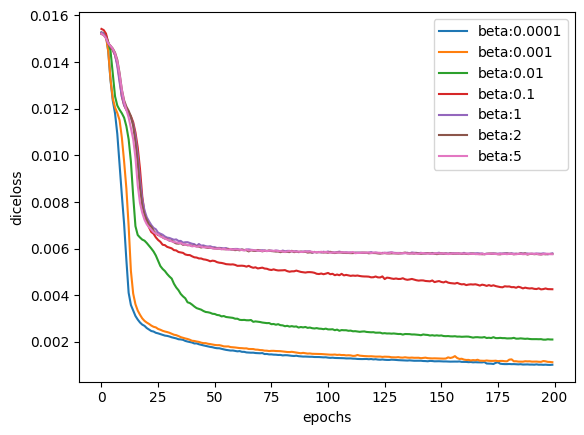

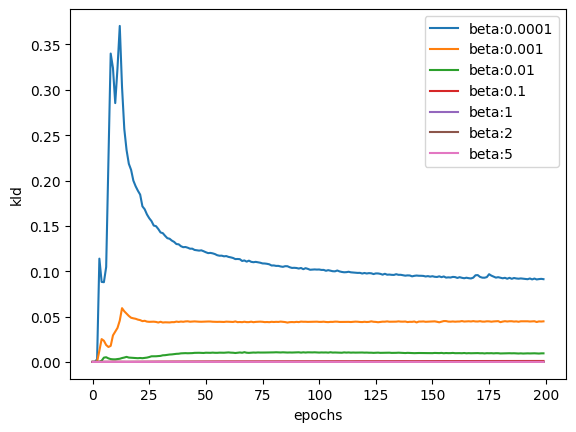

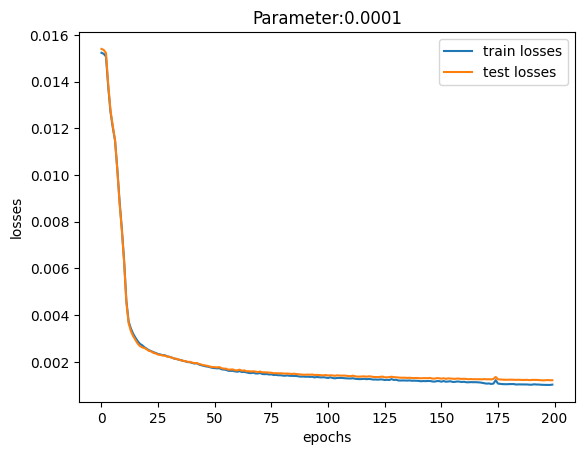

train losses:0.0010240375995635986
test losses:0.0012124890927225351


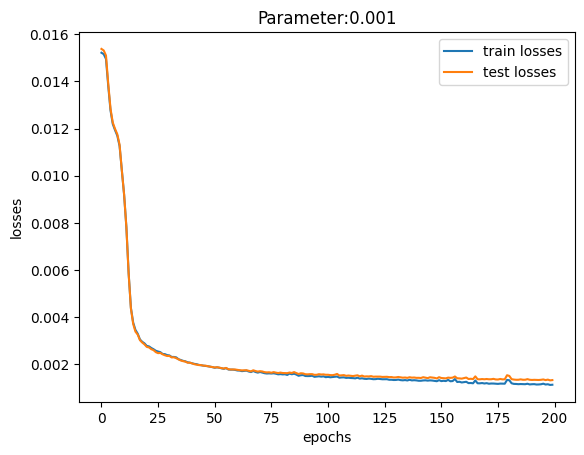

train losses:0.001130079966969788
test losses:0.0013272821670398116


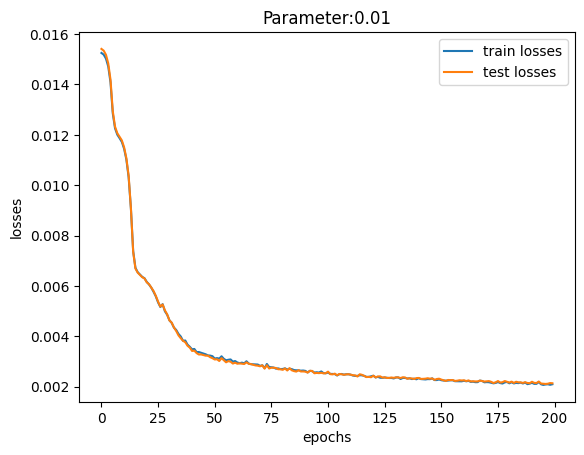

train losses:0.002098868368193507
test losses:0.0021388225723057985


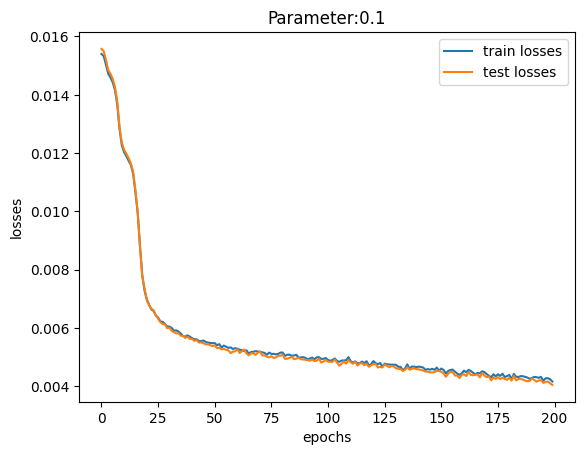

train losses:0.0041646212339401245
test losses:0.00404852069914341


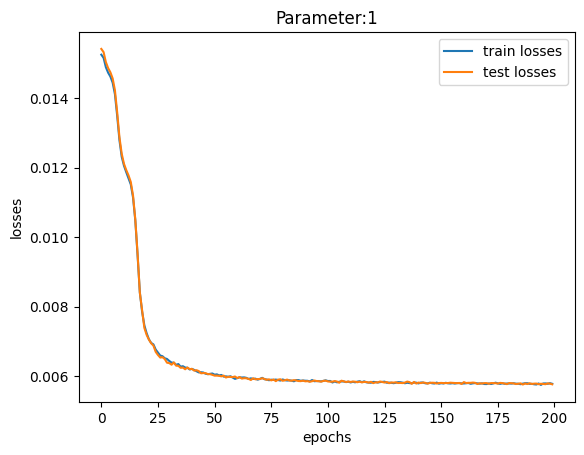

train losses:0.005779458209872246
test losses:0.005765395238995552


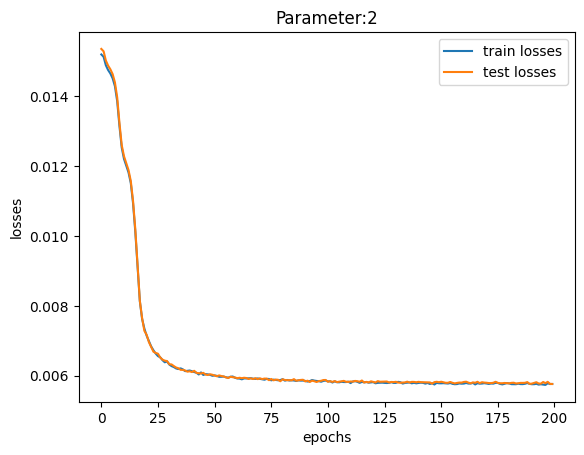

train losses:0.005763613618910313
test losses:0.005763540510088205


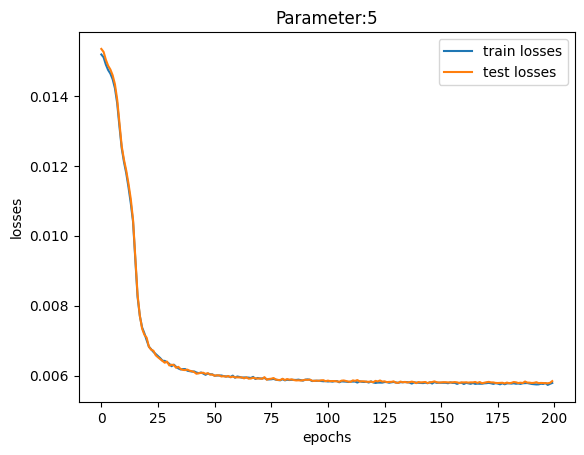

train losses:0.005788593553006649
test losses:0.005841804668307304


In [ ]:
# affichage des courbes décrivant l'influence des betas

# évolution de la dice loss
for i in range (len(betas)):
  plt.plot(dice_losses[i], label='beta:' + str(betas[i]))
plt.xlabel('epochs')
plt.ylabel('diceloss')
plt.legend()
plt.show()


# évolution de la kld loss
for i in range (len(betas)):
  plt.plot(kld_losses[i], label='beta:' + str(betas[i]))
plt.xlabel('epochs')
plt.ylabel('kld')
plt.legend()
plt.show()


# évolution du train_loss et test loss
for i in range (len(betas)):
  plt.plot(train_losses[i], label='train losses')
  plt.plot(test_losses[i], label='test losses')
  plt.title('Parameter:' + str(betas[i]))
  plt.xlabel('epochs')
  plt.ylabel('losses')
  plt.legend()
  plt.show()
  print("train losses:"+str(train_losses[i][-1]))
  print("test losses:"+str(test_losses[i][-1]))

##**Exploration espace latent**

In [ ]:
#entrainement d'un nouveau model avec les paramètres optimaux
z_dim = 32
n_classes = 5
n_epochs = 200
vae_model= VAE(z_dim, n_rows, n_col)
vae_optimizer= optim.Adam(vae_model.parameters(), lr = 1e-4, weight_decay=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vae_model.to(device)
for epoch in range(0, n_epochs):
  train_vae(vae_model,train_loader, vae_optimizer, epoch, beta_=0.01)

rows and cols 80 80


30it [00:08,  3.71it/s]


====> Epoch: 0 Average loss: 3.0445


30it [00:00, 44.27it/s]


====> Epoch: 1 Average loss: 3.0298


30it [00:00, 46.18it/s]


====> Epoch: 2 Average loss: 2.9866


30it [00:00, 45.39it/s]


====> Epoch: 3 Average loss: 2.9462


30it [00:00, 43.98it/s]


====> Epoch: 4 Average loss: 2.8889


30it [00:00, 43.25it/s]


====> Epoch: 5 Average loss: 2.7227


30it [00:00, 45.38it/s]


====> Epoch: 6 Average loss: 2.5532


30it [00:00, 43.07it/s]


====> Epoch: 7 Average loss: 2.4698


30it [00:00, 45.02it/s]


====> Epoch: 8 Average loss: 2.4289


30it [00:00, 43.08it/s]


====> Epoch: 9 Average loss: 2.4007


30it [00:00, 42.50it/s]


====> Epoch: 10 Average loss: 2.3675


30it [00:00, 44.02it/s]


====> Epoch: 11 Average loss: 2.3050


30it [00:00, 42.63it/s]


====> Epoch: 12 Average loss: 2.1631


30it [00:00, 45.85it/s]


====> Epoch: 13 Average loss: 1.9247


30it [00:00, 43.27it/s]


====> Epoch: 14 Average loss: 1.6360


30it [00:00, 41.27it/s]


====> Epoch: 15 Average loss: 1.4931


30it [00:00, 39.01it/s]


====> Epoch: 16 Average loss: 1.4303


30it [00:00, 41.25it/s]


====> Epoch: 17 Average loss: 1.3885


30it [00:00, 41.38it/s]


====> Epoch: 18 Average loss: 1.3625


30it [00:00, 40.62it/s]


====> Epoch: 19 Average loss: 1.3450


30it [00:00, 39.24it/s]


====> Epoch: 20 Average loss: 1.3328


30it [00:00, 40.65it/s]


====> Epoch: 21 Average loss: 1.3109


30it [00:00, 43.18it/s]


====> Epoch: 22 Average loss: 1.2868


30it [00:00, 43.24it/s]


====> Epoch: 23 Average loss: 1.2496


30it [00:00, 45.22it/s]


====> Epoch: 24 Average loss: 1.2077


30it [00:00, 42.88it/s]


====> Epoch: 25 Average loss: 1.1707


30it [00:00, 44.03it/s]


====> Epoch: 26 Average loss: 1.1515


30it [00:00, 45.87it/s]


====> Epoch: 27 Average loss: 1.1152


30it [00:00, 44.44it/s]


====> Epoch: 28 Average loss: 1.0769


30it [00:00, 44.20it/s]


====> Epoch: 29 Average loss: 1.0350


30it [00:00, 42.78it/s]


====> Epoch: 30 Average loss: 0.9955


30it [00:00, 45.04it/s]


====> Epoch: 31 Average loss: 0.9613


30it [00:00, 45.80it/s]


====> Epoch: 32 Average loss: 0.9344


30it [00:00, 46.56it/s]


====> Epoch: 33 Average loss: 0.9155


30it [00:00, 43.85it/s]


====> Epoch: 34 Average loss: 0.8980


30it [00:00, 43.57it/s]


====> Epoch: 35 Average loss: 0.8809


30it [00:00, 38.57it/s]


====> Epoch: 36 Average loss: 0.8669


30it [00:00, 40.33it/s]


====> Epoch: 37 Average loss: 0.8566


30it [00:00, 38.91it/s]


====> Epoch: 38 Average loss: 0.8449


30it [00:00, 40.45it/s]


====> Epoch: 39 Average loss: 0.8307


30it [00:00, 39.59it/s]


====> Epoch: 40 Average loss: 0.8285


30it [00:00, 42.66it/s]


====> Epoch: 41 Average loss: 0.8221


30it [00:00, 44.83it/s]


====> Epoch: 42 Average loss: 0.8163


30it [00:00, 45.47it/s]


====> Epoch: 43 Average loss: 0.8038


30it [00:00, 44.25it/s]


====> Epoch: 44 Average loss: 0.8037


30it [00:00, 41.85it/s]


====> Epoch: 45 Average loss: 0.7955


30it [00:00, 40.35it/s]


====> Epoch: 46 Average loss: 0.7889


30it [00:00, 38.60it/s]


====> Epoch: 47 Average loss: 0.7852


30it [00:00, 38.39it/s]


====> Epoch: 48 Average loss: 0.7805


30it [00:00, 37.65it/s]


====> Epoch: 49 Average loss: 0.7774


30it [00:00, 36.55it/s]


====> Epoch: 50 Average loss: 0.7740


30it [00:00, 39.61it/s]


====> Epoch: 51 Average loss: 0.7642


30it [00:01, 24.61it/s]


====> Epoch: 52 Average loss: 0.7640


30it [00:00, 33.44it/s]


====> Epoch: 53 Average loss: 0.7589


30it [00:01, 26.43it/s]


====> Epoch: 54 Average loss: 0.7559


30it [00:00, 32.57it/s]


====> Epoch: 55 Average loss: 0.7458


30it [00:00, 34.52it/s]


====> Epoch: 56 Average loss: 0.7462


30it [00:00, 32.44it/s]


====> Epoch: 57 Average loss: 0.7436


30it [00:00, 32.12it/s]


====> Epoch: 58 Average loss: 0.7387


30it [00:00, 36.31it/s]


====> Epoch: 59 Average loss: 0.7377


30it [00:01, 26.65it/s]


====> Epoch: 60 Average loss: 0.7346


30it [00:01, 29.84it/s]


====> Epoch: 61 Average loss: 0.7292


30it [00:00, 38.97it/s]


====> Epoch: 62 Average loss: 0.7312


30it [00:00, 39.75it/s]


====> Epoch: 63 Average loss: 0.7206


30it [00:00, 36.28it/s]


====> Epoch: 64 Average loss: 0.7274


30it [00:00, 39.55it/s]


====> Epoch: 65 Average loss: 0.7236


30it [00:00, 36.09it/s]


====> Epoch: 66 Average loss: 0.7182


30it [00:00, 34.36it/s]


====> Epoch: 67 Average loss: 0.7158


30it [00:00, 36.41it/s]


====> Epoch: 68 Average loss: 0.7128


30it [00:00, 37.62it/s]


====> Epoch: 69 Average loss: 0.7153


30it [00:01, 28.57it/s]


====> Epoch: 70 Average loss: 0.7125


30it [00:01, 24.83it/s]


====> Epoch: 71 Average loss: 0.7108


30it [00:01, 20.32it/s]


====> Epoch: 72 Average loss: 0.7069


30it [00:01, 15.28it/s]


====> Epoch: 73 Average loss: 0.7038


30it [00:00, 31.69it/s]


====> Epoch: 74 Average loss: 0.7019


30it [00:00, 33.39it/s]


====> Epoch: 75 Average loss: 0.6990


30it [00:00, 33.53it/s]


====> Epoch: 76 Average loss: 0.7013


30it [00:00, 36.26it/s]


====> Epoch: 77 Average loss: 0.6986


30it [00:00, 37.70it/s]


====> Epoch: 78 Average loss: 0.6907


30it [00:00, 44.00it/s]


====> Epoch: 79 Average loss: 0.6913


30it [00:00, 44.53it/s]


====> Epoch: 80 Average loss: 0.6931


30it [00:00, 40.46it/s]


====> Epoch: 81 Average loss: 0.6890


30it [00:00, 41.72it/s]


====> Epoch: 82 Average loss: 0.6876


30it [00:00, 41.20it/s]


====> Epoch: 83 Average loss: 0.6859


30it [00:00, 34.48it/s]


====> Epoch: 84 Average loss: 0.6839


30it [00:00, 30.37it/s]


====> Epoch: 85 Average loss: 0.6842


30it [00:01, 19.96it/s]


====> Epoch: 86 Average loss: 0.6798


30it [00:01, 24.61it/s]


====> Epoch: 87 Average loss: 0.6800


30it [00:01, 25.05it/s]


====> Epoch: 88 Average loss: 0.6756


30it [00:00, 34.41it/s]


====> Epoch: 89 Average loss: 0.6762


30it [00:01, 22.55it/s]


====> Epoch: 90 Average loss: 0.6750


30it [00:00, 35.26it/s]


====> Epoch: 91 Average loss: 0.6680


30it [00:00, 43.86it/s]


====> Epoch: 92 Average loss: 0.6697


30it [00:00, 41.02it/s]


====> Epoch: 93 Average loss: 0.6684


30it [00:00, 31.16it/s]


====> Epoch: 94 Average loss: 0.6664


30it [00:01, 26.10it/s]


====> Epoch: 95 Average loss: 0.6710


30it [00:01, 28.14it/s]


====> Epoch: 96 Average loss: 0.6663


30it [00:00, 30.04it/s]


====> Epoch: 97 Average loss: 0.6638


30it [00:00, 30.47it/s]


====> Epoch: 98 Average loss: 0.6666


30it [00:01, 26.44it/s]


====> Epoch: 99 Average loss: 0.6631


30it [00:01, 28.58it/s]


====> Epoch: 100 Average loss: 0.6572


30it [00:00, 37.66it/s]


====> Epoch: 101 Average loss: 0.6591


30it [00:00, 39.23it/s]


====> Epoch: 102 Average loss: 0.6615


30it [00:00, 39.27it/s]


====> Epoch: 103 Average loss: 0.6597


30it [00:00, 39.81it/s]


====> Epoch: 104 Average loss: 0.6540


30it [00:00, 43.57it/s]


====> Epoch: 105 Average loss: 0.6519


30it [00:00, 44.84it/s]


====> Epoch: 106 Average loss: 0.6555


30it [00:00, 43.98it/s]


====> Epoch: 107 Average loss: 0.6550


30it [00:00, 44.06it/s]


====> Epoch: 108 Average loss: 0.6511


30it [00:00, 42.82it/s]


====> Epoch: 109 Average loss: 0.6436


30it [00:00, 44.40it/s]


====> Epoch: 110 Average loss: 0.6418


30it [00:00, 43.44it/s]


====> Epoch: 111 Average loss: 0.6466


30it [00:00, 44.35it/s]


====> Epoch: 112 Average loss: 0.6434


30it [00:00, 43.00it/s]


====> Epoch: 113 Average loss: 0.6414


30it [00:00, 43.49it/s]


====> Epoch: 114 Average loss: 0.6429


30it [00:00, 42.80it/s]


====> Epoch: 115 Average loss: 0.6435


30it [00:00, 42.72it/s]


====> Epoch: 116 Average loss: 0.6377


30it [00:00, 45.62it/s]


====> Epoch: 117 Average loss: 0.6419


30it [00:00, 44.02it/s]


====> Epoch: 118 Average loss: 0.6460


30it [00:00, 38.91it/s]


====> Epoch: 119 Average loss: 0.6370


30it [00:00, 32.71it/s]


====> Epoch: 120 Average loss: 0.6374


30it [00:00, 34.97it/s]


====> Epoch: 121 Average loss: 0.6365


30it [00:01, 24.41it/s]


====> Epoch: 122 Average loss: 0.6327


30it [00:00, 33.24it/s]


====> Epoch: 123 Average loss: 0.6322


30it [00:00, 40.15it/s]


====> Epoch: 124 Average loss: 0.6302


30it [00:00, 39.33it/s]


====> Epoch: 125 Average loss: 0.6267


30it [00:00, 40.85it/s]


====> Epoch: 126 Average loss: 0.6311


30it [00:00, 36.52it/s]


====> Epoch: 127 Average loss: 0.6310


30it [00:00, 37.66it/s]


====> Epoch: 128 Average loss: 0.6288


30it [00:00, 35.28it/s]


====> Epoch: 129 Average loss: 0.6298


30it [00:00, 37.87it/s]


====> Epoch: 130 Average loss: 0.6215


30it [00:00, 35.19it/s]


====> Epoch: 131 Average loss: 0.6231


30it [00:00, 34.03it/s]


====> Epoch: 132 Average loss: 0.6228


30it [00:00, 34.47it/s]


====> Epoch: 133 Average loss: 0.6219


30it [00:00, 35.23it/s]


====> Epoch: 134 Average loss: 0.6203


30it [00:00, 36.57it/s]


====> Epoch: 135 Average loss: 0.6203


30it [00:00, 35.19it/s]


====> Epoch: 136 Average loss: 0.6203


30it [00:00, 36.18it/s]


====> Epoch: 137 Average loss: 0.6252


30it [00:00, 35.00it/s]


====> Epoch: 138 Average loss: 0.6158


30it [00:01, 25.57it/s]


====> Epoch: 139 Average loss: 0.6193


30it [00:00, 36.11it/s]


====> Epoch: 140 Average loss: 0.6130


30it [00:00, 39.13it/s]


====> Epoch: 141 Average loss: 0.6131


30it [00:00, 42.88it/s]


====> Epoch: 142 Average loss: 0.6108


30it [00:00, 40.00it/s]


====> Epoch: 143 Average loss: 0.6183


30it [00:00, 43.40it/s]


====> Epoch: 144 Average loss: 0.6076


30it [00:00, 37.87it/s]


====> Epoch: 145 Average loss: 0.6125


30it [00:00, 33.71it/s]


====> Epoch: 146 Average loss: 0.6062


30it [00:00, 33.95it/s]


====> Epoch: 147 Average loss: 0.6129


30it [00:01, 28.78it/s]


====> Epoch: 148 Average loss: 0.6104


30it [00:00, 32.47it/s]


====> Epoch: 149 Average loss: 0.6044


30it [00:01, 22.49it/s]


====> Epoch: 150 Average loss: 0.6092


30it [00:00, 40.63it/s]


====> Epoch: 151 Average loss: 0.6072


30it [00:00, 41.52it/s]


====> Epoch: 152 Average loss: 0.6052


30it [00:00, 36.52it/s]


====> Epoch: 153 Average loss: 0.6030


30it [00:00, 39.71it/s]


====> Epoch: 154 Average loss: 0.5999


30it [00:00, 39.71it/s]


====> Epoch: 155 Average loss: 0.6008


30it [00:00, 37.06it/s]


====> Epoch: 156 Average loss: 0.5974


30it [00:00, 38.88it/s]


====> Epoch: 157 Average loss: 0.5960


30it [00:00, 40.29it/s]


====> Epoch: 158 Average loss: 0.5940


30it [00:00, 44.27it/s]


====> Epoch: 159 Average loss: 0.5951


30it [00:00, 43.42it/s]


====> Epoch: 160 Average loss: 0.5941


30it [00:00, 42.07it/s]


====> Epoch: 161 Average loss: 0.5936


30it [00:00, 42.05it/s]


====> Epoch: 162 Average loss: 0.5938


30it [00:00, 42.11it/s]


====> Epoch: 163 Average loss: 0.5977


30it [00:00, 42.71it/s]


====> Epoch: 164 Average loss: 0.5980


30it [00:00, 41.69it/s]


====> Epoch: 165 Average loss: 0.5961


30it [00:00, 43.88it/s]


====> Epoch: 166 Average loss: 0.5944


30it [00:00, 43.98it/s]


====> Epoch: 167 Average loss: 0.5910


30it [00:00, 34.63it/s]


====> Epoch: 168 Average loss: 0.5927


30it [00:01, 27.19it/s]


====> Epoch: 169 Average loss: 0.5911


30it [00:00, 40.69it/s]


====> Epoch: 170 Average loss: 0.5900


30it [00:00, 41.72it/s]


====> Epoch: 171 Average loss: 0.5887


30it [00:00, 39.42it/s]


====> Epoch: 172 Average loss: 0.5861


30it [00:00, 39.46it/s]


====> Epoch: 173 Average loss: 0.5887


30it [00:00, 34.68it/s]


====> Epoch: 174 Average loss: 0.5897


30it [00:00, 32.32it/s]


====> Epoch: 175 Average loss: 0.5865


30it [00:01, 29.13it/s]


====> Epoch: 176 Average loss: 0.5863


30it [00:00, 36.04it/s]


====> Epoch: 177 Average loss: 0.5841


30it [00:00, 36.60it/s]


====> Epoch: 178 Average loss: 0.5844


30it [00:00, 39.16it/s]


====> Epoch: 179 Average loss: 0.5856


30it [00:00, 34.48it/s]


====> Epoch: 180 Average loss: 0.5847


30it [00:00, 33.79it/s]


====> Epoch: 181 Average loss: 0.5836


30it [00:00, 36.95it/s]


====> Epoch: 182 Average loss: 0.5816


30it [00:00, 36.28it/s]


====> Epoch: 183 Average loss: 0.5791


30it [00:00, 38.66it/s]


====> Epoch: 184 Average loss: 0.5850


30it [00:00, 33.43it/s]


====> Epoch: 185 Average loss: 0.5792


30it [00:00, 33.86it/s]


====> Epoch: 186 Average loss: 0.5782


30it [00:00, 36.49it/s]


====> Epoch: 187 Average loss: 0.5810


30it [00:00, 36.16it/s]


====> Epoch: 188 Average loss: 0.5747


30it [00:00, 31.75it/s]


====> Epoch: 189 Average loss: 0.5755


30it [00:00, 37.08it/s]


====> Epoch: 190 Average loss: 0.5764


30it [00:00, 36.87it/s]


====> Epoch: 191 Average loss: 0.5769


30it [00:00, 40.38it/s]


====> Epoch: 192 Average loss: 0.5725


30it [00:00, 38.93it/s]


====> Epoch: 193 Average loss: 0.5739


30it [00:00, 37.74it/s]


====> Epoch: 194 Average loss: 0.5767


30it [00:00, 41.92it/s]


====> Epoch: 195 Average loss: 0.5822


30it [00:00, 43.64it/s]


====> Epoch: 196 Average loss: 0.5802


30it [00:00, 42.15it/s]


====> Epoch: 197 Average loss: 0.5722


30it [00:00, 41.86it/s]


====> Epoch: 198 Average loss: 0.5703


30it [00:00, 43.01it/s]

====> Epoch: 199 Average loss: 0.5738


In [ ]:
def reduction_dim_tsne(z):
  """
  Reduce the dimension of z using TSNE
  """
  tsne = TSNE(n_components=2, perplexity=50, learning_rate=10)
  return tsne.fit_transform(z)

def reduction_dim_umap(z):
  """
  Reduce the dimension of z using UMAP
  """
  fit = umap.UMAP(n_neighbors=500, min_dist=1, n_components=2)
  u = fit.fit_transform(z)
  return u

def reduction_dim_ica(z):
  """
  Reduce the dimension of z using ICA
  """
  ica = FastICA(n_components=2)
  return ica.fit_transform(z)

def get_points(vae_model,data_train_loader,reduction_dim):
  """
  Reduce the latent space vectors of a model into a space of dimension 2
  """
  points_tab=[]
  label_tab=[]
  intern_tab=[]
  for batch_idx, (data, lab) in tqdm(enumerate(data_train_loader)):
    if torch.cuda.is_available() :
        data = data.cuda()
    z_mu, z_log_var = vae_model.encoder(data)
    z=vae_model.sampling(z_mu,z_log_var)
    intern_tab.append(z.cpu().detach().numpy())
    label_tab.append(lab)
  intern_tab=np.concatenate(intern_tab)
  points_tab=reduction_dim(intern_tab)

  return points_tab,label_tab

30it [00:00, 183.64it/s]


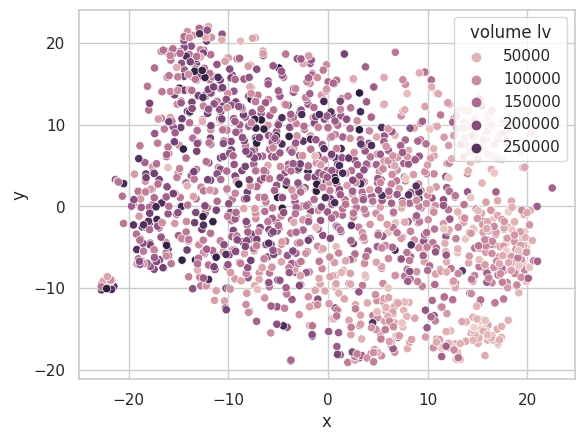

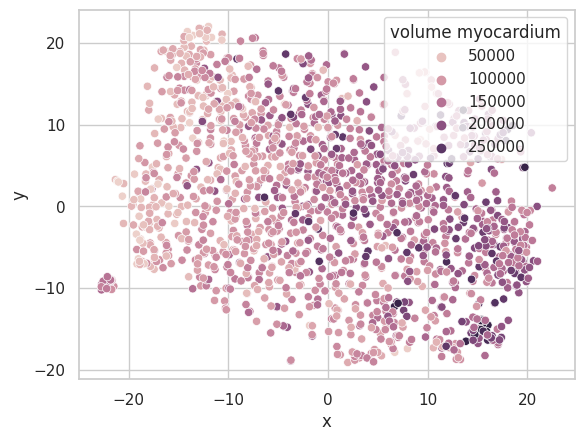

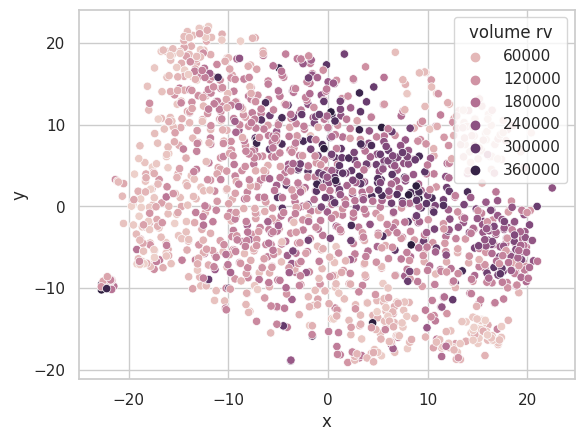

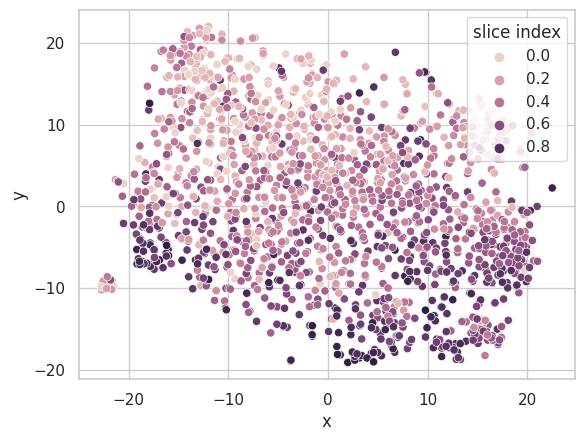

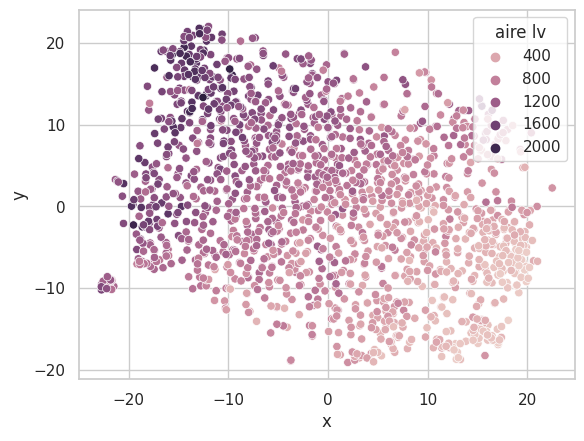

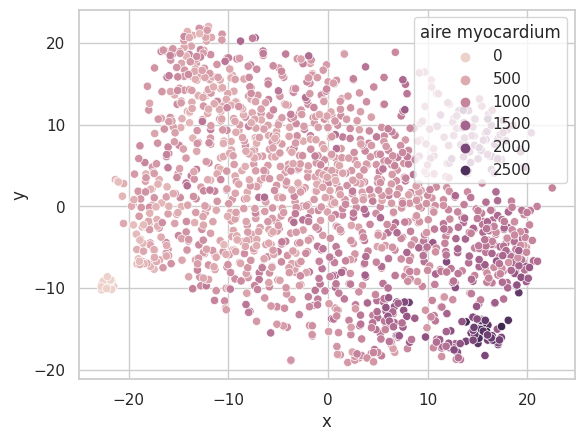

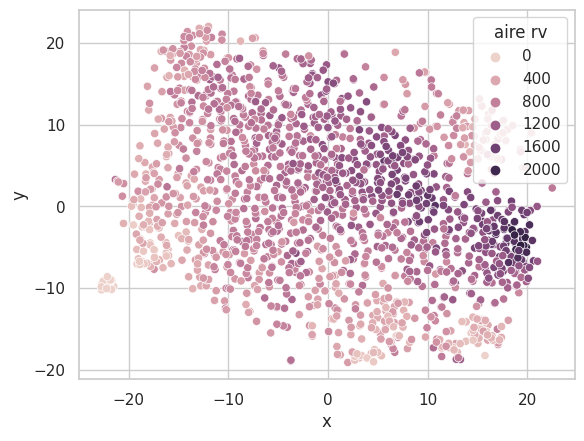

In [ ]:
# Visualisation des résultats

z,labels =get_points(vae_model,train_loader, reduction_dim_tsne)
lab_0 = np.concatenate(labels)[:,0]
lab_1 = np.concatenate(labels)[:, 1]
lab_2 = np.concatenate(labels)[:, 2]
lab_3 = np.concatenate(labels)[:, 3]
lab_4 = np.concatenate(labels)[:, 4]
lab_5 = np.concatenate(labels)[:, 5]
lab_6 = np.concatenate(labels)[:, 6]
# Create a DataFrame using the combined points array
df_0 = pd.DataFrame({"x": z[:, 0], "y": z[:, 1], "volume lv": lab_0})
df_1 = pd.DataFrame({"x": z[:, 0], "y": z[:, 1], "volume myocardium": lab_1})
df_2 = pd.DataFrame({"x": z[:, 0], "y": z[:, 1], "volume rv": lab_2})
df_3 = pd.DataFrame({"x": z[:, 0], "y": z[:, 1], "slice index": lab_3})
df_4 = pd.DataFrame({"x": z[:, 0], "y": z[:, 1], "aire lv": lab_4})
df_5 = pd.DataFrame({"x": z[:, 0], "y": z[:, 1], "aire myocardium": lab_5})
df_6 = pd.DataFrame({"x": z[:, 0], "y": z[:, 1], "aire rv": lab_6})
# Set the seaborn theme and style
sns.set_theme(style="whitegrid")
sns.scatterplot(data=df_0, x="x", y="y", hue="volume lv") #,palette="viridis"
plt.show()

sns.set_theme(style="whitegrid")
sns.scatterplot(data=df_1, x="x", y="y", hue="volume myocardium")
plt.show()

sns.set_theme(style="whitegrid")
sns.scatterplot(data=df_2, x="x", y="y", hue="volume rv")
plt.show()

sns.set_theme(style="whitegrid")
sns.scatterplot(data=df_3, x="x", y="y", hue="slice index")
plt.show()

sns.set_theme(style="whitegrid")
sns.scatterplot(data=df_4, x="x", y="y", hue="aire lv")
plt.show()

sns.set_theme(style="whitegrid")
sns.scatterplot(data=df_5, x="x", y="y", hue="aire myocardium")
plt.show()

sns.set_theme(style="whitegrid")
sns.scatterplot(data=df_6, x="x", y="y", hue="aire rv")
plt.show()